In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import gc
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split,cross_val_score,GridSearchCV,cross_validate
from sklearn.preprocessing import MinMaxScaler,LabelEncoder,StandardScaler,RobustScaler
from sklearn.impute import KNNImputer
from sklearn.metrics import accuracy_score,recall_score,precision_score,f1_score,roc_auc_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier,VotingClassifier,AdaBoostClassifier
from sklearn.metrics import classification_report
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/ieee-fraud-detection/sample_submission.csv
/kaggle/input/ieee-fraud-detection/test_identity.csv
/kaggle/input/ieee-fraud-detection/train_identity.csv
/kaggle/input/ieee-fraud-detection/test_transaction.csv
/kaggle/input/ieee-fraud-detection/train_transaction.csv


### Данный проект решает задачу бинарной классификации.
### Нужно предсказать, к какому типу относится транзакция - мошенническая она ли нет.

#### Данные в датасете **transaction**:
<span style="font-size: 18px;">
    
- TransactionDT - дельта времени от заданного эталонного значения времени (не актуального значения) 
- TransactionAMT - транзакционный платёж в USD
- ProductCD - продуктовый код, продукт каждой транзакции
- card1 - card6 - информация платёжной карты, такая как: тип карты, категория, банк выпуска, страна и т.д.
- addr - адрес
- dist - расстояние
- P_ and (R_) emaildomain: домены покупателя и получателя
- C1-C14 - подсчёт, например сколько адресов связано с платёжной картой и т.д. Фактический смысл скрыт
- D1-D15 - дельта времени, количество дней между предыдущей транзакцией, и т.д.
- M1 - M9 -совпадение, например имена на карте и адресе и т.д.
- Vxxx - Vesta разработала богатые функции, включая ранжирование, подсчёт и другие отношения между сущностями
</span>

<span style="font-size:18px;">
Категориальные признаки:

- ProductCD
- card1-card6
- addr1, addr2
- P_emaildomain
- R_email_domain
- M1 - M9
</span>

#### Данные в датасете **Identity**
<span style="font-size:18px;">
Переменные в этой таблице - идентификационные данные:
    
- информация о сетевом соединении (IP, ISP, прокси и т.д.)
- цифровая подпись (UA/браузер/ОС/версия и т.д.), связанные с транзакциями.
Их собирает система защиты от мошенничества Vesta и партнеры цифровой безопасности.
(Имена полей скрыты, и пояснения значений полей не будет в целях защиты конфиденциальности и их договорного соглашения)
</span>

<span style="font-size:18px;">
Категориальные признаки:
    
- DeviceType
- DeviceInfo
- id_12 - id_38
</span>

### Загрузим все наборы данных данного проекта

In [2]:
train_transaction=pd.read_csv('/kaggle/input/ieee-fraud-detection/train_transaction.csv')
train_identity=pd.read_csv('/kaggle/input/ieee-fraud-detection/train_identity.csv')
test_transaction=pd.read_csv('/kaggle/input/ieee-fraud-detection/test_transaction.csv')
test_identity=pd.read_csv('/kaggle/input/ieee-fraud-detection/test_identity.csv')
sample_submission=pd.read_csv('/kaggle/input/ieee-fraud-detection/sample_submission.csv')

Объединим таблицы ```*transaction``` и ```*identity``` по полю ```TransactionID```

In [3]:
train = train_transaction.merge(train_identity, how='left', on='TransactionID')
test = test_transaction.merge(test_identity, how='left', on='TransactionID')

Т.к. мы объединили датасеты ```*identity``` и ```*transaction```, удалим их для того, чтобы освободить память

In [4]:
del train_transaction
del train_identity
del test_transaction
del test_identity
gc.collect

<function gc.collect(generation=2)>

Создадим копии датасетов, с которыми будем работать, чтобы не менять исходники

In [5]:
train_df = train.copy()
test_df = test.copy()

Посмотрим какой объём оперативной памяти занимают датасеты:

In [6]:
train_df_GB = train_df.memory_usage(deep=True).sum()/1024**3
test_df_GB = test_df.memory_usage(deep=True).sum()/1024**3

print(f'train df: {train_df_GB:.2f} GB of memory')
print(f'test df : {test_df_GB:.2f} GB of memory')

train df: 2.51 GB of memory
test df : 2.16 GB of memory


Видим, что датафреймы занимают достаточно большой объём оперативной памяти, следовательно на обработку каждого датафрейма будет затрачено большое кол-во ресурсов и довольно длительное время.

Напишем функцию подсчёта объема занимаемой памяти:

In [7]:
def memory_usage(pandas_object):
    if isinstance(pandas_object, pd.DataFrame):
        usage_b = pandas_object.memory_usage(deep=True).sum()
    else:
        usage_b = pandas_obj.memory_usage(deep=True)
    usage_mb = usage_b / 1024 ** 2 # convert to mb
    return usage_mb

Напишем функцию для уменьшения объёма занимаемой памяти датасетом.

1. Преобразуем все значения подтипов ```int``` в тип ```uint```, т.к. хранение только положительных значений позволит нам уменьшить объём занимаемой памяти.

2. Все значения подтипов ```float``` в тип ```float```
2. ```object``` в ```category```

In [8]:
def reduce_mem_usage_num(df, name):
    start_memory = memory_usage(df)
    
    # convert int
    df_int = df.select_dtypes(include=['int'])
    converted_int = df_int.apply(pd.to_numeric, downcast='unsigned')
    
    # convert float
    df_float = df.select_dtypes(include=['float'])
    converted_float = df_float.apply(pd.to_numeric, downcast='float')
    
    optimized_df = df.copy()
    optimized_df[converted_int.columns] = converted_int
    optimized_df[converted_float.columns] = converted_float
    
    finish_memory = memory_usage(optimized_df)
    diff_memory = start_memory - finish_memory
    diff_memory_prct = 100 - ((finish_memory * 100)/start_memory)
    print(f'start memory of {name} is {start_memory} Mb')
    print(f'memory after optimization of {name} is {finish_memory} Mb')
    print(f'memory usage of {name} decreased on {diff_memory} Mb ({diff_memory_prct} %)\n')
    return optimized_df

In [9]:
train_df = reduce_mem_usage_num(train_df, 'train_df')
test_df = reduce_mem_usage_num(test_df, 'test_df')

start memory of train_df is 2567.094612121582 Mb
memory after optimization of train_df is 1656.4279747009277 Mb
memory usage of train_df decreased on 910.6666374206543 Mb (35.47460358962117 %)

start memory of test_df is 2214.031036376953 Mb
memory after optimization of test_df is 1436.0497455596924 Mb
memory usage of test_df decreased on 777.9812908172607 Mb (35.13868044462248 %)



In [10]:
for col in train_df.columns:
    if train_df[col].dtype == 'object':
        train_df[col] = train_df[col].astype('category')

In [11]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 590540 entries, 0 to 590539
Columns: 434 entries, TransactionID to DeviceInfo
dtypes: category(31), float32(399), uint16(1), uint32(2), uint8(1)
memory usage: 924.3 MB


In [12]:
for col in test_df.columns:
    if test_df[col].dtype == 'object':
        test_df[col] = test_df[col].astype('category')

In [13]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506691 entries, 0 to 506690
Columns: 433 entries, TransactionID to DeviceInfo
dtypes: category(31), float32(399), uint16(1), uint32(2)
memory usage: 792.6 MB


In [14]:
print(f'train_df decreased on {100 - (memory_usage(train_df) * 100)/2567.094} %')
print(f'test_df decreased on {100 - (memory_usage(test_df) * 100)/2214.031} %')

train_df decreased on 63.989099234193674 %
test_df decreased on 64.19355467369698 %


Видим, что объём памяти, занимаемый каждым датасетом после преобразования типов признаков уменьшился примерно на ```64``` %

#### Напишем функцию, которая будет представлять отчёт о пропусках в данных

In [15]:
def missing_values_table(df, df_name):
    mis_val = df.isnull().sum()
    len_df = len(df)
    mis_val_percent = 100 * mis_val / len_df
    mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
    mis_val_table_ren_columns = mis_val_table.rename(
    columns = {0: 'Missing Values', 1: '% of Total Values'})
    
    mis_val_table_ren_columns = mis_val_table_ren_columns[
        mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
    '% of Total Values', ascending=False).round(1)
    
    print(f'{df_name} has ', str(df.shape[1]) + ' columns.\n',
         'There are ' + str(mis_val_table_ren_columns.shape[0]) +
          ' columns that have missing values.')
    return mis_val_table_ren_columns

In [16]:
missing_values_table(train_df, 'train_df')

train_df has  434 columns.
 There are 414 columns that have missing values.


Missing Values  % of Total Values
id_24          585793               99.2
id_25          585408               99.1
id_07          585385               99.1
id_08          585385               99.1
id_21          585381               99.1
...               ...                ...
V285               12                0.0
V284               12                0.0
V280               12                0.0
V279               12                0.0
V312               12                0.0

[414 rows x 2 columns]

In [17]:
missing_values_table(test_df, 'test_df')

test_df has  433 columns.
 There are 385 columns that have missing values.


Missing Values  % of Total Values
id-24          501951               99.1
id-25          501652               99.0
id-26          501644               99.0
id-08          501632               99.0
id-07          501632               99.0
...               ...                ...
V293                3                0.0
C14                 3                0.0
V319                3                0.0
V292                3                0.0
V303                3                0.0

[385 rows x 2 columns]

Заменим признаки с ```-``` в тестовом датасете на соответствующие названия из тренировочного датасета с ```_```

In [18]:
test_df = test_df.rename(columns=lambda x:'_'.join(x.split('-')))

In [19]:
test_df

TransactionID  TransactionDT  TransactionAmt ProductCD  card1  card2  \
0             3663549       18403224       31.950001         W  10409  111.0   
1             3663550       18403263       49.000000         W   4272  111.0   
2             3663551       18403310      171.000000         W   4476  574.0   
3             3663552       18403310      284.950012         W  10989  360.0   
4             3663553       18403317       67.949997         W  18018  452.0   
...               ...            ...             ...       ...    ...    ...   
506686        4170235       34214279       94.679001         C  13832  375.0   
506687        4170236       34214287       12.173000         C   3154  408.0   
506688        4170237       34214326       49.000000         W  16661  490.0   
506689        4170238       34214337      202.000000         W  16621  516.0   
506690        4170239       34214345       24.346001         C   5713  168.0   

        card3       card4  card5   card6  ...                    id_31  id_32  \
0       150.0        visa  226.0   debit  ...                      NaN    NaN   
1       150.0        visa  226.0   debit  ...                      NaN    NaN   
2       150.0        visa  226.0   debit  ...                      NaN    NaN   
3       150.0        visa  166.0   debit  ...                      NaN    NaN   
4       150.0  mastercard  117.0   debit  ...                      NaN    NaN   
...       ...         ...    ...     ...  ...                      ...    ...   
506686  185.0  mastercard  224.0   debit  ...                      NaN    NaN   
506687  185.0  mastercard  224.0   debit  ...  chrome 43.0 for android    NaN   
506688  150.0        visa  226.0   debit  ...                      NaN    NaN   
506689  150.0  mastercard  224.0   debit  ...                      NaN    NaN   
506690  144.0        visa  147.0  credit  ...      samsung browser 8.2    NaN   

        id_33  id_34 id_35 id_36  id_37  id_38  DeviceType  \
0         NaN    NaN   NaN   NaN    NaN    NaN         NaN   
1         NaN    NaN   NaN   NaN    NaN    NaN         NaN   
2         NaN    NaN   NaN   NaN    NaN    NaN         NaN   
3         NaN    NaN   NaN   NaN    NaN    NaN         NaN   
4         NaN    NaN   NaN   NaN    NaN    NaN         NaN   
...       ...    ...   ...   ...    ...    ...         ...   
506686    NaN    NaN   NaN   NaN    NaN    NaN         NaN   
506687    NaN    NaN     F     F      T      F      mobile   
506688    NaN    NaN   NaN   NaN    NaN    NaN         NaN   
506689    NaN    NaN   NaN   NaN    NaN    NaN         NaN   
506690    NaN    NaN     F     F      T      F      mobile   

                         DeviceInfo  
0                               NaN  
1                               NaN  
2                               NaN  
3                               NaN  
4                               NaN  
...                             ...  
506686                          NaN  
506687  ALE-L23 Build/HuaweiALE-L23  
506688                          NaN  
506689                          NaN  
506690                      SAMSUNG  

[506691 rows x 433 columns]

Удаляем признаки, в которых более ```50 %``` пропусков:

In [20]:
missing_df = missing_values_table(train_df, 'train_df')
missing_columns = list(missing_df[missing_df['% of Total Values'] > 50.0].index)
print('We will remove %d columns.' % len(missing_columns))

train_df has  434 columns.
 There are 414 columns that have missing values.
We will remove 214 columns.


In [21]:
train_df = train_df.drop(columns = missing_columns)

In [22]:
train_df.shape

(590540, 220)

In [23]:
test_df = test_df.drop(columns = missing_columns)
test_df.shape

(506691, 219)

Посмотрим ещё раз на пропуски 

In [24]:
miss_val_train_df = missing_values_table(train_df, 'train_df')
miss_val_train_df

train_df has  220 columns.
 There are 200 columns that have missing values.


Missing Values  % of Total Values
M4            281444               47.7
D2            280797               47.5
V7            279287               47.3
V11           279287               47.3
V10           279287               47.3
...              ...                ...
V295              12                0.0
V297              12                0.0
V298              12                0.0
V299              12                0.0
V321              12                0.0

[200 rows x 2 columns]

In [25]:
missing_values_table(test_df, 'test_df')

test_df has  219 columns.
 There are 171 columns that have missing values.


Missing Values  % of Total Values
M4            237745               46.9
D2            234769               46.3
D3            203142               40.1
M3            176639               34.9
M2            176639               34.9
...              ...                ...
V287               3                0.0
V290               3                0.0
V292               3                0.0
V293               3                0.0
V321               3                0.0

[171 rows x 2 columns]

И посмотрим насколько ещё уменьшился занимаемый объём памяти каждого из датасетов

In [26]:
print(f'train_df memory usage: {memory_usage(train_df)} Mb')
print(f'test_df memory usage: {memory_usage(test_df)} Mb')

train_df memory usage: 477.58735275268555 Mb
test_df memory usage: 409.29405784606934 Mb


### Разделим обучающую выборку на обучение и тест

Отделим данные от целевой переменной

In [27]:
X = train_df.drop(columns='isFraud')
y = train_df['isFraud']

In [28]:
y

0         0
1         0
2         0
3         0
4         0
         ..
590535    0
590536    0
590537    0
590538    0
590539    0
Name: isFraud, Length: 590540, dtype: uint8

Разделим обучающую выборку в процентном соотношении:
- train - ```70%```
- test - ```30%```

In [29]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, stratify=y, test_size=0.3)

In [30]:
X_train.shape

(413378, 219)

In [31]:
y_train.shape

(413378,)

In [32]:
X_valid.shape

(177162, 219)

In [33]:
y_valid.shape

(177162,)

### Посмотрим на распределения признаков до заполнения пропусков

#### Посмотрим на распределение целевой переменной ```isFraud```

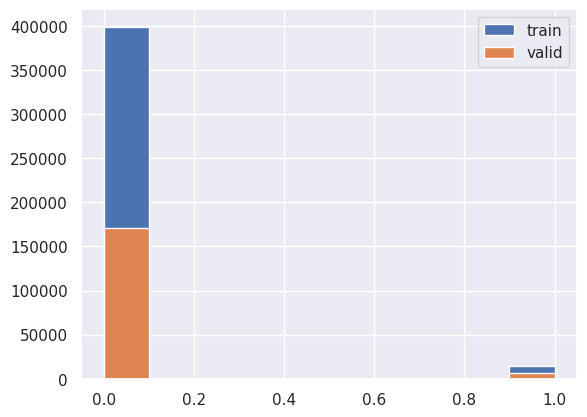

In [34]:
sns.set()
plt.hist(y_train, label='train')
plt.hist(y_valid, label='valid')
plt.legend()

In [35]:
isFraud_count = y_train.value_counts()
isFraud_prct = y_train.value_counts()/len(y_train)

pd.concat([isFraud_count, isFraud_prct], axis=1, keys=['Count', 'Percent'])

Count  Percent
isFraud                 
0        398914  0.96501
1         14464  0.03499

In [36]:
isFraud_count = y_valid.value_counts()
isFraud_prct = y_valid.value_counts()/len(y_valid)

pd.concat([isFraud_count, isFraud_prct], axis=1, keys=['Count', 'Percent'])

Count   Percent
isFraud                  
0        170963  0.965009
1          6199  0.034991

Видим, что данные не сбалансированы:

- ```96,5 %``` транзакций - валидны

- ```3,5 %``` транзакций - мошеннические

Подумаем о решении вопроса дисбаланса в данных. Исследуем другие признаки.

Напишем функцию для построения распределений признаков

In [37]:
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd',
          '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

def plot_value_counts(feature, title, df):
    ax = df[feature].value_counts().plot(kind='bar',
                                            figsize=(7,5),
                                            xlabel=title,
                                            ylabel='count',
                                            edgecolor='k',
                                            color=colors)
    ax.set_title(f'Percentage of {title}')
    counts = df[feature].value_counts()/len(df)
    
    rects = ax.patches
    labels_arr = ['{0:.2f}%'.format(count*100) for count in counts]
    
    if (len(labels_arr) > 2):
        plt.xticks(rotation=0, size=8)
        
    for rect, label in zip(rects, labels_arr):
        height = rect.get_height()
        ax.text(
            rect.get_x() + rect.get_width() / 2, height, label, ha='center', va='bottom'
        )
    
    plt.show()

#### Распределение ```Card 4``` (компания карты)

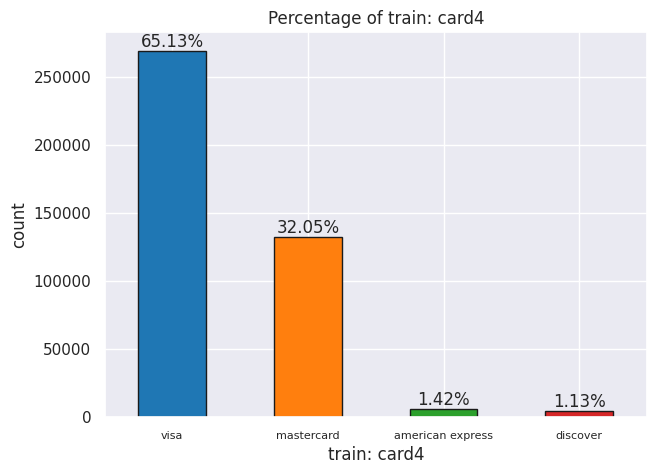

In [38]:
plot_value_counts('card4', 'train: card4', df=X_train)

Видим, что:

- ```65,34 %``` - карт компании 'visa'
- ```31,61 %``` - 'mastercard'
- ```1,68 %```  - 'american express'
- ```1,16 %```  - 'discover'

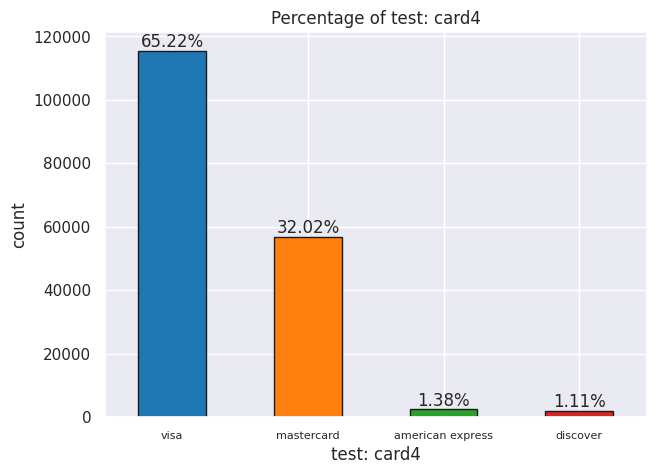

In [39]:
plot_value_counts('card4', 'test: card4', df=X_valid)

#### Распределение ```Card 6``` - тип карты

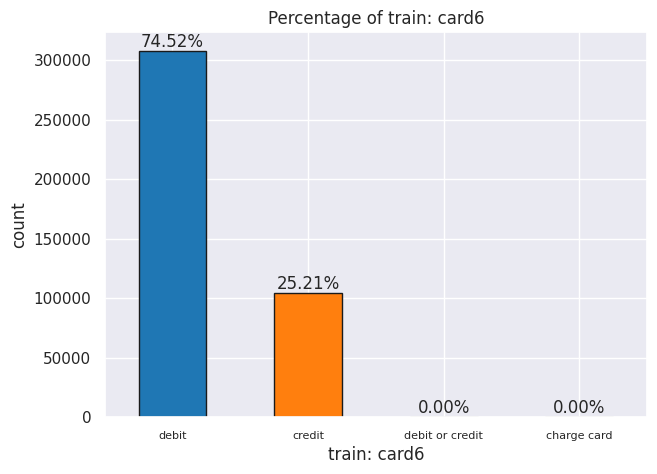

In [40]:
plot_value_counts('card6', 'train: card6', df=X_train)

Большая часть транзакций произведена дебетовыми картами - ```73,17 %```, ```26,61 %``` - кредитными картами. Транзакций с ```charge``` карт нет

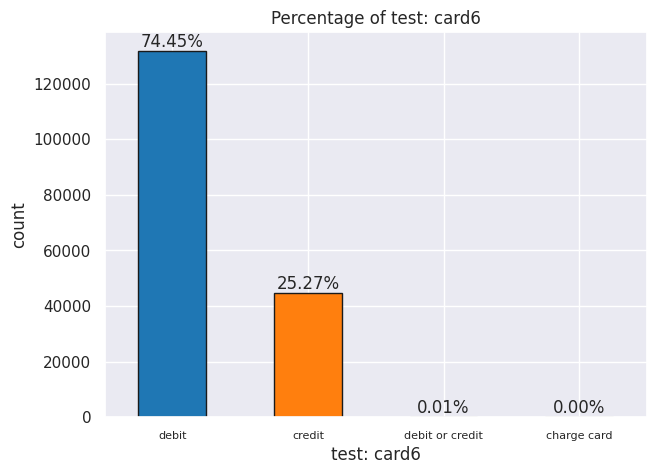

In [41]:
plot_value_counts('card6', 'test: card6', df=X_valid)

#### Посмотрим на распределение транзакций в разрезе компаний, выпустивших карты

Напишем функцию для визуализации распределения транзакций в разрезе какого-либо признака

In [42]:
def isFraud_by_feature(feature, df, title):
    sns.barplot(x=feature, y='isFraud', data=df)
    plt.xlabel(feature)
    plt.ylabel('isFraud')
    plt.title('Fraudulent Transactions by {}'.format(title))
    plt.show()

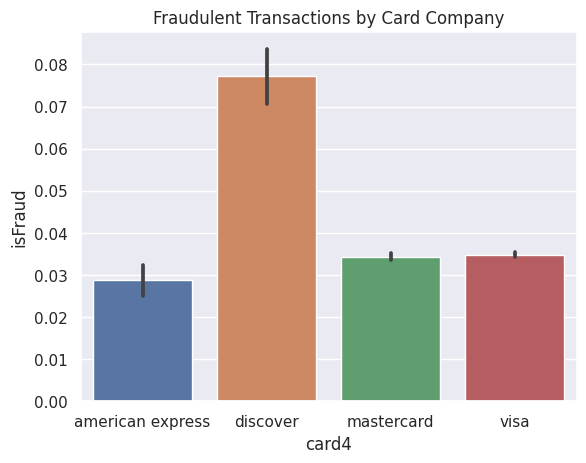

In [43]:
isFraud_by_feature('card4', df=train_df, title='Card Company')

Большинство операций произведено с карт ```discover```

#### Распределение транзакций в разрезе типа карты

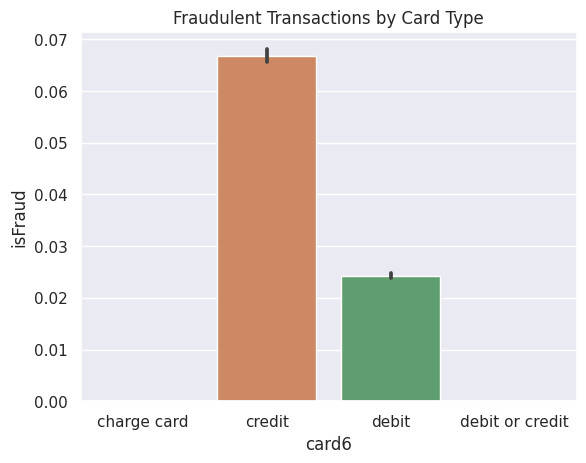

In [44]:
isFraud_by_feature('card6', df=train_df, title='Card Type')

Несмотря на то, что кредитные карты занимают ```25,23 %``` от всего объема данных, с них произведена большая часть транзакций

### Посмотрим, есть ли в данных дубликаты

In [45]:
X_train.duplicated().sum()

0

In [46]:
X_valid.duplicated().sum()

0

### Преобразуем категориальные признаки в числа

In [47]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 413378 entries, 184962 to 16290
Columns: 219 entries, TransactionID to V321
dtypes: category(9), float32(207), uint16(1), uint32(2)
memory usage: 337.1 MB


In [48]:
for f in X_train.columns:
    if X_train.loc[:, f].dtype=='category':
        le = LabelEncoder()
        le.fit(list(X_train.loc[:, f].values))
        X_train.loc[:, f] = le.transform(list(X_train.loc[:, f].values))

In [49]:
X_train

TransactionID  TransactionDT  TransactionAmt  ProductCD  card1  card2  \
184962        3171962        4120030       59.000000          4  16993  555.0   
510418        3497418       13368904       57.950001          4  18132  567.0   
121172        3108172        2388253       57.950001          4  16132  111.0   
461070        3448070       11841006      100.000000          1  10616  583.0   
329698        3316698        8110823       34.000000          4   9500  321.0   
...               ...            ...             ...        ...    ...    ...   
481831        3468831       12521063       67.949997          4   2803  100.0   
14141         3001141         406952      107.949997          4  16132  111.0   
158241        3145241        3292480       25.000000          4   7664  490.0   
195829        3182829        4403405      150.000000          2  10825  111.0   
16290         3003290         433915      100.598999          0  15146  311.0   

        card3  card4  card5  card6  ...   V312   V313        V314   V315  \
184962  150.0      4  226.0      2  ...  117.0    0.0    0.000000    0.0   
510418  150.0      2  117.0      2  ...    0.0    0.0  155.899994    0.0   
121172  150.0      4  226.0      2  ...    0.0    0.0    0.000000    0.0   
461070  150.0      4  226.0      1  ...    0.0    0.0    0.000000    0.0   
329698  150.0      4  226.0      2  ...  137.0    0.0    0.000000    0.0   
...       ...    ...    ...    ...  ...    ...    ...         ...    ...   
481831  150.0      4  226.0      2  ...    0.0    0.0    0.000000    0.0   
14141   150.0      4  226.0      2  ...    0.0  100.0  100.000000  100.0   
158241  150.0      4  226.0      2  ...    0.0    0.0    0.000000    0.0   
195829  150.0      4  195.0      1  ...    0.0    0.0    0.000000    0.0   
16290   185.0      4  102.0      1  ...    0.0    0.0    0.000000    0.0   

        V316   V317  V318  V319       V320  V321  
184962   0.0    0.0   0.0   0.0   0.000000   0.0  
510418   0.0    0.0   0.0   0.0   0.000000   0.0  
121172   0.0    0.0   0.0   0.0   0.000000   0.0  
461070   0.0    0.0   0.0   0.0   0.000000   0.0  
329698   0.0  279.0  61.0   0.0   0.000000   0.0  
...      ...    ...   ...   ...        ...   ...  
481831   0.0    0.0   0.0   0.0  47.950001   0.0  
14141    0.0    0.0   0.0   0.0   0.000000   0.0  
158241   0.0    0.0   0.0   0.0   0.000000   0.0  
195829   0.0    0.0   0.0   0.0   0.000000   0.0  
16290    0.0    0.0   0.0   0.0   0.000000   0.0  

[413378 rows x 219 columns]

In [50]:
for f in X_valid.columns:
    if X_valid.loc[:, f].dtype=='category':
        le = LabelEncoder()
        le.fit(list(X_valid.loc[:, f].values))
        X_valid.loc[:, f] = le.transform(list(X_valid.loc[:, f].values))

In [51]:
X_valid

TransactionID  TransactionDT  TransactionAmt  ProductCD  card1  card2  \
587423        3574423       15718014      117.000000          4  12577  268.0   
268070        3255070        6483262      280.000000          4   7427  543.0   
85582         3072582        1809527       41.042999          0  10876  104.0   
544807        3531807       14387583       57.950001          4  16232  396.0   
571901        3558901       15190040      390.000000          4  16075  514.0   
...               ...            ...             ...        ...    ...    ...   
30610         3017610         765815      150.000000          2  12827  555.0   
207146        3194146        4757113      112.989998          4   6344  327.0   
393770        3380770        9902240      160.500000          4  12308  360.0   
362875        3349875        8992448      151.000000          4   4971  225.0   
121325        3108325        2390627      294.950012          4  13053  302.0   

        card3  card4  card5  card6  ...   V312   V313    V314   V315  V316  \
587423  150.0      4  166.0      2  ...  226.0  226.0   226.0  226.0   0.0   
268070  150.0      2  224.0      2  ...    0.0    0.0  1220.0    0.0   0.0   
85582   185.0      4  137.0      1  ...    0.0    0.0     0.0    0.0   0.0   
544807  150.0      2  224.0      2  ...    0.0    0.0     0.0    0.0   0.0   
571901  150.0      2  102.0      1  ...    0.0    0.0     0.0    0.0   0.0   
...       ...    ...    ...    ...  ...    ...    ...     ...    ...   ...   
30610   144.0      4  102.0      1  ...    0.0    0.0     0.0    0.0   0.0   
207146  150.0      1  166.0      2  ...    0.0    0.0     0.0    0.0   0.0   
393770  150.0      4  166.0      2  ...    0.0    0.0     0.0    0.0   0.0   
362875  150.0      2  117.0      2  ...    0.0    0.0     0.0    0.0   0.0   
121325  150.0      4  226.0      2  ...    0.0    0.0     0.0    0.0   0.0   

         V317   V318       V319       V320       V321  
587423  428.0  428.0   0.000000   0.000000   0.000000  
268070    0.0    0.0   0.000000   0.000000   0.000000  
85582     0.0    0.0  82.086403  82.086403  82.086403  
544807    0.0    0.0   0.000000   0.000000   0.000000  
571901    0.0    0.0   0.000000   0.000000   0.000000  
...       ...    ...        ...        ...        ...  
30610     0.0    0.0   0.000000   0.000000   0.000000  
207146    0.0    0.0   0.000000   0.000000   0.000000  
393770    0.0    0.0   0.000000   0.000000   0.000000  
362875    0.0    0.0   0.000000   0.000000   0.000000  
121325    0.0    0.0   0.000000   0.000000   0.000000  

[177162 rows x 219 columns]

In [52]:
test_df

TransactionID  TransactionDT  TransactionAmt ProductCD  card1  card2  \
0             3663549       18403224       31.950001         W  10409  111.0   
1             3663550       18403263       49.000000         W   4272  111.0   
2             3663551       18403310      171.000000         W   4476  574.0   
3             3663552       18403310      284.950012         W  10989  360.0   
4             3663553       18403317       67.949997         W  18018  452.0   
...               ...            ...             ...       ...    ...    ...   
506686        4170235       34214279       94.679001         C  13832  375.0   
506687        4170236       34214287       12.173000         C   3154  408.0   
506688        4170237       34214326       49.000000         W  16661  490.0   
506689        4170238       34214337      202.000000         W  16621  516.0   
506690        4170239       34214345       24.346001         C   5713  168.0   

        card3       card4  card5   card6  ...       V312        V313  \
0       150.0        visa  226.0   debit  ...   0.000000    0.000000   
1       150.0        visa  226.0   debit  ...  77.000000    0.000000   
2       150.0        visa  226.0   debit  ...   0.000000    0.000000   
3       150.0        visa  166.0   debit  ...   0.000000  282.540009   
4       150.0  mastercard  117.0   debit  ...  67.949997   67.949997   
...       ...         ...    ...     ...  ...        ...         ...   
506686  185.0  mastercard  224.0   debit  ...   0.000000    0.000000   
506687  185.0  mastercard  224.0   debit  ...   0.000000   31.723700   
506688  150.0        visa  226.0   debit  ...   0.000000    0.000000   
506689  150.0  mastercard  224.0   debit  ...   0.000000    0.000000   
506690  144.0        visa  147.0  credit  ...   0.000000    0.000000   

              V314        V315  V316  V317  V318  V319   V320  V321  
0         0.000000    0.000000   0.0   0.0   0.0   0.0    0.0   0.0  
1         0.000000    0.000000   0.0   0.0   0.0   0.0    0.0   0.0  
2         0.000000    0.000000   0.0   0.0   0.0   0.0  263.0   0.0  
3       282.540009  282.540009   0.0   0.0   0.0   0.0    0.0   0.0  
4       183.850006   67.949997   0.0   0.0   0.0   0.0    0.0   0.0  
...            ...         ...   ...   ...   ...   ...    ...   ...  
506686    0.000000    0.000000   0.0   0.0   0.0   0.0    0.0   0.0  
506687   31.723700   31.723700   0.0   0.0   0.0   0.0    0.0   0.0  
506688    0.000000    0.000000   0.0   0.0   0.0   0.0    0.0   0.0  
506689    0.000000    0.000000   0.0   0.0   0.0   0.0    0.0   0.0  
506690    0.000000    0.000000   0.0   0.0   0.0   0.0    0.0   0.0  

[506691 rows x 219 columns]

In [53]:
for f in test_df.columns:
    if test_df.loc[:, f].dtype=='category':
        le = LabelEncoder()
        le.fit(list(test_df.loc[:, f].values))
        test_df.loc[:, f] = le.transform(list(test_df.loc[:, f].values))

In [54]:
test_df

TransactionID  TransactionDT  TransactionAmt  ProductCD  card1  card2  \
0             3663549       18403224       31.950001          4  10409  111.0   
1             3663550       18403263       49.000000          4   4272  111.0   
2             3663551       18403310      171.000000          4   4476  574.0   
3             3663552       18403310      284.950012          4  10989  360.0   
4             3663553       18403317       67.949997          4  18018  452.0   
...               ...            ...             ...        ...    ...    ...   
506686        4170235       34214279       94.679001          0  13832  375.0   
506687        4170236       34214287       12.173000          0   3154  408.0   
506688        4170237       34214326       49.000000          4  16661  490.0   
506689        4170238       34214337      202.000000          4  16621  516.0   
506690        4170239       34214345       24.346001          0   5713  168.0   

        card3  card4  card5  card6  ...       V312        V313        V314  \
0       150.0      4  226.0      2  ...   0.000000    0.000000    0.000000   
1       150.0      4  226.0      2  ...  77.000000    0.000000    0.000000   
2       150.0      4  226.0      2  ...   0.000000    0.000000    0.000000   
3       150.0      4  166.0      2  ...   0.000000  282.540009  282.540009   
4       150.0      2  117.0      2  ...  67.949997   67.949997  183.850006   
...       ...    ...    ...    ...  ...        ...         ...         ...   
506686  185.0      2  224.0      2  ...   0.000000    0.000000    0.000000   
506687  185.0      2  224.0      2  ...   0.000000   31.723700   31.723700   
506688  150.0      4  226.0      2  ...   0.000000    0.000000    0.000000   
506689  150.0      2  224.0      2  ...   0.000000    0.000000    0.000000   
506690  144.0      4  147.0      1  ...   0.000000    0.000000    0.000000   

              V315  V316  V317  V318  V319   V320  V321  
0         0.000000   0.0   0.0   0.0   0.0    0.0   0.0  
1         0.000000   0.0   0.0   0.0   0.0    0.0   0.0  
2         0.000000   0.0   0.0   0.0   0.0  263.0   0.0  
3       282.540009   0.0   0.0   0.0   0.0    0.0   0.0  
4        67.949997   0.0   0.0   0.0   0.0    0.0   0.0  
...            ...   ...   ...   ...   ...    ...   ...  
506686    0.000000   0.0   0.0   0.0   0.0    0.0   0.0  
506687   31.723700   0.0   0.0   0.0   0.0    0.0   0.0  
506688    0.000000   0.0   0.0   0.0   0.0    0.0   0.0  
506689    0.000000   0.0   0.0   0.0   0.0    0.0   0.0  
506690    0.000000   0.0   0.0   0.0   0.0    0.0   0.0  

[506691 rows x 219 columns]

### Корреляция признаков

Выведем корреляции признаков в виде списка и отсортируем значения по убыванию. Отберём признаки с высокой корреляцией (>0.7)

In [55]:
df_corr = X_train.corr()

corrs = []
for feat1 in df_corr:
    for i, feat2 in enumerate(df_corr):
        corrs.append((feat1, feat2, df_corr[feat1].values[i]))
sorted_corrs = sorted(corrs, key=lambda x: x[2], reverse=True)
max_sorted_corrs = [sort_tuple for sort_tuple in sorted_corrs \
                    if sort_tuple[0]!=('TransactionID' or 'TransactionDT') \
                    and sort_tuple[1]!=('TransactionID' or 'TransactionDT') \
                    and sort_tuple[-1] > 0.7 \
                    and sort_tuple[-1] < 1.0]
max_sorted_corrs[:30]

[('C7', 'C12', 0.9994797318784778),
 ('C1', 'C11', 0.9965242812171613),
 ('C1', 'C2', 0.9951661500702881),
 ('C2', 'C1', 0.9951661500702881),
 ('C2', 'C11', 0.9939627668874621),
 ('C6', 'C11', 0.9911389282309472),
 ('C7', 'C10', 0.9850782550003415),
 ('C6', 'C14', 0.984334367105847),
 ('C7', 'C8', 0.9829815227342045),
 ('C1', 'C6', 0.9822836146052827),
 ('C6', 'C1', 0.9822836146052827),
 ('D1', 'D2', 0.9813794893540735),
 ('D2', 'D1', 0.9813794893540735),
 ('C2', 'C8', 0.9762976823903944),
 ('C2', 'C6', 0.9749385379027206),
 ('C6', 'C2', 0.9749385379027206),
 ('C2', 'C4', 0.9723905434202327),
 ('C2', 'C10', 0.9709511977169535),
 ('C1', 'C8', 0.9681841487642293),
 ('C1', 'C4', 0.9681382995896075),
 ('C6', 'C4', 0.9627387421318809),
 ('C1', 'C10', 0.9585622848851906),
 ('C1', 'C14', 0.952068193158543),
 ('C2', 'C12', 0.9409606887752697),
 ('M2', 'M3', 0.9407472596597101),
 ('M3', 'M2', 0.9407472596597101),
 ('C2', 'C7', 0.9395554736373608),
 ('C7', 'C2', 0.9395554736373608),
 ('C2', 'C14

Удалим признаки с высокой корреляцией (> 0.7)

In [56]:
max_sorted_corrs_feats1 = [tup[0] for tup in max_sorted_corrs]
max_sorted_corrs_feats2 = [tup[1] for tup in max_sorted_corrs]
max_sorted_corrs_feats = max_sorted_corrs_feats1 + max_sorted_corrs_feats2
set_max_sort_corrs_feats = set(max_sorted_corrs_feats)
print(len(max_sorted_corrs_feats1))
print(len(max_sorted_corrs_feats2))
print(len(max_sorted_corrs_feats))
print(len(set_max_sort_corrs_feats))
set_max_sort_corrs_feats

2644
2644
5288
198


{'C1',
 'C10',
 'C11',
 'C12',
 'C13',
 'C14',
 'C2',
 'C4',
 'C5',
 'C6',
 'C7',
 'C8',
 'C9',
 'D1',
 'D10',
 'D11',
 'D15',
 'D2',
 'D4',
 'M1',
 'M2',
 'M3',
 'M4',
 'M6',
 'V10',
 'V100',
 'V101',
 'V102',
 'V103',
 'V104',
 'V105',
 'V106',
 'V108',
 'V109',
 'V11',
 'V110',
 'V111',
 'V112',
 'V113',
 'V114',
 'V115',
 'V116',
 'V117',
 'V118',
 'V119',
 'V12',
 'V120',
 'V122',
 'V123',
 'V124',
 'V125',
 'V126',
 'V127',
 'V128',
 'V129',
 'V13',
 'V130',
 'V131',
 'V132',
 'V133',
 'V134',
 'V135',
 'V136',
 'V137',
 'V14',
 'V15',
 'V16',
 'V17',
 'V18',
 'V19',
 'V2',
 'V20',
 'V21',
 'V22',
 'V23',
 'V24',
 'V25',
 'V26',
 'V27',
 'V279',
 'V28',
 'V280',
 'V282',
 'V283',
 'V284',
 'V285',
 'V287',
 'V288',
 'V289',
 'V29',
 'V290',
 'V291',
 'V292',
 'V293',
 'V294',
 'V295',
 'V296',
 'V297',
 'V298',
 'V299',
 'V3',
 'V30',
 'V300',
 'V301',
 'V302',
 'V303',
 'V304',
 'V306',
 'V307',
 'V308',
 'V309',
 'V31',
 'V310',
 'V311',
 'V312',
 'V313',
 'V314',
 'V315',
 'V3

In [57]:
X_train = X_train.drop(columns=list(set_max_sort_corrs_feats))
X_train

TransactionID  TransactionDT  TransactionAmt  ProductCD  card1  card2  \
184962        3171962        4120030       59.000000          4  16993  555.0   
510418        3497418       13368904       57.950001          4  18132  567.0   
121172        3108172        2388253       57.950001          4  16132  111.0   
461070        3448070       11841006      100.000000          1  10616  583.0   
329698        3316698        8110823       34.000000          4   9500  321.0   
...               ...            ...             ...        ...    ...    ...   
481831        3468831       12521063       67.949997          4   2803  100.0   
14141         3001141         406952      107.949997          4  16132  111.0   
158241        3145241        3292480       25.000000          4   7664  490.0   
195829        3182829        4403405      150.000000          2  10825  111.0   
16290         3003290         433915      100.598999          0  15146  311.0   

        card4  card5  card6  addr1  ...  P_emaildomain   C3    D3   V1  V55  \
184962      4  226.0      2  184.0  ...             16  0.0   6.0  NaN  1.0   
510418      2  117.0      2  204.0  ...             16  0.0  10.0  1.0  1.0   
121172      4  226.0      2  299.0  ...             16  0.0   7.0  NaN  1.0   
461070      4  226.0      1  264.0  ...             23  0.0   NaN  NaN  NaN   
329698      4  226.0      2  330.0  ...             30  0.0   1.0  1.0  1.0   
...       ...    ...    ...    ...  ...            ...  ...   ...  ...  ...   
481831      4  226.0      2  184.0  ...             16  0.0  23.0  1.0  1.0   
14141       4  226.0      2  299.0  ...             54  0.0  25.0  1.0  1.0   
158241      4  226.0      2  315.0  ...             16  0.0   NaN  NaN  1.0   
195829      4  195.0      1  204.0  ...              1  0.0   NaN  NaN  NaN   
16290       4  102.0      1    NaN  ...             16  0.0   NaN  NaN  1.0   

        V107  V121  V281  V286  V305  
184962   1.0   1.0   0.0   0.0   1.0  
510418   1.0   1.0   0.0   0.0   1.0  
121172   1.0   1.0   0.0   0.0   1.0  
461070   1.0   1.0   0.0   0.0   1.0  
329698   1.0   1.0   0.0   0.0   1.0  
...      ...   ...   ...   ...   ...  
481831   1.0   1.0   0.0   0.0   1.0  
14141    1.0   1.0   0.0   0.0   1.0  
158241   1.0   1.0   0.0   0.0   1.0  
195829   1.0   1.0   0.0   0.0   1.0  
16290    1.0   1.0   0.0   0.0   1.0  

[413378 rows x 21 columns]

In [58]:
X_valid = X_valid.drop(columns=list(set_max_sort_corrs_feats))
X_valid

TransactionID  TransactionDT  TransactionAmt  ProductCD  card1  card2  \
587423        3574423       15718014      117.000000          4  12577  268.0   
268070        3255070        6483262      280.000000          4   7427  543.0   
85582         3072582        1809527       41.042999          0  10876  104.0   
544807        3531807       14387583       57.950001          4  16232  396.0   
571901        3558901       15190040      390.000000          4  16075  514.0   
...               ...            ...             ...        ...    ...    ...   
30610         3017610         765815      150.000000          2  12827  555.0   
207146        3194146        4757113      112.989998          4   6344  327.0   
393770        3380770        9902240      160.500000          4  12308  360.0   
362875        3349875        8992448      151.000000          4   4971  225.0   
121325        3108325        2390627      294.950012          4  13053  302.0   

        card4  card5  card6  addr1  ...  P_emaildomain   C3     D3   V1  V55  \
587423      4  166.0      2  476.0  ...             16  0.0    1.0  1.0  1.0   
268070      2  224.0      2  143.0  ...             16  0.0   12.0  NaN  2.0   
85582       4  137.0      1    NaN  ...             19  0.0    0.0  NaN  3.0   
544807      2  224.0      2  315.0  ...             16  0.0  522.0  NaN  1.0   
571901      2  102.0      1  315.0  ...             19  0.0    NaN  1.0  1.0   
...       ...    ...    ...    ...  ...            ...  ...    ...  ...  ...   
30610       4  102.0      1  536.0  ...             16  0.0    NaN  NaN  NaN   
207146      1  166.0      2  325.0  ...             54  0.0    NaN  NaN  1.0   
393770      4  166.0      2  191.0  ...             19  0.0    NaN  NaN  1.0   
362875      2  117.0      2  299.0  ...             54  0.0    NaN  1.0  1.0   
121325      4  226.0      2  337.0  ...             54  0.0   57.0  NaN  1.0   

        V107  V121  V281  V286  V305  
587423   1.0   1.0   0.0   0.0   1.0  
268070   1.0   1.0   0.0   0.0   1.0  
85582    1.0   1.0   0.0   0.0   1.0  
544807   1.0   1.0   0.0   0.0   1.0  
571901   1.0   1.0   0.0   0.0   1.0  
...      ...   ...   ...   ...   ...  
30610    1.0   1.0   0.0   0.0   1.0  
207146   1.0   1.0   0.0   0.0   1.0  
393770   1.0   1.0   0.0   0.0   1.0  
362875   1.0   1.0   0.0   0.0   1.0  
121325   1.0   1.0   0.0   0.0   1.0  

[177162 rows x 21 columns]

In [59]:
test_df = test_df.drop(columns=list(set_max_sort_corrs_feats))
test_df

TransactionID  TransactionDT  TransactionAmt  ProductCD  card1  card2  \
0             3663549       18403224       31.950001          4  10409  111.0   
1             3663550       18403263       49.000000          4   4272  111.0   
2             3663551       18403310      171.000000          4   4476  574.0   
3             3663552       18403310      284.950012          4  10989  360.0   
4             3663553       18403317       67.949997          4  18018  452.0   
...               ...            ...             ...        ...    ...    ...   
506686        4170235       34214279       94.679001          0  13832  375.0   
506687        4170236       34214287       12.173000          0   3154  408.0   
506688        4170237       34214326       49.000000          4  16661  490.0   
506689        4170238       34214337      202.000000          4  16621  516.0   
506690        4170239       34214345       24.346001          0   5713  168.0   

        card4  card5  card6  addr1  ...  P_emaildomain   C3    D3   V1  V55  \
0           4  226.0      2  170.0  ...             16  0.0  27.0  1.0  1.0   
1           4  226.0      2  299.0  ...              2  0.0   7.0  1.0  1.0   
2           4  226.0      2  472.0  ...             19  0.0  10.0  1.0  1.0   
3           4  166.0      2  205.0  ...             16  0.0  41.0  1.0  1.0   
4           2  117.0      2  264.0  ...             16  0.0   0.0  1.0  1.0   
...       ...    ...    ...    ...  ...            ...  ...   ...  ...  ...   
506686      2  224.0      2  284.0  ...             16  0.0   NaN  NaN  1.0   
506687      2  224.0      2    NaN  ...             19  0.0  16.0  NaN  2.0   
506688      4  226.0      2  327.0  ...             19  0.0   NaN  1.0  1.0   
506689      2  224.0      2  177.0  ...             19  0.0   NaN  1.0  1.0   
506690      4  147.0      1    NaN  ...             19  0.0   NaN  NaN  1.0   

        V107  V121  V281  V286  V305  
0        1.0   1.0   0.0   0.0   1.0  
1        1.0   1.0   0.0   0.0   1.0  
2        1.0   1.0   0.0   0.0   1.0  
3        1.0   1.0   0.0   0.0   1.0  
4        1.0   1.0   0.0   1.0   1.0  
...      ...   ...   ...   ...   ...  
506686   1.0   1.0   0.0   0.0   1.0  
506687   1.0   1.0   1.0   0.0   1.0  
506688   1.0   1.0   0.0   0.0   1.0  
506689   1.0   1.0   0.0   0.0   1.0  
506690   1.0   1.0   0.0   0.0   1.0  

[506691 rows x 21 columns]

Ещё раз проверим корреляцию признаков по карте корреляции

<Axes: >

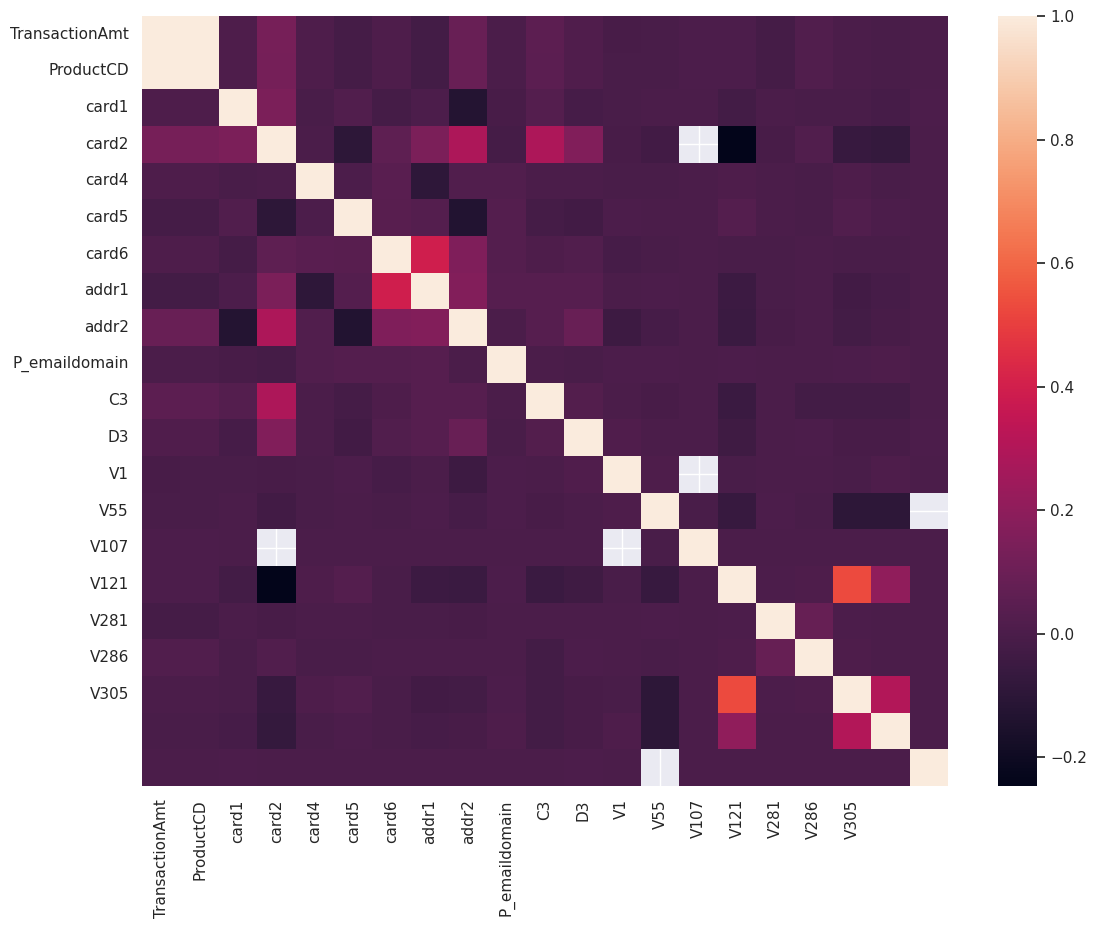

In [60]:
plt.figure(figsize=(13,10))
sns.heatmap(X_train.corr(), 
           xticklabels=X_train.columns[2:], 
           yticklabels=X_train.columns[2:])

Видим, что в датасете остались только слабо кореллированные признаки

### Посмотрим, есть ли в данных выбросы

Сперва отделим категориальные признаки от числовых

In [61]:
cat_feats = ['ProductCD', 'card1', 'card2', 'card4', 
             'card5', 'card6', 'addr1', 'addr2', 'P_emaildomain']
num_feats = [x for x in X_train.columns if x not in cat_feats]
print(f'cat_feats:\n {cat_feats}\n')
print(f'num_feats:\n {num_feats}')

cat_feats:
 ['ProductCD', 'card1', 'card2', 'card4', 'card5', 'card6', 'addr1', 'addr2', 'P_emaildomain']

num_feats:
 ['TransactionID', 'TransactionDT', 'TransactionAmt', 'C3', 'D3', 'V1', 'V55', 'V107', 'V121', 'V281', 'V286', 'V305']


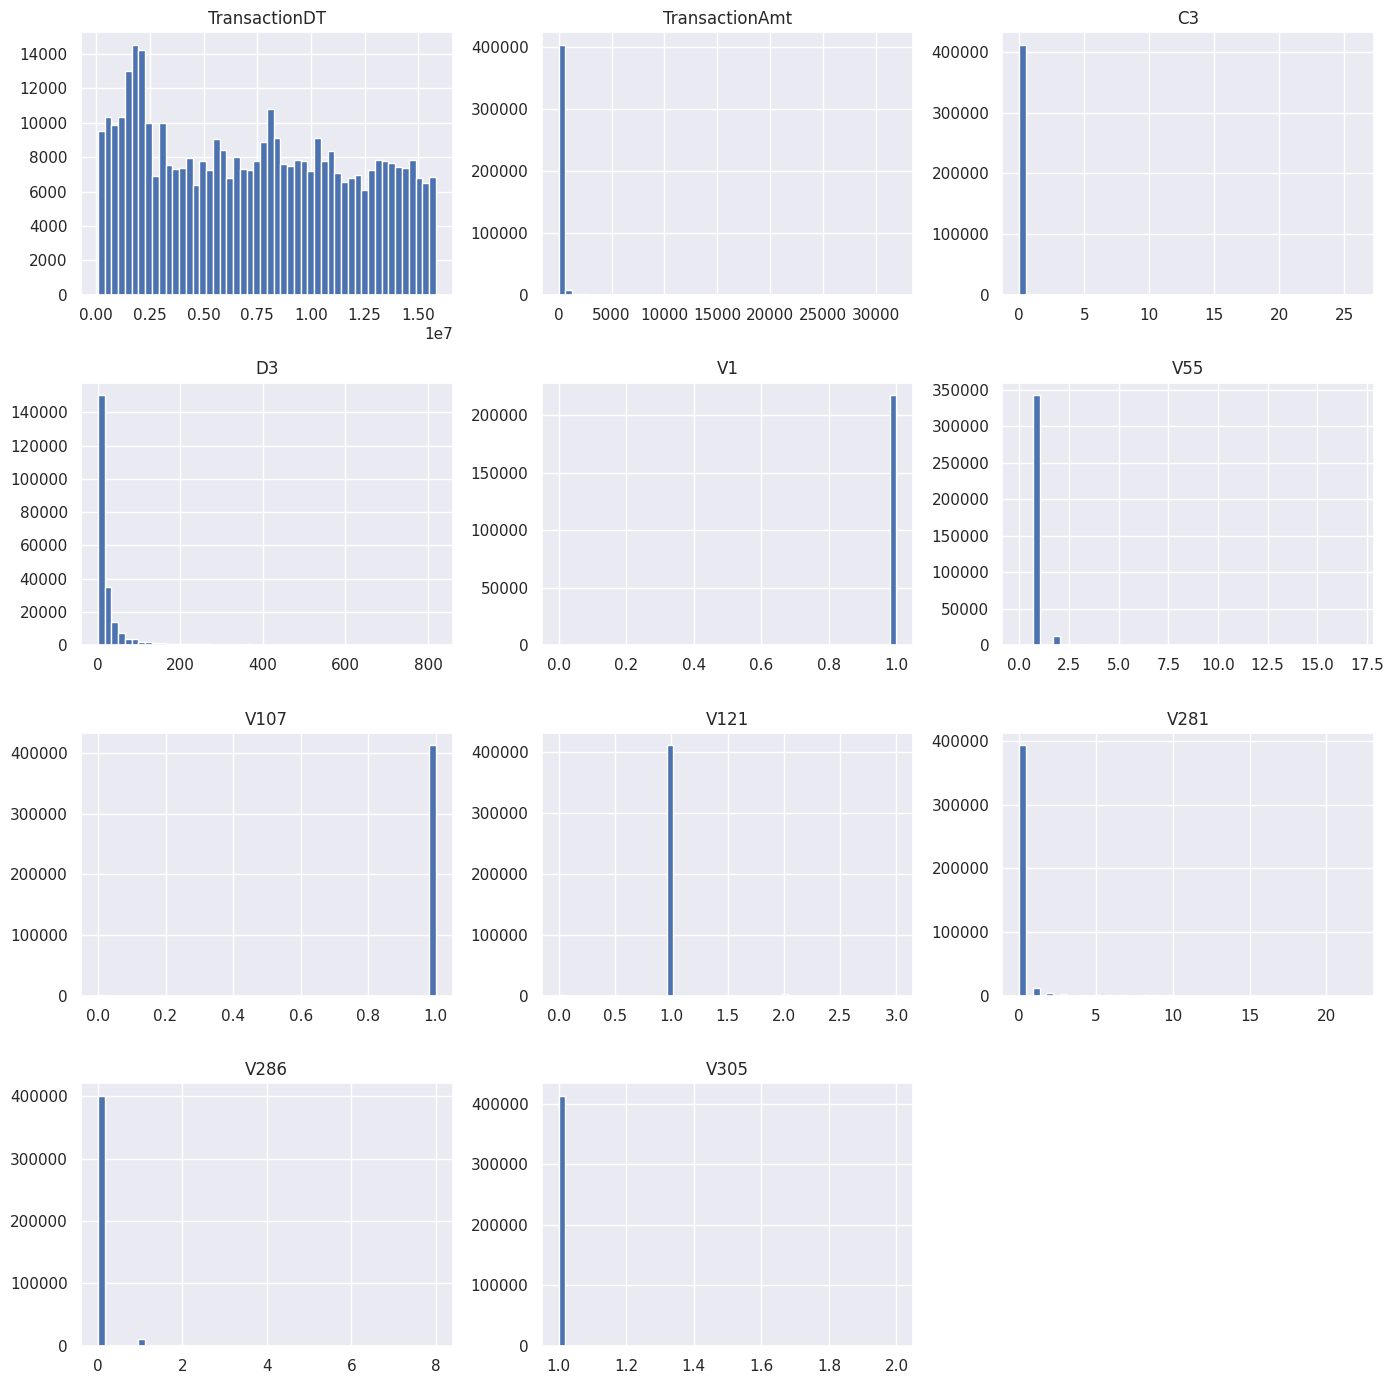

In [62]:
sns.set()
X_train[num_feats[1:]].hist(bins=50, figsize=(14,14))
plt.tight_layout()

Видим, что некоторые данные имеют выбросы. Посмотрим на графики ```boxplot```, чтобы явно убедиться в этом

In [63]:
def plt_boxplot(df, feature):
    sns.set()
    plt.figure(figsize=(10,3))
    sns.boxplot(x=df[feature])
    plt.title('Диаграмма размаха {}'.format(feature))
    plt.xlabel(feature)
    plt.show()

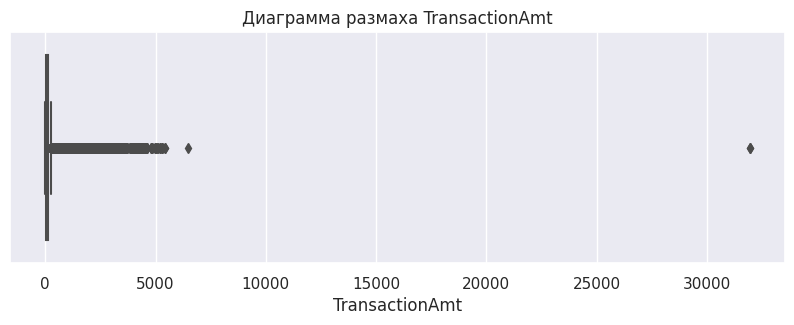

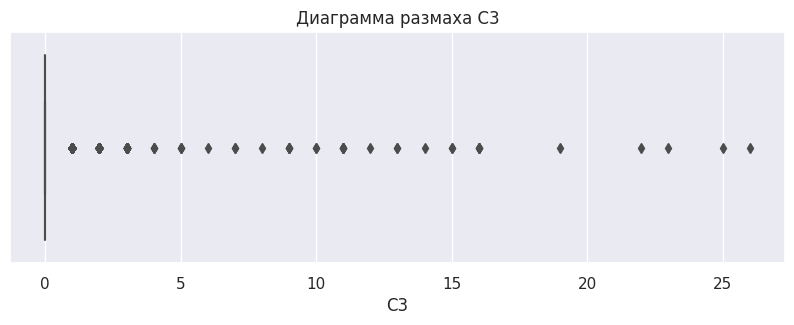

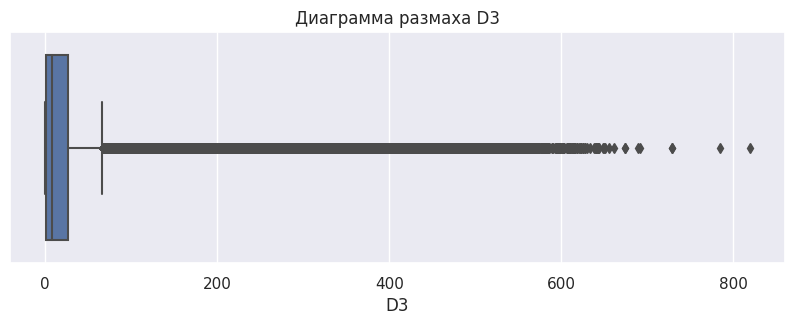

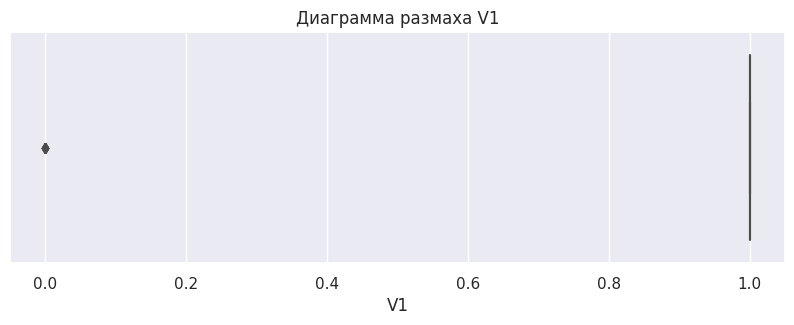

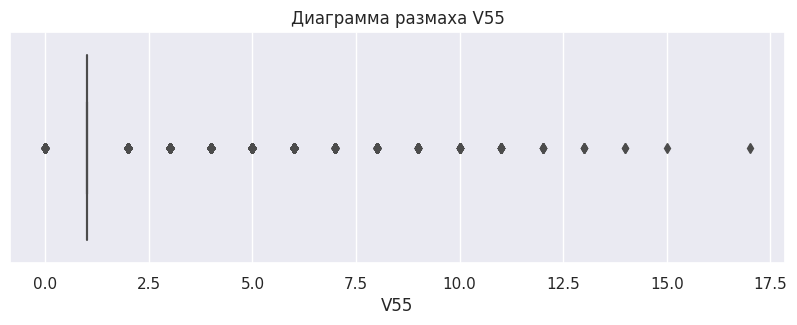

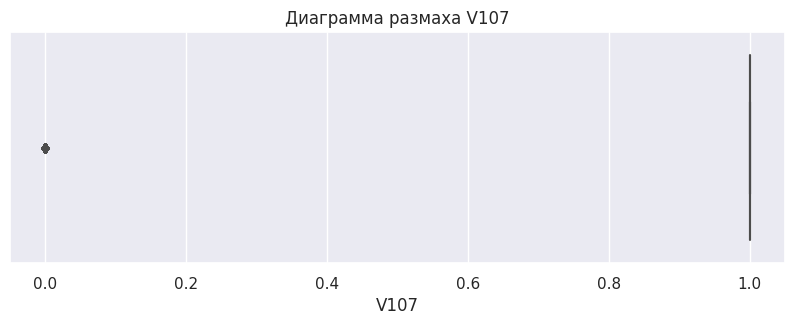

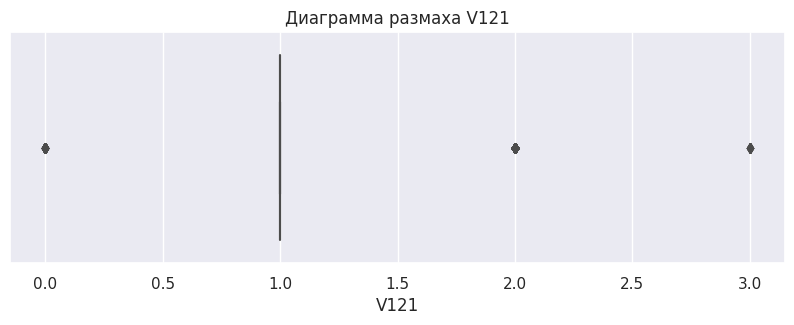

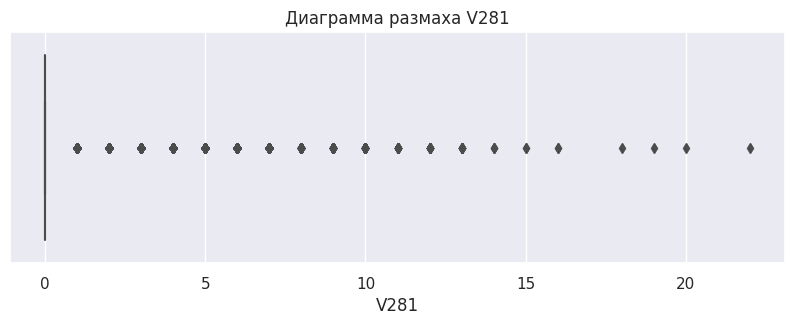

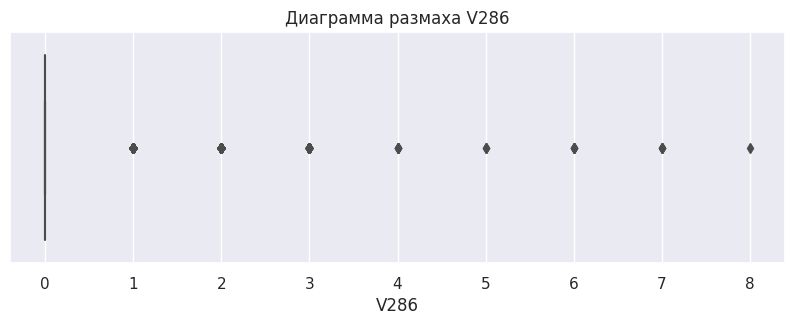

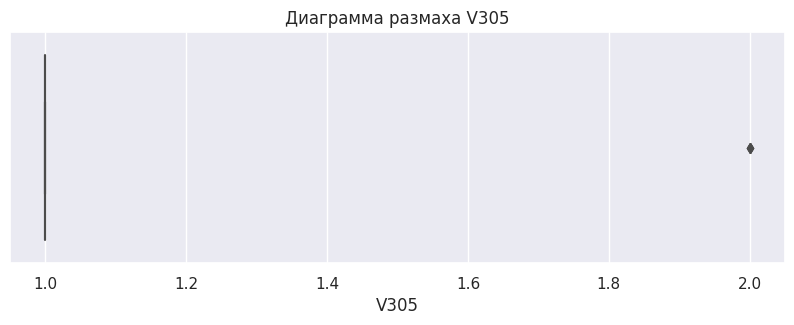

In [64]:
for feat in num_feats[2:]:
    plt_boxplot(X_train, feat)

Да, многие данные действительно имеют выбросы

### Посмотрим ещё раз на пропуски

In [65]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 413378 entries, 184962 to 16290
Data columns (total 21 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   TransactionID   413378 non-null  uint32 
 1   TransactionDT   413378 non-null  uint32 
 2   TransactionAmt  413378 non-null  float32
 3   ProductCD       413378 non-null  int64  
 4   card1           413378 non-null  uint16 
 5   card2           407146 non-null  float32
 6   card4           413378 non-null  int64  
 7   card5           410385 non-null  float32
 8   card6           413378 non-null  int64  
 9   addr1           367030 non-null  float32
 10  addr2           367030 non-null  float32
 11  P_emaildomain   413378 non-null  int64  
 12  C3              413378 non-null  float32
 13  D3              229110 non-null  float32
 14  V1              217545 non-null  float32
 15  V55             359451 non-null  float32
 16  V107            413170 non-null  float32
 17  V121       

In [66]:
X_train.isna().sum()

TransactionID          0
TransactionDT          0
TransactionAmt         0
ProductCD              0
card1                  0
card2               6232
card4                  0
card5               2993
card6                  0
addr1              46348
addr2              46348
P_emaildomain          0
C3                     0
D3                184268
V1                195833
V55                53927
V107                 208
V121                 208
V281                 902
V286                   8
V305                   8
dtype: int64

### Сперва заполним пропуски числовых признаков **средним** по колонке

Сделаем копии датасетов, чтобы ничего не поменять в исходниках

In [67]:
X_train_copy = X_train.copy()
X_valid_copy = X_valid.copy()
test_df_copy = test_df.copy()

In [68]:
num_feats

['TransactionID',
 'TransactionDT',
 'TransactionAmt',
 'C3',
 'D3',
 'V1',
 'V55',
 'V107',
 'V121',
 'V281',
 'V286',
 'V305']

In [69]:
X_train_copy[num_feats] = X_train_copy[num_feats].fillna(
    X_train_copy[num_feats].mean())

In [70]:
X_valid_copy[num_feats] = X_valid_copy[num_feats].fillna(
    X_valid_copy[num_feats].mean())

In [71]:
test_df_copy[num_feats] = test_df_copy[num_feats].fillna(
    test_df_copy[num_feats].mean())

Пропуски в категориальных прихнаках заполним константой ```-1```

In [72]:
X_train_copy[cat_feats] = X_train_copy[cat_feats].fillna(-1)
X_valid_copy[cat_feats] = X_valid_copy[cat_feats].fillna(-1)
test_df_copy[cat_feats] = test_df_copy[cat_feats].fillna(-1)

Проверки, остались ли пропуски в данных после заполнения

In [73]:
X_train_copy.isna().sum()

TransactionID     0
TransactionDT     0
TransactionAmt    0
ProductCD         0
card1             0
card2             0
card4             0
card5             0
card6             0
addr1             0
addr2             0
P_emaildomain     0
C3                0
D3                0
V1                0
V55               0
V107              0
V121              0
V281              0
V286              0
V305              0
dtype: int64

In [74]:
X_valid_copy.isna().sum()

TransactionID     0
TransactionDT     0
TransactionAmt    0
ProductCD         0
card1             0
card2             0
card4             0
card5             0
card6             0
addr1             0
addr2             0
P_emaildomain     0
C3                0
D3                0
V1                0
V55               0
V107              0
V121              0
V281              0
V286              0
V305              0
dtype: int64

In [75]:
test_df_copy.isna().sum()

TransactionID     0
TransactionDT     0
TransactionAmt    0
ProductCD         0
card1             0
card2             0
card4             0
card5             0
card6             0
addr1             0
addr2             0
P_emaildomain     0
C3                0
D3                0
V1                0
V55               0
V107              0
V121              0
V281              0
V286              0
V305              0
dtype: int64

#### Посмотрим на распределения признаков после заполнения пропусков

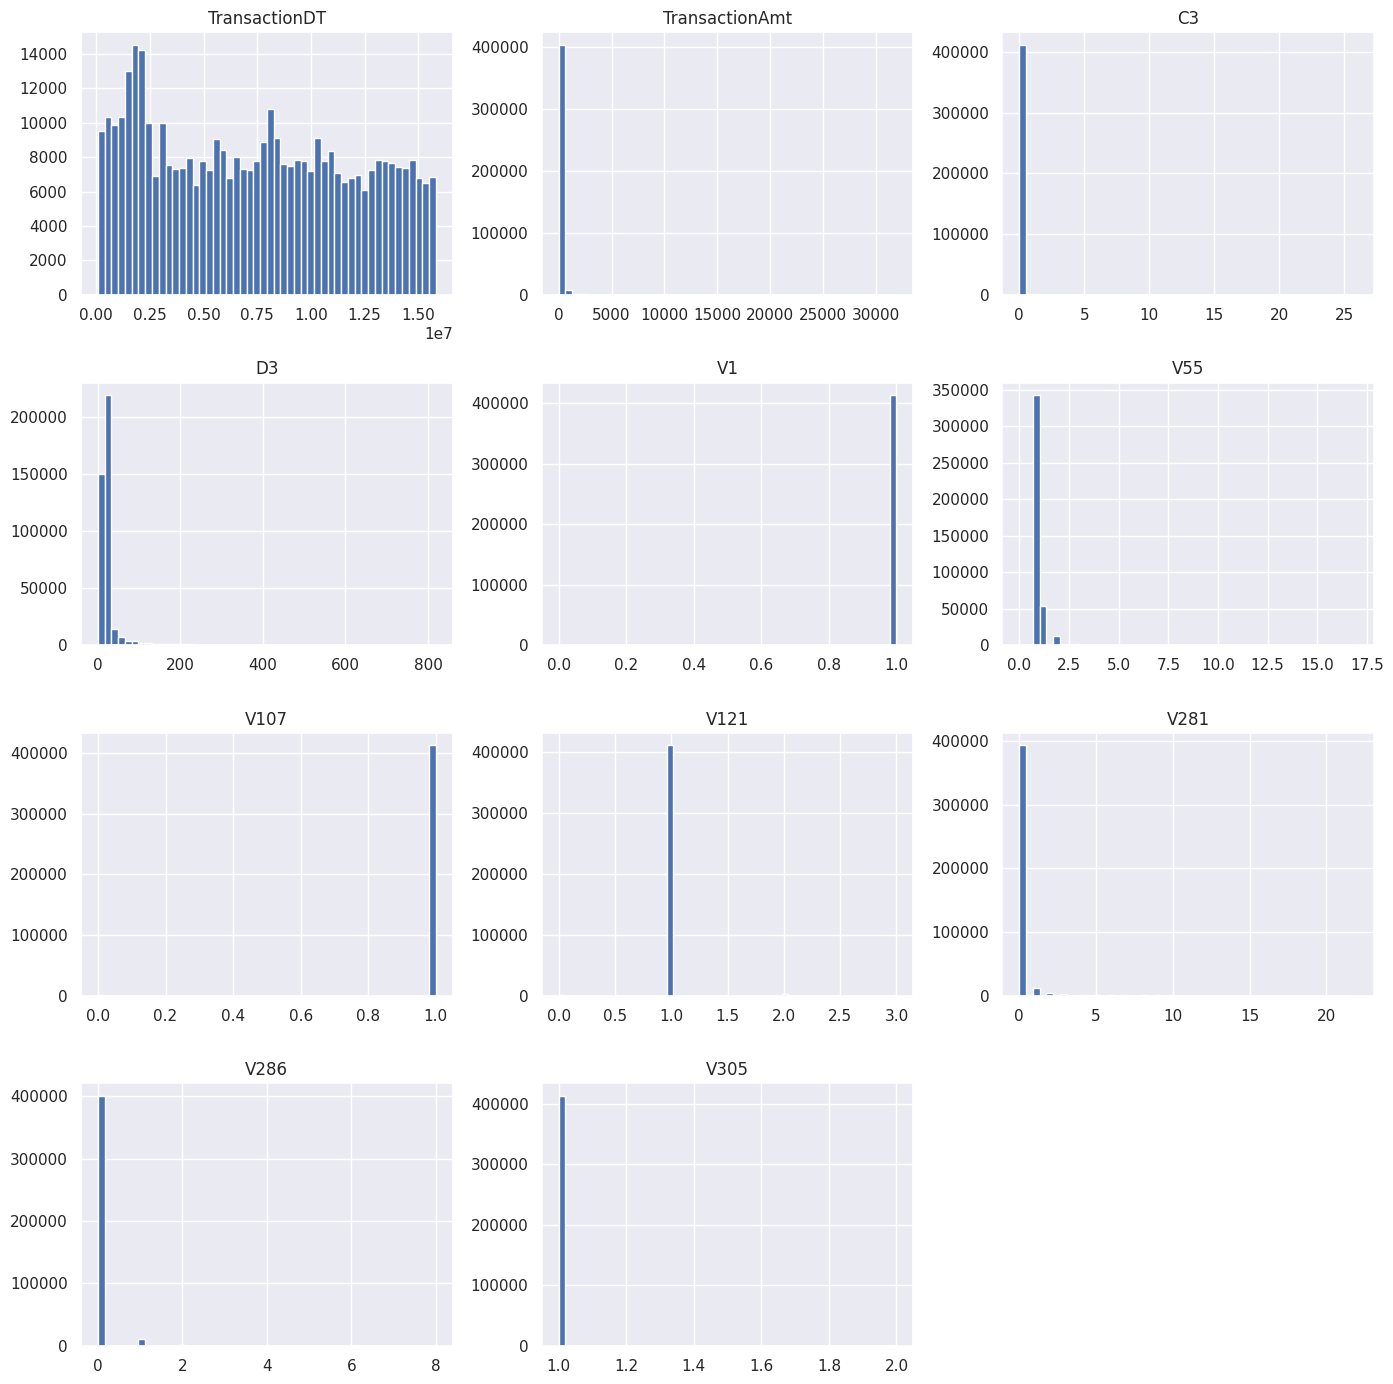

In [76]:
X_train_copy[num_feats[1:]].hist(bins=50, figsize=(14,14))
plt.tight_layout()

Видим, что распределения признаков после заполнения пропусков в целом не значительно изменились

#### Попробуем посмотреть на прогноз **логистической регрессии**

In [77]:
from sklearn.linear_model import LogisticRegression

In [78]:
model_LR = LogisticRegression()

model_LR.fit(X_train_copy, y_train)

LogisticRegression()

In [79]:
y_pred_valid_LR = model_LR.predict(X_valid_copy)

In [80]:
y_pred_valid_LR

array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)

In [81]:
print(f'Доля верно угаданных объектов {(y_pred_valid_LR == y_valid).sum() / len(y_valid)}')

Доля верно угаданных объектов 0.9650094264006954


Отличный результат, но это на валидационной выборке, и плюс распределение ответов в нашей выборке не сбалансировано

#### Посмотрим на **матрицу ошибок**

In [82]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

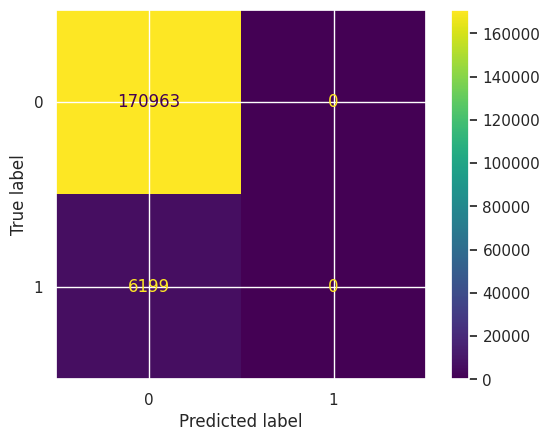

In [83]:
cm = confusion_matrix(y_valid, y_pred_valid_LR)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

#### Видим, что среди верных срабатываний не предсказано ни одного верного ответа

Посмотрим отчёт по метрикам классификации

In [84]:
print(classification_report(y_valid, y_pred_valid_LR))

              precision    recall  f1-score   support

           0       0.97      1.00      0.98    170963
           1       0.00      0.00      0.00      6199

    accuracy                           0.97    177162
   macro avg       0.48      0.50      0.49    177162
weighted avg       0.93      0.97      0.95    177162



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#### Это потому что в данных большой дисбаланс классов

Так как размеры датасетов достаточно большие, уберём часть данных класса с большей долей (валидные) из нашей выборки

In [85]:
X_train_copy

TransactionID  TransactionDT  TransactionAmt  ProductCD  card1  card2  \
184962        3171962        4120030       59.000000          4  16993  555.0   
510418        3497418       13368904       57.950001          4  18132  567.0   
121172        3108172        2388253       57.950001          4  16132  111.0   
461070        3448070       11841006      100.000000          1  10616  583.0   
329698        3316698        8110823       34.000000          4   9500  321.0   
...               ...            ...             ...        ...    ...    ...   
481831        3468831       12521063       67.949997          4   2803  100.0   
14141         3001141         406952      107.949997          4  16132  111.0   
158241        3145241        3292480       25.000000          4   7664  490.0   
195829        3182829        4403405      150.000000          2  10825  111.0   
16290         3003290         433915      100.598999          0  15146  311.0   

        card4  card5  card6  addr1  ...  P_emaildomain   C3         D3  \
184962      4  226.0      2  184.0  ...             16  0.0   6.000000   
510418      2  117.0      2  204.0  ...             16  0.0  10.000000   
121172      4  226.0      2  299.0  ...             16  0.0   7.000000   
461070      4  226.0      1  264.0  ...             23  0.0  28.323025   
329698      4  226.0      2  330.0  ...             30  0.0   1.000000   
...       ...    ...    ...    ...  ...            ...  ...        ...   
481831      4  226.0      2  184.0  ...             16  0.0  23.000000   
14141       4  226.0      2  299.0  ...             54  0.0  25.000000   
158241      4  226.0      2  315.0  ...             16  0.0  28.323025   
195829      4  195.0      1  204.0  ...              1  0.0  28.323025   
16290       4  102.0      1   -1.0  ...             16  0.0  28.323025   

              V1       V55  V107  V121  V281  V286  V305  
184962  0.999945  1.000000   1.0   1.0   0.0   0.0   1.0  
510418  1.000000  1.000000   1.0   1.0   0.0   0.0   1.0  
121172  0.999945  1.000000   1.0   1.0   0.0   0.0   1.0  
461070  0.999945  1.068257   1.0   1.0   0.0   0.0   1.0  
329698  1.000000  1.000000   1.0   1.0   0.0   0.0   1.0  
...          ...       ...   ...   ...   ...   ...   ...  
481831  1.000000  1.000000   1.0   1.0   0.0   0.0   1.0  
14141   1.000000  1.000000   1.0   1.0   0.0   0.0   1.0  
158241  0.999945  1.000000   1.0   1.0   0.0   0.0   1.0  
195829  0.999945  1.068257   1.0   1.0   0.0   0.0   1.0  
16290   0.999945  1.000000   1.0   1.0   0.0   0.0   1.0  

[413378 rows x 21 columns]

Мы помним, что распределение целевых меток в наших данных:
- валидные транзакции - ```96,5``` %
- мошеннические транзакции - ```3,5``` %

Попробуем убрать число копий мошеннических транзакций так, чтобы соотношение классов стало равным ```70```% (валидные) к ```30``` % (мошеннические)

Посчитаем сколько записей транзакций от **общего размера обучающей выборки** составляют ```70``` %:

In [86]:
num_y_train_70_prct = len(y_train) * 0.7
int(num_y_train_70_prct)

289364

Посмотрим сколько записей **валидных транзакций** надо удалить из обучающего датасета, чтобы соотношение долей ответов стало 70 к 30:

- num_trxs       - 100 %
- num_valid_trxs - 70 %
- num_fraud_trxs - 30%

In [87]:
not_fraud_trxs_count = len(y_train[y_train==0])
fraud_trxs_count = len(y_train[y_train==1])
# посмотрим какое общее число транзакций должно быть, 
# чтобы мы смогли достичь нужного соотношения
balanced_trxs_count = int(fraud_trxs_count * 100 / 30)
print('not_fraud_trxs_count: ', not_fraud_trxs_count)
print('fraud_trxs_count: ', fraud_trxs_count)
print('balanced_trxs_count: ', balanced_trxs_count)

not_fraud_trxs_count:  398914
fraud_trxs_count:  14464
balanced_trxs_count:  48213


Видим, что **сбалансированое кол-во транзакций было бы - 48213**, но мы не можем сократить число транзакций до такого кол-ва, т.к. данных останется слишком мало, что плохо скажется на прогнозах по тестовым данным

Поэтому необходимо **добавить** необходимое число копий **мошеннических транзакций** в датасеты

In [88]:
trxs_count = len(y_train)
opt_fraud_trxs_count = int(trxs_count * 30 / 100)
print('optimal fraud trxs count: ', opt_fraud_trxs_count)

optimal fraud trxs count:  124013


Посчитаем насколько копий нужно увеличить кол-во мошеннических записей

In [89]:
diff_fraud_trxs_count = opt_fraud_trxs_count - fraud_trxs_count
diff_fraud_trxs_count

109549

Нужно добавить **109549** записей класса 1

In [90]:
int(opt_fraud_trxs_count / fraud_trxs_count)

8

#### т.е. увеличим число мошеннических транзакций примерно в 8 раз

In [91]:
y_train_fraud_increased = pd.concat([y_train[y_train==1] for i in range(7)])
y_train_fraud_increased

365367    1
559220    1
464517    1
508892    1
406135    1
         ..
229182    1
66399     1
276627    1
683       1
131836    1
Name: isFraud, Length: 101248, dtype: uint8

In [92]:
y_train_increased = pd.concat([y_train, y_train_fraud_increased])
y_train_increased

184962    0
510418    0
121172    0
461070    0
329698    0
         ..
229182    1
66399     1
276627    1
683       1
131836    1
Name: isFraud, Length: 514626, dtype: uint8

Посмотрим теперь на соотношение ответов

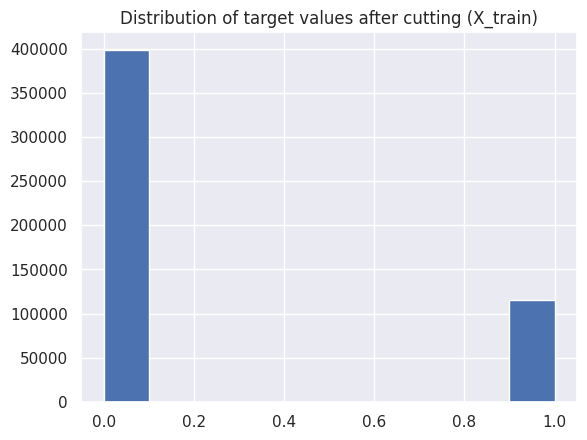

In [93]:
plt.hist(y_train_increased)
plt.title('Distribution of target values after cutting (X_train)')
plt.show()

Видим, как поменялось соотношение ответов

Увеличим кол-во соответствующих данных в датасете ```X_train```

In [94]:
before_inc = y_train[y_train==1].index
before_inc

Index([365367, 559220, 464517, 508892, 406135,   7012, 167797, 268378,  67750,
       460255,
       ...
       295938, 213875,  54505, 107087, 178651, 229182,  66399, 276627,    683,
       131836],
      dtype='int64', length=14464)

In [95]:
y_train_indexes = list(y_train_increased[y_train_increased==1].index[len(before_inc):])
len(y_train_indexes)

101248

In [96]:
X_train_increased = pd.concat([X_train, X_train.loc[y_train_indexes]])
X_train_increased

TransactionID  TransactionDT  TransactionAmt  ProductCD  card1  card2  \
184962        3171962        4120030       59.000000          4  16993  555.0   
510418        3497418       13368904       57.950001          4  18132  567.0   
121172        3108172        2388253       57.950001          4  16132  111.0   
461070        3448070       11841006      100.000000          1  10616  583.0   
329698        3316698        8110823       34.000000          4   9500  321.0   
...               ...            ...             ...        ...    ...    ...   
229182        3216182        5431060       19.093000          0  10568  204.0   
66399         3053399        1492562       15.000000          1   7585  553.0   
276627        3263627        6725844       10.151000          0  13832  375.0   
683           2987683          99584      124.344002          0   5812  408.0   
131836        3118836        2609990      141.000000          4   7919  194.0   

        card4  card5  card6  addr1  ...  P_emaildomain   C3     D3   V1  V55  \
184962      4  226.0      2  184.0  ...             16  0.0    6.0  NaN  1.0   
510418      2  117.0      2  204.0  ...             16  0.0   10.0  1.0  1.0   
121172      4  226.0      2  299.0  ...             16  0.0    7.0  NaN  1.0   
461070      4  226.0      1  264.0  ...             23  0.0    NaN  NaN  NaN   
329698      4  226.0      2  330.0  ...             30  0.0    1.0  1.0  1.0   
...       ...    ...    ...    ...  ...            ...  ...    ...  ...  ...   
229182      4  226.0      1    NaN  ...             16  0.0  284.0  NaN  1.0   
66399       4  226.0      1  337.0  ...              9  0.0    NaN  NaN  NaN   
276627      2  224.0      2    NaN  ...             19  0.0    0.0  NaN  1.0   
683         2  224.0      2    NaN  ...             16  0.0    0.0  NaN  1.0   
131836      2  202.0      2  469.0  ...             16  0.0    0.0  NaN  1.0   

        V107  V121  V281  V286  V305  
184962   1.0   1.0   0.0   0.0   1.0  
510418   1.0   1.0   0.0   0.0   1.0  
121172   1.0   1.0   0.0   0.0   1.0  
461070   1.0   1.0   0.0   0.0   1.0  
329698   1.0   1.0   0.0   0.0   1.0  
...      ...   ...   ...   ...   ...  
229182   1.0   1.0   0.0   0.0   1.0  
66399    1.0   1.0   0.0   0.0   1.0  
276627   1.0   1.0   0.0   0.0   1.0  
683      1.0   1.0   0.0   1.0   1.0  
131836   1.0   1.0   0.0   1.0   1.0  

[514626 rows x 21 columns]

In [97]:
y_train_increased.shape

(514626,)

In [98]:
X_train_increased.shape

(514626, 21)

In [99]:
X_train_increased.isna().sum()

TransactionID          0
TransactionDT          0
TransactionAmt         0
ProductCD              0
card1                  0
card2               8269
card4                  0
card5               4078
card6                  0
addr1              84379
addr2              84379
P_emaildomain          0
C3                     0
D3                238644
V1                267366
V55                76285
V107                 271
V121                 271
V281                1112
V286                  22
V305                  22
dtype: int64

Снова заполним пропуски в данных:
- числовые признаки средними значениями по столбцам
- категориальные - ```-1```

In [100]:
X_train_increased[num_feats] = X_train_increased[num_feats].fillna(
    X_train_increased[num_feats].mean())

In [101]:
X_train_increased[cat_feats] = X_train_increased[cat_feats].fillna(-1)

In [102]:
X_train_increased.isna().sum()

TransactionID     0
TransactionDT     0
TransactionAmt    0
ProductCD         0
card1             0
card2             0
card4             0
card5             0
card6             0
addr1             0
addr2             0
P_emaildomain     0
C3                0
D3                0
V1                0
V55               0
V107              0
V121              0
V281              0
V286              0
V305              0
dtype: int64

### Проделаем вышеперечисленные действия с увеличением доли **мошеннических записей** для валидационного датасета

In [103]:
y_valid_fraud_increased = pd.concat([y_valid[y_valid==1] for i in range(7)])
y_valid_fraud_increased

314886    1
304115    1
275756    1
410121    1
55638     1
         ..
535395    1
60029     1
189313    1
171291    1
578388    1
Name: isFraud, Length: 43393, dtype: uint8

In [104]:
y_valid_increased = pd.concat([y_valid, y_valid_fraud_increased])
y_valid_increased

587423    0
268070    0
85582     0
544807    0
571901    0
         ..
535395    1
60029     1
189313    1
171291    1
578388    1
Name: isFraud, Length: 220555, dtype: uint8

Посмотрим на соотношение ответов валидационного датасета

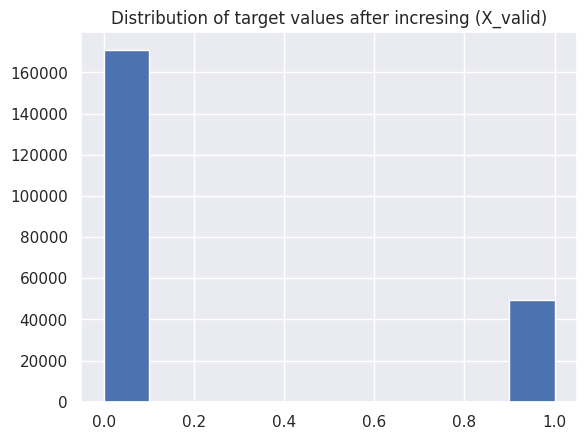

In [105]:
plt.hist(y_valid_increased)
plt.title('Distribution of target values after incresing (X_valid)')
plt.show()

In [106]:
before_inc = y_valid[y_valid==1].index
y_valid_indexes = list(y_valid_increased[y_valid_increased==1].index[len(before_inc):])
X_valid_increased = pd.concat([X_valid, X_valid.loc[y_valid_indexes]])
X_valid_increased

TransactionID  TransactionDT  TransactionAmt  ProductCD  card1  card2  \
587423        3574423       15718014      117.000000          4  12577  268.0   
268070        3255070        6483262      280.000000          4   7427  543.0   
85582         3072582        1809527       41.042999          0  10876  104.0   
544807        3531807       14387583       57.950001          4  16232  396.0   
571901        3558901       15190040      390.000000          4  16075  514.0   
...               ...            ...             ...        ...    ...    ...   
535395        3522395       14089849       19.059000          0  10568  204.0   
60029         3047029        1371206       25.535000          0   8755  500.0   
189313        3176313        4227653       29.000000          4   4693  417.0   
171291        3158291        3701910      117.000000          4  15066  170.0   
578388        3565388       15384920       14.219000          0   2650  142.0   

        card4  card5  card6  addr1  ...  P_emaildomain   C3     D3   V1  V55  \
587423      4  166.0      2  476.0  ...             16  0.0    1.0  1.0  1.0   
268070      2  224.0      2  143.0  ...             16  0.0   12.0  NaN  2.0   
85582       4  137.0      1    NaN  ...             19  0.0    0.0  NaN  3.0   
544807      2  224.0      2  315.0  ...             16  0.0  522.0  NaN  1.0   
571901      2  102.0      1  315.0  ...             19  0.0    NaN  1.0  1.0   
...       ...    ...    ...    ...  ...            ...  ...    ...  ...  ...   
535395      4  226.0      1    NaN  ...             16  0.0    NaN  NaN  NaN   
60029       2  224.0      1    NaN  ...             16  0.0    3.0  NaN  1.0   
189313      4  195.0      2  308.0  ...             54  0.0    0.0  NaN  2.0   
171291      2  102.0      1  330.0  ...              9  0.0    1.0  NaN  1.0   
578388      2  224.0      2    NaN  ...             16  0.0    0.0  NaN  3.0   

        V107  V121  V281  V286  V305  
587423   1.0   1.0   0.0   0.0   1.0  
268070   1.0   1.0   0.0   0.0   1.0  
85582    1.0   1.0   0.0   0.0   1.0  
544807   1.0   1.0   0.0   0.0   1.0  
571901   1.0   1.0   0.0   0.0   1.0  
...      ...   ...   ...   ...   ...  
535395   1.0   1.0   1.0   1.0   1.0  
60029    1.0   1.0   0.0   0.0   1.0  
189313   1.0   1.0   0.0   0.0   1.0  
171291   1.0   1.0   0.0   0.0   1.0  
578388   1.0   1.0   1.0   1.0   1.0  

[220555 rows x 21 columns]

In [107]:
y_valid_increased.shape

(220555,)

In [108]:
X_valid_increased.shape

(220555, 21)

Заполним пропуски в валидационном датасете

In [109]:
X_valid_increased.isna().sum()

TransactionID          0
TransactionDT          0
TransactionAmt         0
ProductCD              0
card1                  0
card2               3625
card4                  0
card5               1651
card6                  0
addr1              35514
addr2              35514
P_emaildomain          0
C3                     0
D3                101542
V1                113820
V55                32374
V107                 162
V121                 162
V281                 479
V286                   4
V305                   4
dtype: int64

In [110]:
X_valid_increased[num_feats] = X_valid_increased[num_feats].fillna(
    X_valid_increased[num_feats].mean())

In [111]:
X_valid_increased[cat_feats] = X_valid_increased[cat_feats].fillna(-1)

In [112]:
X_valid_increased.isna().sum()

TransactionID     0
TransactionDT     0
TransactionAmt    0
ProductCD         0
card1             0
card2             0
card4             0
card5             0
card6             0
addr1             0
addr2             0
P_emaildomain     0
C3                0
D3                0
V1                0
V55               0
V107              0
V121              0
V281              0
V286              0
V305              0
dtype: int64

#### После добавления данных в датасеты посмотрим снова на прогноз модели логистической регрессии:

In [113]:
model_LR2 = LogisticRegression()
model_LR2.fit(X_train_increased, y_train_increased)

LogisticRegression()

In [114]:
y_pred_valid_LR2 = model_LR2.predict(X_valid_increased)

In [115]:
print(f'Доля верно угаданных объектов {(y_pred_valid_LR2 == y_valid_increased).sum()/len(y_valid_increased)}')

Доля верно угаданных объектов 0.7751490557910725


Видим, что качество прогнозов ухудшилось. Посмотрим на матрицу ошибок и отчёт классификации

Напишем функцию для построения матрицы ошибок:

In [116]:
def conf_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.show()

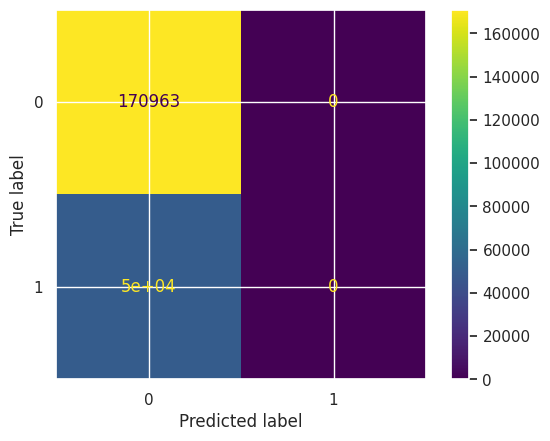

In [117]:
conf_matrix(y_valid_increased, y_pred_valid_LR2)

In [118]:
print(classification_report(y_valid_increased, y_pred_valid_LR2))

              precision    recall  f1-score   support

           0       0.78      1.00      0.87    170963
           1       0.00      0.00      0.00     49592

    accuracy                           0.78    220555
   macro avg       0.39      0.50      0.44    220555
weighted avg       0.60      0.78      0.68    220555



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Попробуем сделать прогноз на исходной выборке ```X_valid_copy``` с дисбалансом в данных

In [119]:
y_pred_valid_LR2 = model_LR2.predict(X_valid_copy)

In [120]:
print(f'Доля верно угаданных объектов {(y_pred_valid_LR2 == y_valid).sum()/len(y_valid)}')

Доля верно угаданных объектов 0.9650094264006954


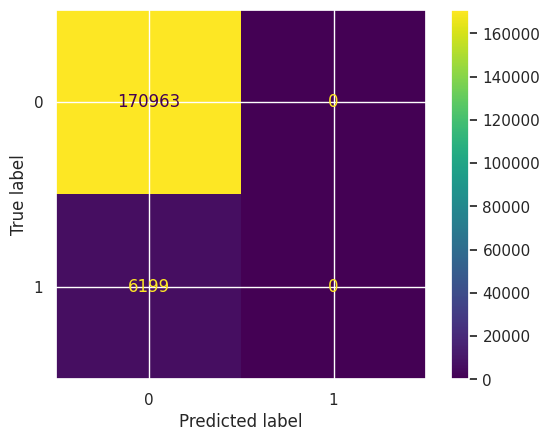

In [121]:
conf_matrix(y_valid, y_pred_valid_LR2)

In [122]:
print(classification_report(y_valid, y_pred_valid_LR2))

              precision    recall  f1-score   support

           0       0.97      1.00      0.98    170963
           1       0.00      0.00      0.00      6199

    accuracy                           0.97    177162
   macro avg       0.48      0.50      0.49    177162
weighted avg       0.93      0.97      0.95    177162



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Видим, что доля верно предсказанных значений мошеннических транзакций пока не увеличилась

#### Попробуем сбалансировать значения двух выборок 50 на 50. Уменьшим кол-во записей в датасете с классом 0

In [123]:
opt_fraud_trxs_count

124013

In [124]:
not_fraud_trxs_count

398914

In [125]:
balanced_y_train_0 = y_train[y_train==0][:opt_fraud_trxs_count]
balanced_y_train_0

184962    0
510418    0
121172    0
461070    0
329698    0
         ..
233856    0
504781    0
104594    0
239640    0
96952     0
Name: isFraud, Length: 124013, dtype: uint8

In [126]:
y_train_fraud_increased = pd.concat([y_train[y_train==1] for i in range(8)])
y_train_fraud_increased

365367    1
559220    1
464517    1
508892    1
406135    1
         ..
229182    1
66399     1
276627    1
683       1
131836    1
Name: isFraud, Length: 115712, dtype: uint8

In [127]:
y_train_balanced = pd.concat([balanced_y_train_0, y_train_fraud_increased])
y_train_balanced

184962    0
510418    0
121172    0
461070    0
329698    0
         ..
229182    1
66399     1
276627    1
683       1
131836    1
Name: isFraud, Length: 239725, dtype: uint8

Посмотрим теперь на соотношение ответов

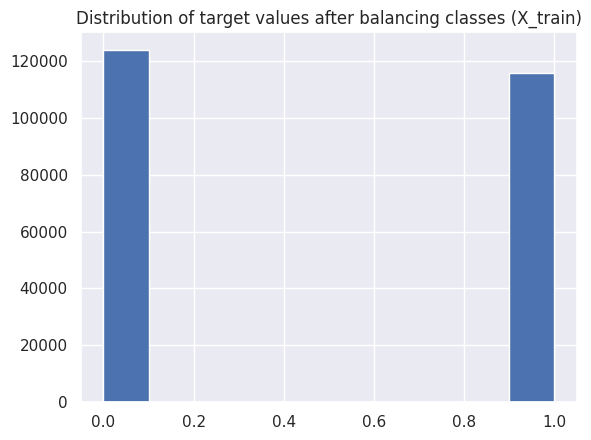

In [128]:
plt.hist(y_train_balanced)
plt.title('Distribution of target values after balancing classes (X_train)')
plt.show()

In [129]:
y_train_balanced.shape

(239725,)

In [130]:
X_train_balanced = X_train_copy.loc[y_train_balanced.index]

In [131]:
X_train_balanced.shape

(239725, 21)

In [132]:
test_df.shape

(506691, 21)

In [133]:
model_LR4 = LogisticRegression()
model_LR4.fit(X_train_balanced, y_train_balanced)

LogisticRegression()

In [134]:
y_pred_valid_LR4 = model_LR4.predict(X_valid_copy)

In [135]:
print(f'Доля верно угаданных объектов {(y_pred_valid_LR4 == y_valid).sum() / len(y_valid)}')

Доля верно угаданных объектов 0.760281550219573


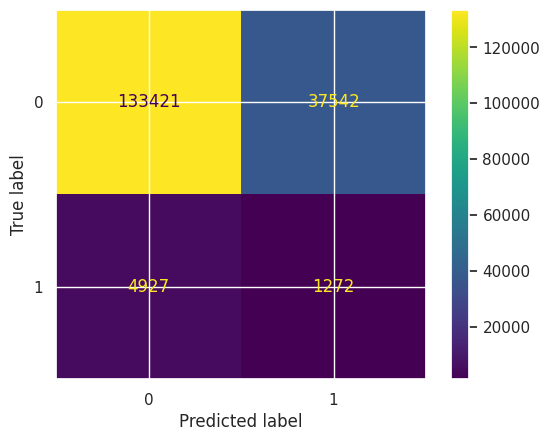

In [136]:
conf_matrix(y_valid, y_pred_valid_LR4)

In [137]:
print(classification_report(y_valid, y_pred_valid_LR4))

              precision    recall  f1-score   support

           0       0.96      0.78      0.86    170963
           1       0.03      0.21      0.06      6199

    accuracy                           0.76    177162
   macro avg       0.50      0.49      0.46    177162
weighted avg       0.93      0.76      0.83    177162



Видим, что качество после уравнивания долей ответов обоих классов по прежнему остаётся не очень хорошим, хоть и полнота для класса 1 выросла

#### Так как линейные модели чувствительны к порядкам признаков, необходимо произвести **масштабирование признаков**

In [138]:
from sklearn.preprocessing import StandardScaler

Уберём из датасетов признак ```TransactionID```. Но сохраним этот признак в отдельную переменную для тестовой выборки - это нужно для отправки данных на соревнование

In [139]:
X_train_balanced2 = X_train_balanced.drop(columns=['TransactionID'])
X_train_balanced2

TransactionDT  TransactionAmt  ProductCD  card1  card2  card4  card5  \
184962        4120030       59.000000          4  16993  555.0      4  226.0   
510418       13368904       57.950001          4  18132  567.0      2  117.0   
121172        2388253       57.950001          4  16132  111.0      4  226.0   
461070       11841006      100.000000          1  10616  583.0      4  226.0   
329698        8110823       34.000000          4   9500  321.0      4  226.0   
...               ...             ...        ...    ...    ...    ...    ...   
229182        5431060       19.093000          0  10568  204.0      4  226.0   
66399         1492562       15.000000          1   7585  553.0      4  226.0   
276627        6725844       10.151000          0  13832  375.0      2  224.0   
683             99584      124.344002          0   5812  408.0      2  224.0   
131836        2609990      141.000000          4   7919  194.0      2  202.0   

        card6  addr1  addr2  P_emaildomain   C3          D3        V1  \
184962      2  184.0   87.0             16  0.0    6.000000  0.999945   
510418      2  204.0   87.0             16  0.0   10.000000  1.000000   
121172      2  299.0   87.0             16  0.0    7.000000  0.999945   
461070      1  264.0   87.0             23  0.0   28.323025  0.999945   
329698      2  330.0   87.0             30  0.0    1.000000  1.000000   
...       ...    ...    ...            ...  ...         ...       ...   
229182      1   -1.0   -1.0             16  0.0  284.000000  0.999945   
66399       1  337.0   87.0              9  0.0   28.323025  0.999945   
276627      2   -1.0   -1.0             19  0.0    0.000000  0.999945   
683         2   -1.0   -1.0             16  0.0    0.000000  0.999945   
131836      2  469.0   87.0             16  0.0    0.000000  0.999945   

             V55  V107  V121  V281  V286  V305  
184962  1.000000   1.0   1.0   0.0   0.0   1.0  
510418  1.000000   1.0   1.0   0.0   0.0   1.0  
121172  1.000000   1.0   1.0   0.0   0.0   1.0  
461070  1.068257   1.0   1.0   0.0   0.0   1.0  
329698  1.000000   1.0   1.0   0.0   0.0   1.0  
...          ...   ...   ...   ...   ...   ...  
229182  1.000000   1.0   1.0   0.0   0.0   1.0  
66399   1.068257   1.0   1.0   0.0   0.0   1.0  
276627  1.000000   1.0   1.0   0.0   0.0   1.0  
683     1.000000   1.0   1.0   0.0   1.0   1.0  
131836  1.000000   1.0   1.0   0.0   1.0   1.0  

[239725 rows x 20 columns]

In [140]:
X_valid_copy2 = X_valid_copy.drop(columns=['TransactionID'])
X_valid_copy2

TransactionDT  TransactionAmt  ProductCD  card1  card2  card4  card5  \
587423       15718014      117.000000          4  12577  268.0      4  166.0   
268070        6483262      280.000000          4   7427  543.0      2  224.0   
85582         1809527       41.042999          0  10876  104.0      4  137.0   
544807       14387583       57.950001          4  16232  396.0      2  224.0   
571901       15190040      390.000000          4  16075  514.0      2  102.0   
...               ...             ...        ...    ...    ...    ...    ...   
30610          765815      150.000000          2  12827  555.0      4  102.0   
207146        4757113      112.989998          4   6344  327.0      1  166.0   
393770        9902240      160.500000          4  12308  360.0      4  166.0   
362875        8992448      151.000000          4   4971  225.0      2  117.0   
121325        2390627      294.950012          4  13053  302.0      4  226.0   

        card6  addr1  addr2  P_emaildomain   C3          D3        V1  \
587423      2  476.0   87.0             16  0.0    1.000000  1.000000   
268070      2  143.0   87.0             16  0.0   12.000000  0.999947   
85582       1   -1.0   -1.0             19  0.0    0.000000  0.999947   
544807      2  315.0   87.0             16  0.0  522.000000  0.999947   
571901      1  315.0   87.0             19  0.0   28.390596  1.000000   
...       ...    ...    ...            ...  ...         ...       ...   
30610       1  536.0   96.0             16  0.0   28.390596  0.999947   
207146      2  325.0   87.0             54  0.0   28.390596  0.999947   
393770      2  191.0   87.0             19  0.0   28.390596  0.999947   
362875      2  299.0   87.0             54  0.0   28.390596  1.000000   
121325      2  337.0   87.0             54  0.0   57.000000  0.999947   

             V55  V107  V121  V281  V286  V305  
587423  1.000000   1.0   1.0   0.0   0.0   1.0  
268070  2.000000   1.0   1.0   0.0   0.0   1.0  
85582   3.000000   1.0   1.0   0.0   0.0   1.0  
544807  1.000000   1.0   1.0   0.0   0.0   1.0  
571901  1.000000   1.0   1.0   0.0   0.0   1.0  
...          ...   ...   ...   ...   ...   ...  
30610   1.066302   1.0   1.0   0.0   0.0   1.0  
207146  1.000000   1.0   1.0   0.0   0.0   1.0  
393770  1.000000   1.0   1.0   0.0   0.0   1.0  
362875  1.000000   1.0   1.0   0.0   0.0   1.0  
121325  1.000000   1.0   1.0   0.0   0.0   1.0  

[177162 rows x 20 columns]

In [141]:
transactionIDs_test = test_df_copy['TransactionID']
test_df_copy = test_df_copy.drop(columns=['TransactionID'])
test_df_copy

TransactionDT  TransactionAmt  ProductCD  card1  card2  card4  card5  \
0            18403224       31.950001          4  10409  111.0      4  226.0   
1            18403263       49.000000          4   4272  111.0      4  226.0   
2            18403310      171.000000          4   4476  574.0      4  226.0   
3            18403310      284.950012          4  10989  360.0      4  166.0   
4            18403317       67.949997          4  18018  452.0      2  117.0   
...               ...             ...        ...    ...    ...    ...    ...   
506686       34214279       94.679001          0  13832  375.0      2  224.0   
506687       34214287       12.173000          0   3154  408.0      2  224.0   
506688       34214326       49.000000          4  16661  490.0      4  226.0   
506689       34214337      202.000000          4  16621  516.0      2  224.0   
506690       34214345       24.346001          0   5713  168.0      4  147.0   

        card6  addr1  addr2  P_emaildomain   C3         D3        V1  V55  \
0           2  170.0   87.0             16  0.0  27.000000  1.000000  1.0   
1           2  299.0   87.0              2  0.0   7.000000  1.000000  1.0   
2           2  472.0   87.0             19  0.0  10.000000  1.000000  1.0   
3           2  205.0   87.0             16  0.0  41.000000  1.000000  1.0   
4           2  264.0   87.0             16  0.0   0.000000  1.000000  1.0   
...       ...    ...    ...            ...  ...        ...       ...  ...   
506686      2  284.0   60.0             16  0.0  33.394726  0.999997  1.0   
506687      2   -1.0   -1.0             19  0.0  16.000000  0.999997  2.0   
506688      2  327.0   87.0             19  0.0  33.394726  1.000000  1.0   
506689      2  177.0   87.0             19  0.0  33.394726  1.000000  1.0   
506690      1   -1.0   -1.0             19  0.0  33.394726  0.999997  1.0   

        V107  V121  V281  V286  V305  
0        1.0   1.0   0.0   0.0   1.0  
1        1.0   1.0   0.0   0.0   1.0  
2        1.0   1.0   0.0   0.0   1.0  
3        1.0   1.0   0.0   0.0   1.0  
4        1.0   1.0   0.0   1.0   1.0  
...      ...   ...   ...   ...   ...  
506686   1.0   1.0   0.0   0.0   1.0  
506687   1.0   1.0   1.0   0.0   1.0  
506688   1.0   1.0   0.0   0.0   1.0  
506689   1.0   1.0   0.0   0.0   1.0  
506690   1.0   1.0   0.0   0.0   1.0  

[506691 rows x 20 columns]

In [142]:
test_df_copy

TransactionDT  TransactionAmt  ProductCD  card1  card2  card4  card5  \
0            18403224       31.950001          4  10409  111.0      4  226.0   
1            18403263       49.000000          4   4272  111.0      4  226.0   
2            18403310      171.000000          4   4476  574.0      4  226.0   
3            18403310      284.950012          4  10989  360.0      4  166.0   
4            18403317       67.949997          4  18018  452.0      2  117.0   
...               ...             ...        ...    ...    ...    ...    ...   
506686       34214279       94.679001          0  13832  375.0      2  224.0   
506687       34214287       12.173000          0   3154  408.0      2  224.0   
506688       34214326       49.000000          4  16661  490.0      4  226.0   
506689       34214337      202.000000          4  16621  516.0      2  224.0   
506690       34214345       24.346001          0   5713  168.0      4  147.0   

        card6  addr1  addr2  P_emaildomain   C3         D3        V1  V55  \
0           2  170.0   87.0             16  0.0  27.000000  1.000000  1.0   
1           2  299.0   87.0              2  0.0   7.000000  1.000000  1.0   
2           2  472.0   87.0             19  0.0  10.000000  1.000000  1.0   
3           2  205.0   87.0             16  0.0  41.000000  1.000000  1.0   
4           2  264.0   87.0             16  0.0   0.000000  1.000000  1.0   
...       ...    ...    ...            ...  ...        ...       ...  ...   
506686      2  284.0   60.0             16  0.0  33.394726  0.999997  1.0   
506687      2   -1.0   -1.0             19  0.0  16.000000  0.999997  2.0   
506688      2  327.0   87.0             19  0.0  33.394726  1.000000  1.0   
506689      2  177.0   87.0             19  0.0  33.394726  1.000000  1.0   
506690      1   -1.0   -1.0             19  0.0  33.394726  0.999997  1.0   

        V107  V121  V281  V286  V305  
0        1.0   1.0   0.0   0.0   1.0  
1        1.0   1.0   0.0   0.0   1.0  
2        1.0   1.0   0.0   0.0   1.0  
3        1.0   1.0   0.0   0.0   1.0  
4        1.0   1.0   0.0   1.0   1.0  
...      ...   ...   ...   ...   ...  
506686   1.0   1.0   0.0   0.0   1.0  
506687   1.0   1.0   1.0   0.0   1.0  
506688   1.0   1.0   0.0   0.0   1.0  
506689   1.0   1.0   0.0   0.0   1.0  
506690   1.0   1.0   0.0   0.0   1.0  

[506691 rows x 20 columns]

In [143]:
scaler = StandardScaler()
scaler.fit(X_train_balanced2, y_train_balanced)
X_train_sc = pd.DataFrame(scaler.transform(X_train_balanced2), 
                          index=X_train_balanced2.index,
                          columns=X_train_balanced2.columns)
X_valid_sc = pd.DataFrame(scaler.transform(X_valid_copy2), 
                         index=X_valid_copy2.index,
                         columns=X_valid_copy2.columns)

In [144]:
# scaler = StandardScaler()
# scaler.fit(X_train_balanced2, y_train_balanced)
test_df_sc = pd.DataFrame(scaler.transform(test_df_copy),
                         index=test_df_copy.index,
                         columns=test_df_copy.columns)

In [145]:
test_df_sc

TransactionDT  TransactionAmt  ProductCD     card1     card2  \
0            2.403273       -0.455645   0.764772  0.139003 -1.497995   
1            2.403281       -0.384808   0.764772 -1.129002 -1.497995   
2            2.403292        0.122058   0.764772 -1.086852  1.318753   
3            2.403292        0.595480   0.764772  0.258841  0.016844   
4            2.403293       -0.306078   0.764772  1.711147  0.576543   
...               ...             ...        ...       ...       ...   
506686       5.898478       -0.195028  -1.542692  0.846251  0.108099   
506687       5.898479       -0.537811  -1.542692 -1.359999  0.308861   
506688       5.898488       -0.384808   0.764772  1.430769  0.807723   
506689       5.898490        0.250852   0.764772  1.422504  0.965899   
506690       5.898492       -0.487237  -1.542692 -0.831267 -1.151225   

           card4     card5     card6     addr1     addr2  P_emaildomain  \
0       0.714331  0.679743  0.721377 -0.349109  0.561576      -0.501521   
1       0.714331  0.679743  0.721377  0.494569  0.561576      -1.412504   
2       0.714331  0.679743  0.721377  1.626014  0.561576      -0.306310   
3       0.714331 -0.590711  0.721377 -0.120204  0.561576      -0.501521   
4      -1.199469 -1.628247  0.721377  0.265664  0.561576      -0.501521   
...          ...       ...       ...       ...       ...            ...   
506686 -1.199469  0.637394  0.721377  0.396467 -0.163497      -0.501521   
506687 -1.199469  0.637394  0.721377 -1.467472 -1.801624      -0.306310   
506688  0.714331  0.679743  0.721377  0.677693  0.561576      -0.306310   
506689 -1.199469  0.637394  0.721377 -0.303328  0.561576      -0.306310   
506690  0.714331 -0.993021 -1.305821 -1.467472 -1.801624      -0.306310   

              C3        D3        V1       V55      V107      V121      V281  \
0      -0.030088  0.057110  0.013978 -0.239278  0.017346 -0.078016 -0.228400   
1      -0.030088 -0.444207  0.013978 -0.239278  0.017346 -0.078016 -0.228400   
2      -0.030088 -0.369010  0.013978 -0.239278  0.017346 -0.078016 -0.228400   
3      -0.030088  0.408031  0.013978 -0.239278  0.017346 -0.078016 -0.228400   
4      -0.030088 -0.619668  0.013978 -0.239278  0.017346 -0.078016 -0.228400   
...          ...       ...       ...       ...       ...       ...       ...   
506686 -0.030088  0.217399  0.012925 -0.239278  0.017346 -0.078016 -0.228400   
506687 -0.030088 -0.218615  0.012925  1.961155  0.017346 -0.078016  1.046269   
506688 -0.030088  0.217399  0.013978 -0.239278  0.017346 -0.078016 -0.228400   
506689 -0.030088  0.217399  0.013978 -0.239278  0.017346 -0.078016 -0.228400   
506690 -0.030088  0.217399  0.012925 -0.239278  0.017346 -0.078016 -0.228400   

            V286      V305  
0      -0.171834 -0.008903  
1      -0.171834 -0.008903  
2      -0.171834 -0.008903  
3      -0.171834 -0.008903  
4       4.877799 -0.008903  
...          ...       ...  
506686 -0.171834 -0.008903  
506687 -0.171834 -0.008903  
506688 -0.171834 -0.008903  
506689 -0.171834 -0.008903  
506690 -0.171834 -0.008903  

[506691 rows x 20 columns]

Построим лог. регрессию на новых данных

In [146]:
model_LR_sc = LogisticRegression()
model_LR_sc.fit(X_train_sc, y_train_balanced)
y_pred_valid_LR_sc = model_LR_sc.predict(X_valid_sc)
print(f'Доля верно угаданных объектов {(y_pred_valid_LR_sc == y_valid).sum()/len(y_valid)}')

Доля верно угаданных объектов 0.7662704191643807


Видим, что доля верно угаданных ответов немного выросла

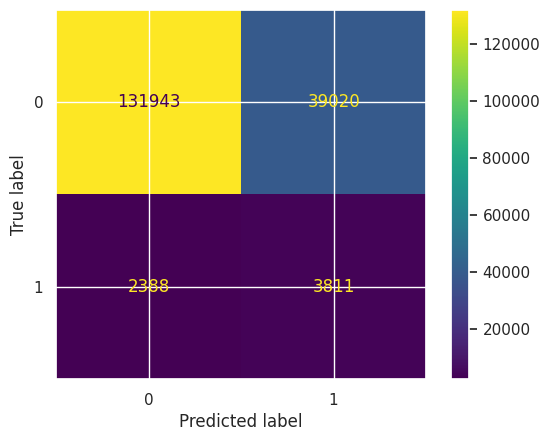

In [147]:
conf_matrix(y_valid, y_pred_valid_LR_sc)

In [148]:
print(classification_report(y_valid, y_pred_valid_LR_sc))

              precision    recall  f1-score   support

           0       0.98      0.77      0.86    170963
           1       0.09      0.61      0.16      6199

    accuracy                           0.77    177162
   macro avg       0.54      0.69      0.51    177162
weighted avg       0.95      0.77      0.84    177162



#### По матрице ошибок и отчёту классификации видно, что полнота предсказаных значений класса ```1``` **значительно выросла**

#### Теперь попробуем убрать шум в данных при помощи **метода главных компонент**

In [149]:
X_train_sc

TransactionDT  TransactionAmt  ProductCD     card1     card2  \
184962      -0.754182       -0.343262   0.764772  1.499366  1.203163   
510418       1.290382       -0.347624   0.764772  1.734702  1.276167   
121172      -1.137010       -0.347624   0.764772  1.321469 -1.497995   
461070       0.952623       -0.172921  -0.965826  0.181773  1.373506   
329698       0.128026       -0.447128   0.764772 -0.048811 -0.220420   
...               ...             ...        ...       ...       ...   
229182      -0.464365       -0.509061  -1.542692  0.171855 -0.932212   
66399       -1.335012       -0.526066  -0.965826 -0.444481  1.190995   
276627      -0.178139       -0.546212  -1.542692  0.846251  0.108099   
683         -1.642945       -0.071781  -1.542692 -0.810812  0.308861   
131836      -1.087993       -0.002581   0.764772 -0.375472 -0.993049   

           card4     card5     card6     addr1     addr2  P_emaildomain  \
184962  0.714331  0.679743  0.721377 -0.257547  0.561576      -0.501521   
510418 -1.199469 -1.628247  0.721377 -0.126744  0.561576      -0.501521   
121172  0.714331  0.679743  0.721377  0.494569  0.561576      -0.501521   
461070  0.714331  0.679743 -1.305821  0.265664  0.561576      -0.046029   
329698  0.714331  0.679743  0.721377  0.697314  0.561576       0.409462   
...          ...       ...       ...       ...       ...            ...   
229182  0.714331  0.679743 -1.305821 -1.467472 -1.801624      -0.501521   
66399   0.714331  0.679743 -1.305821  0.743095  0.561576      -0.957012   
276627 -1.199469  0.637394  0.721377 -1.467472 -1.801624      -0.306310   
683    -1.199469  0.637394  0.721377 -1.467472 -1.801624      -0.501521   
131836 -1.199469  0.171561  0.721377  1.606393  0.561576      -0.501521   

              C3        D3        V1       V55      V107      V121    V281  \
184962 -0.030088 -0.469273 -0.005110 -0.239278  0.017346 -0.078016 -0.2284   
510418 -0.030088 -0.369010  0.013978 -0.239278  0.017346 -0.078016 -0.2284   
121172 -0.030088 -0.444207 -0.005110 -0.239278  0.017346 -0.078016 -0.2284   
461070 -0.030088  0.090272 -0.005110 -0.089083  0.017346 -0.078016 -0.2284   
329698 -0.030088 -0.594602  0.013978 -0.239278  0.017346 -0.078016 -0.2284   
...          ...       ...       ...       ...       ...       ...     ...   
229182 -0.030088  6.499029 -0.005110 -0.239278  0.017346 -0.078016 -0.2284   
66399  -0.030088  0.090272 -0.005110 -0.089083  0.017346 -0.078016 -0.2284   
276627 -0.030088 -0.619668 -0.005110 -0.239278  0.017346 -0.078016 -0.2284   
683    -0.030088 -0.619668 -0.005110 -0.239278  0.017346 -0.078016 -0.2284   
131836 -0.030088 -0.619668 -0.005110 -0.239278  0.017346 -0.078016 -0.2284   

            V286      V305  
184962 -0.171834 -0.008903  
510418 -0.171834 -0.008903  
121172 -0.171834 -0.008903  
461070 -0.171834 -0.008903  
329698 -0.171834 -0.008903  
...          ...       ...  
229182 -0.171834 -0.008903  
66399  -0.171834 -0.008903  
276627 -0.171834 -0.008903  
683     4.877799 -0.008903  
131836  4.877799 -0.008903  

[239725 rows x 20 columns]

In [150]:
from sklearn import decomposition

In [151]:
pca = decomposition.PCA()
pca.fit(X_train_sc)
X_train_norm = pca.transform(X_train_sc)
X_valid_norm = pca.transform(X_valid_sc)

Посмотрим, как выглядит вклад каждой из компонент в разброс исходных данных

In [152]:
pca.explained_variance_ratio_

array([0.1462715 , 0.08193919, 0.0679886 , 0.05847495, 0.05279725,
       0.05136422, 0.05070917, 0.05026217, 0.04998161, 0.04927269,
       0.04852701, 0.04768117, 0.0466232 , 0.04460675, 0.04377238,
       0.03533603, 0.03114095, 0.0237092 , 0.0145764 , 0.00496558])

Видим, что большая часть компонент вносит примерно равный вклад в разброс исходных данных, поэтому будем обучать модель с использованием всех компонент

In [153]:
model_LR_norm = LogisticRegression()
model_LR_norm.fit(X_train_norm, y_train_balanced)

LogisticRegression()

In [154]:
y_pred_valid_LR_norm = model_LR_norm.predict(X_valid_norm)

In [155]:
print(f'Доля верно угаданных объектов {(y_pred_valid_LR_norm == y_valid).sum() / len(y_valid)}')

Доля верно угаданных объектов 0.7662704191643807


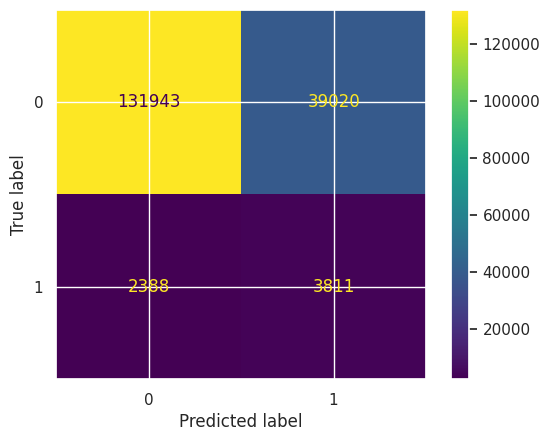

In [156]:
conf_matrix(y_valid, y_pred_valid_LR_norm)

In [157]:
print(classification_report(y_valid, y_pred_valid_LR_norm))

              precision    recall  f1-score   support

           0       0.98      0.77      0.86    170963
           1       0.09      0.61      0.16      6199

    accuracy                           0.77    177162
   macro avg       0.54      0.69      0.51    177162
weighted avg       0.95      0.77      0.84    177162



### Попробуем сделать прогнозы с использованием других, более сложных моделей

Напишем функцию, которая будет обучать модели, делать прогнозы и предоставлять отчёт по качеству прогнозов

In [158]:
def fit_pred_score(model, model_name, X_train, y_train, X_valid, y_valid):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_valid)
    y_pred_proba = model.predict_proba(X_valid)[:,1]
    print('------------------------------')
    print(model_name)
    print(f'Доля верно угаданных объектов {(y_pred == y_valid).sum() / len(y_valid)}')
    conf_matrix(y_valid, y_pred)
    print(classification_report(y_valid, y_pred))
    roc_auc = roc_auc_score(y_valid, y_pred_proba)
    print('roc auc score: ', roc_auc_score(y_valid, y_pred_proba))
    return model, roc_auc

#### Обучим модели на признаках до масштабирования

------------------------------
DecisionTree
Доля верно угаданных объектов 0.9303349476750093


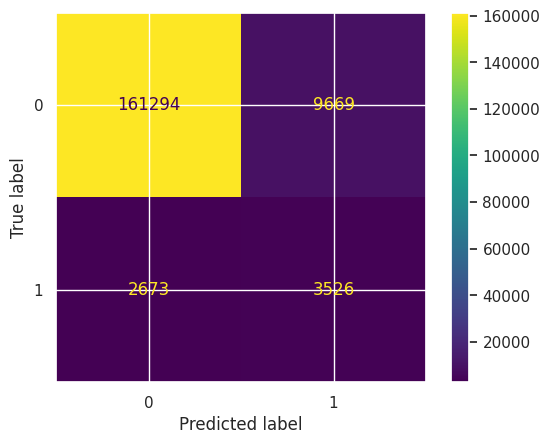

              precision    recall  f1-score   support

           0       0.98      0.94      0.96    170963
           1       0.27      0.57      0.36      6199

    accuracy                           0.93    177162
   macro avg       0.63      0.76      0.66    177162
weighted avg       0.96      0.93      0.94    177162

roc auc score:  0.7561226613252745


In [159]:
DT_not_sc, DT_not_sc_roc_auc = fit_pred_score(DecisionTreeClassifier(), 'DecisionTree', X_train_balanced2, y_train_balanced, X_valid_copy2, y_valid)

------------------------------
RandomForest
Доля верно угаданных объектов 0.9662004267280794


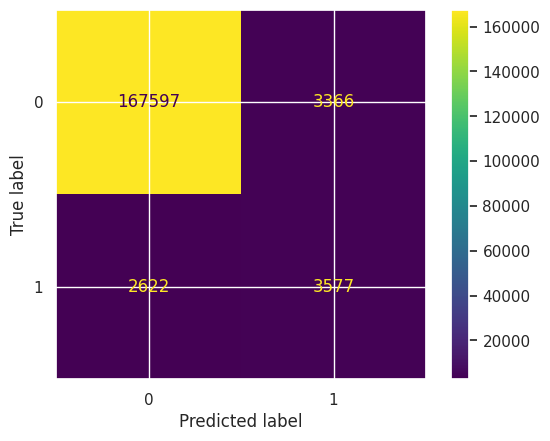

              precision    recall  f1-score   support

           0       0.98      0.98      0.98    170963
           1       0.52      0.58      0.54      6199

    accuracy                           0.97    177162
   macro avg       0.75      0.78      0.76    177162
weighted avg       0.97      0.97      0.97    177162

roc auc score:  0.9111067392260297


In [160]:
RF_not_sc, RF_not_sc_roc_auc = fit_pred_score(RandomForestClassifier(), 'RandomForest', X_train_balanced2, y_train_balanced, X_valid_copy2, y_valid)

------------------------------
AdaBoost
Доля верно угаданных объектов 0.7648423476817828


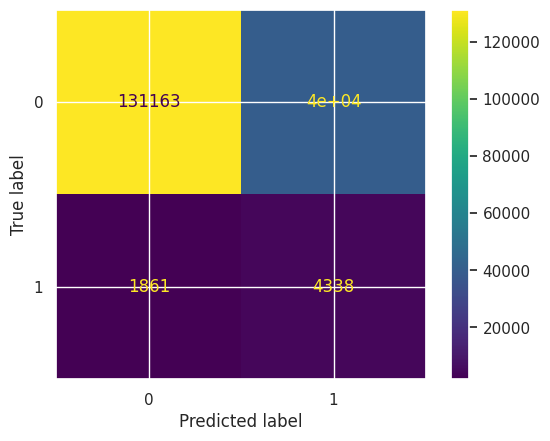

              precision    recall  f1-score   support

           0       0.99      0.77      0.86    170963
           1       0.10      0.70      0.17      6199

    accuracy                           0.76    177162
   macro avg       0.54      0.73      0.52    177162
weighted avg       0.95      0.76      0.84    177162

roc auc score:  0.8093065165863988


In [161]:
AdaB_not_sc, AdaB_not_sc_roc_auc = fit_pred_score(AdaBoostClassifier(), 'AdaBoost', X_train_balanced2, y_train_balanced, X_valid_copy2, y_valid)

------------------------------
GradientBoosting
Доля верно угаданных объектов 0.7777683701922534


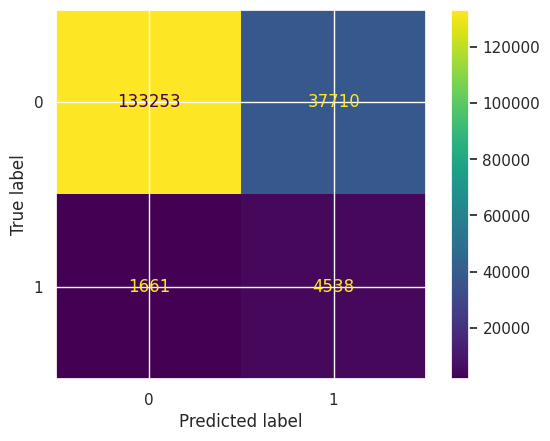

              precision    recall  f1-score   support

           0       0.99      0.78      0.87    170963
           1       0.11      0.73      0.19      6199

    accuracy                           0.78    177162
   macro avg       0.55      0.76      0.53    177162
weighted avg       0.96      0.78      0.85    177162

roc auc score:  0.8329507368004505


In [162]:
GBM_not_sc_model, GBM_not_sc_roc_auc = fit_pred_score(GradientBoostingClassifier(), 'GradientBoosting', X_train_balanced2, y_train_balanced, X_valid_copy2, y_valid)

------------------------------
XGB
Доля верно угаданных объектов 0.8593152030345108


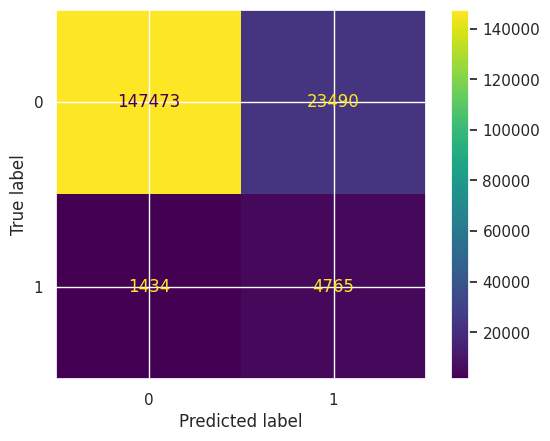

              precision    recall  f1-score   support

           0       0.99      0.86      0.92    170963
           1       0.17      0.77      0.28      6199

    accuracy                           0.86    177162
   macro avg       0.58      0.82      0.60    177162
weighted avg       0.96      0.86      0.90    177162

roc auc score:  0.8930805064051932


In [163]:
XGB_not_sc, XGB_not_sc_roc_auc = fit_pred_score(XGBClassifier(), 'XGB', X_train_balanced2, y_train_balanced, X_valid_copy2, y_valid)

------------------------------
LGBM
Доля верно угаданных объектов 0.8279992323410212


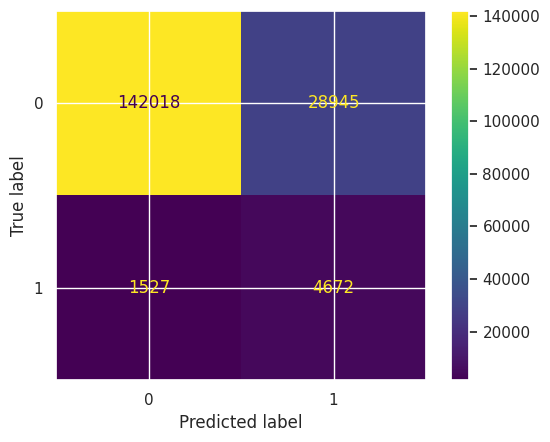

              precision    recall  f1-score   support

           0       0.99      0.83      0.90    170963
           1       0.14      0.75      0.23      6199

    accuracy                           0.83    177162
   macro avg       0.56      0.79      0.57    177162
weighted avg       0.96      0.83      0.88    177162

roc auc score:  0.873134266321701


In [164]:
LGBM_not_sc, LGBM_not_sc_roc_auc = fit_pred_score(LGBMClassifier(), 'LGBM', X_train_balanced2, y_train_balanced, X_valid_copy2, y_valid)

#### после масштабирования

------------------------------
DecisionTree
Доля верно угаданных объектов 0.9304252604960431


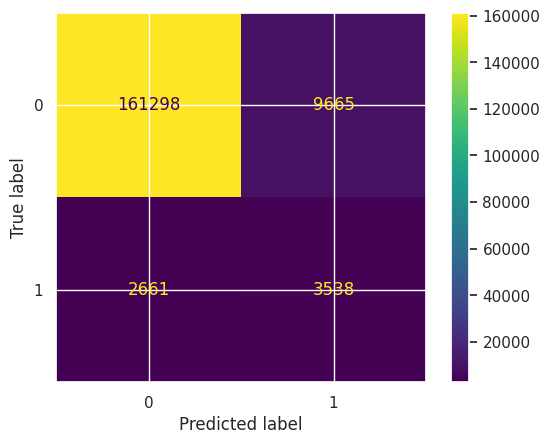

              precision    recall  f1-score   support

           0       0.98      0.94      0.96    170963
           1       0.27      0.57      0.36      6199

    accuracy                           0.93    177162
   macro avg       0.63      0.76      0.66    177162
weighted avg       0.96      0.93      0.94    177162

roc auc score:  0.7571022578110206


In [165]:
DT_sc, DT_sc_roc_auc = fit_pred_score(DecisionTreeClassifier(), 'DecisionTree', X_train_sc, y_train_balanced, X_valid_sc, y_valid)

------------------------------
RandomForest
Доля верно угаданных объектов 0.9660875357017871


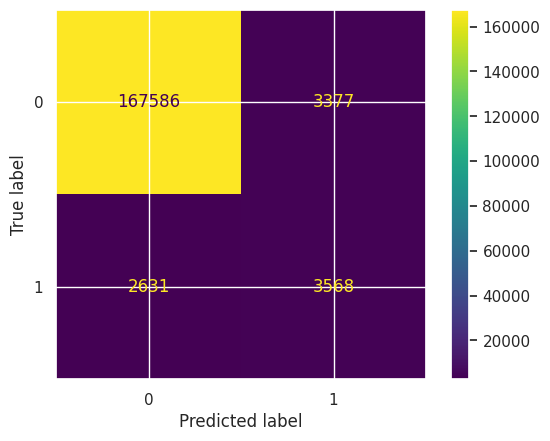

              precision    recall  f1-score   support

           0       0.98      0.98      0.98    170963
           1       0.51      0.58      0.54      6199

    accuracy                           0.97    177162
   macro avg       0.75      0.78      0.76    177162
weighted avg       0.97      0.97      0.97    177162

roc auc score:  0.9106161828209798


In [166]:
RF_sc, RF_sc_roc_auc = fit_pred_score(RandomForestClassifier(), 'RandomForest', X_train_sc, y_train_balanced, X_valid_sc, y_valid)

------------------------------
AdaBoost
Доля верно угаданных объектов 0.7648423476817828


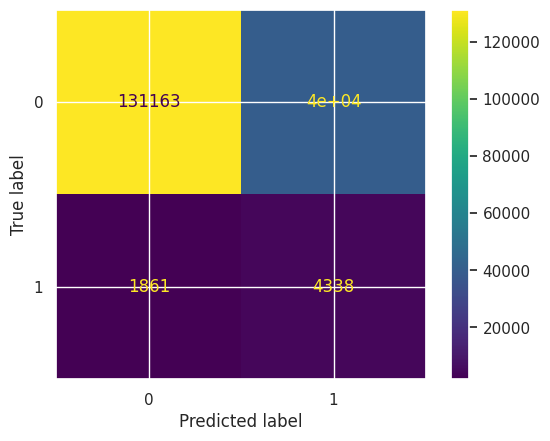

              precision    recall  f1-score   support

           0       0.99      0.77      0.86    170963
           1       0.10      0.70      0.17      6199

    accuracy                           0.76    177162
   macro avg       0.54      0.73      0.52    177162
weighted avg       0.95      0.76      0.84    177162

roc auc score:  0.8093065165863988


In [167]:
AdaB_sc_model, AdaB_sc_roc_auc_score = fit_pred_score(AdaBoostClassifier(), 'AdaBoost', X_train_sc, y_train_balanced, X_valid_sc, y_valid)

------------------------------
GradientBoosting
Доля верно угаданных объектов 0.777774014743568


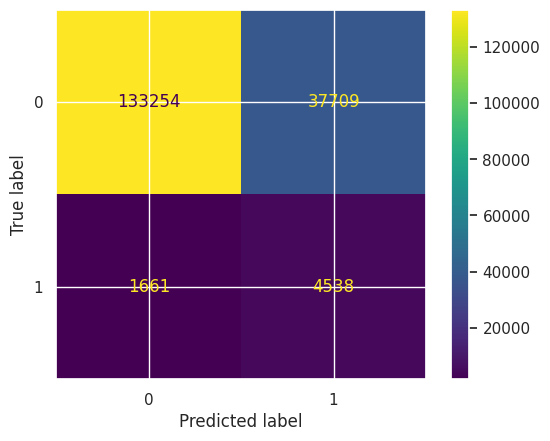

              precision    recall  f1-score   support

           0       0.99      0.78      0.87    170963
           1       0.11      0.73      0.19      6199

    accuracy                           0.78    177162
   macro avg       0.55      0.76      0.53    177162
weighted avg       0.96      0.78      0.85    177162

roc auc score:  0.8329502782232034


In [168]:
GBM_sc_model, GBM_sc_roc_auc_score = fit_pred_score(GradientBoostingClassifier(), 'GradientBoosting', X_train_sc, y_train_balanced, X_valid_sc, y_valid)

------------------------------
XGB
Доля верно угаданных объектов 0.8593152030345108


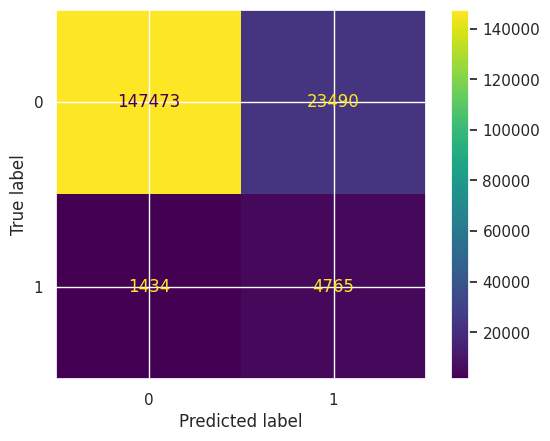

              precision    recall  f1-score   support

           0       0.99      0.86      0.92    170963
           1       0.17      0.77      0.28      6199

    accuracy                           0.86    177162
   macro avg       0.58      0.82      0.60    177162
weighted avg       0.96      0.86      0.90    177162

roc auc score:  0.8930797411662068


In [169]:
XGB_sc_model, XGB_sc_roc_auc_score = fit_pred_score(XGBClassifier(), 'XGB', X_train_sc, y_train_balanced, X_valid_sc, y_valid)

------------------------------
LGBM
Доля верно угаданных объектов 0.8277678057371219


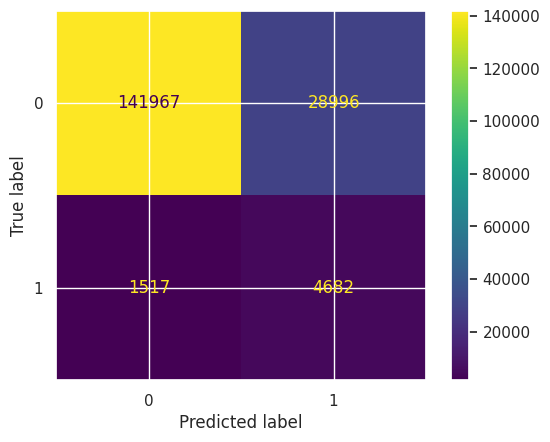

              precision    recall  f1-score   support

           0       0.99      0.83      0.90    170963
           1       0.14      0.76      0.23      6199

    accuracy                           0.83    177162
   macro avg       0.56      0.79      0.57    177162
weighted avg       0.96      0.83      0.88    177162

roc auc score:  0.8726035046754785


In [170]:
LGBM_sc_model, LGBM_sc_roc_auc_score = fit_pred_score(LGBMClassifier(), 'LGBM', X_train_sc, y_train_balanced, X_valid_sc, y_valid)

Сделаем общую таблицу по основной метрике качества этого задания ```roc auc score```, чтобы наглядно увидеть лучшую модель:

In [171]:
roc_auc_df_no_sc = pd.DataFrame(data=[DT_not_sc_roc_auc, 
                                RF_not_sc_roc_auc,
                                AdaB_not_sc_roc_auc,
                                GBM_not_sc_roc_auc,
                                XGB_not_sc_roc_auc,
                                LGBM_not_sc_roc_auc],
                          index=['DT', 'RF', 'AdaBoost', 'GBM', 'XGB', 'LGBM'],
                         columns=['roc_auc_score(mean, not sc)'])
roc_auc_df_sc = pd.DataFrame(data=[DT_sc_roc_auc, 
                                RF_sc_roc_auc,
                                AdaB_sc_roc_auc_score,
                                GBM_sc_roc_auc_score,
                                XGB_sc_roc_auc_score,
                                LGBM_sc_roc_auc_score],
                          index=['DT', 'RF', 'AdaBoost', 'GBM', 'XGB', 'LGBM'],
                         columns=['roc_auc_score(mean, sc)'])
roc_auc_df = pd.concat([roc_auc_df_no_sc, roc_auc_df_sc], axis=1)
roc_auc_df

roc_auc_score(mean, not sc)  roc_auc_score(mean, sc)
DT                           0.756123                 0.757102
RF                           0.911107                 0.910616
AdaBoost                     0.809307                 0.809307
GBM                          0.832951                 0.832950
XGB                          0.893081                 0.893080
LGBM                         0.873134                 0.872604

### Видим, что классфикатор ```Random Forest``` показал наилучшую точность. Также масштабирование признаков не сильно повлияло на обучение, т.к. эти ансамблевые алгоритмы не так чувствительные к масштабированию, как линейные

#### Посмотрим на важность признаков:

In [172]:
print('DecesionTree important features:')
sorted(zip(X_train_sc.columns, DT_sc.feature_importances_), key=lambda x: -x[1])

DecesionTree important features:


[('TransactionDT', 0.19493323108399116),
 ('TransactionAmt', 0.14053420882684875),
 ('addr2', 0.11154384194011811),
 ('card1', 0.1054507944203018),
 ('addr1', 0.07794811845201544),
 ('D3', 0.07711225262888115),
 ('card2', 0.07298519458511318),
 ('P_emaildomain', 0.06545172553476294),
 ('V55', 0.05653298755125856),
 ('card5', 0.0259527655696306),
 ('card6', 0.016973318794901212),
 ('V281', 0.015640483640276297),
 ('ProductCD', 0.012544302159147673),
 ('card4', 0.010315931859013286),
 ('V1', 0.0071443006689415394),
 ('V286', 0.004652449013272654),
 ('C3', 0.0027331656046415366),
 ('V121', 0.0013726769572051174),
 ('V107', 0.00017825070967907245),
 ('V305', 0.0)]

In [173]:
print('RandomForest important features:')
sorted(zip(X_train_sc.columns, RF_sc.feature_importances_), key=lambda x: -x[1])

RandomForest important features:


[('TransactionDT', 0.16878593257183516),
 ('TransactionAmt', 0.1471148797198339),
 ('addr1', 0.10691799411966128),
 ('card1', 0.10030278433066911),
 ('D3', 0.08594144396813107),
 ('card2', 0.07767589543248439),
 ('P_emaildomain', 0.06856503019481916),
 ('ProductCD', 0.05628856745984075),
 ('addr2', 0.038165262547480115),
 ('card5', 0.03258592460055964),
 ('card6', 0.027393983399784667),
 ('V281', 0.02535881216171616),
 ('V55', 0.025155745701836808),
 ('V1', 0.016356143436227065),
 ('card4', 0.013214581939981348),
 ('V286', 0.00610523400672579),
 ('V121', 0.001956673166659605),
 ('C3', 0.0018280334763840563),
 ('V107', 0.0002849866756800807),
 ('V305', 2.091089689691572e-06)]

In [174]:
print('AdaBoost important features:')
sorted(zip(X_train_sc.columns, AdaB_sc_model.feature_importances_), key=lambda x: -x[1])

AdaBoost important features:


[('P_emaildomain', 0.2),
 ('TransactionAmt', 0.12),
 ('V55', 0.1),
 ('TransactionDT', 0.08),
 ('card1', 0.08),
 ('D3', 0.08),
 ('card4', 0.06),
 ('card5', 0.04),
 ('card6', 0.04),
 ('V281', 0.04),
 ('ProductCD', 0.02),
 ('card2', 0.02),
 ('addr1', 0.02),
 ('addr2', 0.02),
 ('C3', 0.02),
 ('V1', 0.02),
 ('V121', 0.02),
 ('V286', 0.02),
 ('V107', 0.0),
 ('V305', 0.0)]

In [175]:
print('GradientBoosting important features:')
sorted(zip(X_train_sc.columns, GBM_sc_model.feature_importances_), key=lambda x: -x[1])

GradientBoosting important features:


[('ProductCD', 0.2049859134146234),
 ('addr2', 0.16408654877145615),
 ('D3', 0.16247044748042916),
 ('TransactionAmt', 0.09620056082580031),
 ('TransactionDT', 0.07286113655336399),
 ('card6', 0.06494562363742683),
 ('V55', 0.06156191308657844),
 ('V281', 0.04537420414964147),
 ('P_emaildomain', 0.04231274484879911),
 ('card2', 0.0229047233051512),
 ('card1', 0.021387873618127252),
 ('addr1', 0.013092997860679053),
 ('V286', 0.009478743521379063),
 ('card5', 0.006359362203548045),
 ('C3', 0.004775020008586857),
 ('card4', 0.004627828954847297),
 ('V121', 0.0016938265448061974),
 ('V1', 0.0007678882968004718),
 ('V107', 0.00011264291795565212),
 ('V305', 0.0)]

In [176]:
print('XGB important features:')
sorted(zip(X_train_sc.columns, XGB_sc_model.feature_importances_), key=lambda x: -x[1])

XGB important features:


[('addr2', 0.44352883),
 ('V55', 0.084419385),
 ('ProductCD', 0.076541275),
 ('D3', 0.049204685),
 ('V281', 0.04371192),
 ('card6', 0.042780876),
 ('V286', 0.038277537),
 ('C3', 0.035720292),
 ('P_emaildomain', 0.022258176),
 ('TransactionAmt', 0.02177753),
 ('card2', 0.019204076),
 ('card4', 0.017549979),
 ('V121', 0.017274601),
 ('card1', 0.017067907),
 ('addr1', 0.016981035),
 ('TransactionDT', 0.016501527),
 ('card5', 0.016406527),
 ('V1', 0.013086661),
 ('V107', 0.0077072997),
 ('V305', 0.0)]

In [177]:
print('LGB important features:')
sorted(zip(X_train_sc.columns, LGBM_sc_model.feature_importances_), key=lambda x: -x[1])

LGB important features:


[('TransactionAmt', 426),
 ('card1', 401),
 ('card2', 390),
 ('addr1', 311),
 ('TransactionDT', 305),
 ('P_emaildomain', 297),
 ('D3', 184),
 ('ProductCD', 121),
 ('card5', 115),
 ('V55', 110),
 ('card6', 85),
 ('V281', 65),
 ('addr2', 55),
 ('card4', 47),
 ('V286', 30),
 ('C3', 27),
 ('V121', 16),
 ('V1', 13),
 ('V107', 2),
 ('V305', 0)]

По большей части в моделях наименее важными считаются признаки:
```'V286'``` , ```'V121'```, ```'C3'```, ```'V107'```, ```'V305'```.
Удалим их из данных

In [178]:
not_important_feats = ['V286', 'V121', 'C3', 'V107', 'V305']
X_train_sc = X_train_sc.drop(columns=not_important_feats)
X_valid_sc = X_valid_sc.drop(columns=not_important_feats)

In [179]:
test_df_sc = test_df_sc.drop(columns=not_important_feats)

In [180]:
X_train_sc

TransactionDT  TransactionAmt  ProductCD     card1     card2  \
184962      -0.754182       -0.343262   0.764772  1.499366  1.203163   
510418       1.290382       -0.347624   0.764772  1.734702  1.276167   
121172      -1.137010       -0.347624   0.764772  1.321469 -1.497995   
461070       0.952623       -0.172921  -0.965826  0.181773  1.373506   
329698       0.128026       -0.447128   0.764772 -0.048811 -0.220420   
...               ...             ...        ...       ...       ...   
229182      -0.464365       -0.509061  -1.542692  0.171855 -0.932212   
66399       -1.335012       -0.526066  -0.965826 -0.444481  1.190995   
276627      -0.178139       -0.546212  -1.542692  0.846251  0.108099   
683         -1.642945       -0.071781  -1.542692 -0.810812  0.308861   
131836      -1.087993       -0.002581   0.764772 -0.375472 -0.993049   

           card4     card5     card6     addr1     addr2  P_emaildomain  \
184962  0.714331  0.679743  0.721377 -0.257547  0.561576      -0.501521   
510418 -1.199469 -1.628247  0.721377 -0.126744  0.561576      -0.501521   
121172  0.714331  0.679743  0.721377  0.494569  0.561576      -0.501521   
461070  0.714331  0.679743 -1.305821  0.265664  0.561576      -0.046029   
329698  0.714331  0.679743  0.721377  0.697314  0.561576       0.409462   
...          ...       ...       ...       ...       ...            ...   
229182  0.714331  0.679743 -1.305821 -1.467472 -1.801624      -0.501521   
66399   0.714331  0.679743 -1.305821  0.743095  0.561576      -0.957012   
276627 -1.199469  0.637394  0.721377 -1.467472 -1.801624      -0.306310   
683    -1.199469  0.637394  0.721377 -1.467472 -1.801624      -0.501521   
131836 -1.199469  0.171561  0.721377  1.606393  0.561576      -0.501521   

              D3        V1       V55    V281  
184962 -0.469273 -0.005110 -0.239278 -0.2284  
510418 -0.369010  0.013978 -0.239278 -0.2284  
121172 -0.444207 -0.005110 -0.239278 -0.2284  
461070  0.090272 -0.005110 -0.089083 -0.2284  
329698 -0.594602  0.013978 -0.239278 -0.2284  
...          ...       ...       ...     ...  
229182  6.499029 -0.005110 -0.239278 -0.2284  
66399   0.090272 -0.005110 -0.089083 -0.2284  
276627 -0.619668 -0.005110 -0.239278 -0.2284  
683    -0.619668 -0.005110 -0.239278 -0.2284  
131836 -0.619668 -0.005110 -0.239278 -0.2284  

[239725 rows x 15 columns]

In [181]:
X_valid_sc

TransactionDT  TransactionAmt  ProductCD     card1     card2  \
587423       1.809678       -0.102292   0.764772  0.586948 -0.542856   
268070      -0.231764        0.574914   0.764772 -0.477127  1.130158   
85582       -1.264944       -0.417866  -1.542692  0.235493 -1.540581   
544807       1.515572       -0.347624   0.764772  1.342131  0.235856   
571901       1.692963        1.031925   0.764772  1.309692  0.953731   
...               ...             ...        ...       ...       ...   
30610       -1.495668        0.034811  -0.388960  0.638602  1.203163   
207146      -0.613348       -0.118952   0.764772 -0.700892 -0.183918   
393770       0.524038        0.078435   0.764772  0.531368  0.016844   
362875       0.322919        0.038965   0.764772 -0.984577 -0.804454   
121325      -1.136485        0.637026   0.764772  0.685297 -0.336010   

           card4     card5     card6     addr1     addr2  P_emaildomain  \
587423  0.714331 -0.590711  0.721377  1.652174  0.561576      -0.501521   
268070 -1.199469  0.637394  0.721377 -0.525692  0.561576      -0.501521   
85582   0.714331 -1.204763 -1.305821 -1.467472 -1.801624      -0.306310   
544807 -1.199469  0.637394  0.721377  0.599212  0.561576      -0.501521   
571901 -1.199469 -1.945861 -1.305821  0.599212  0.561576      -0.306310   
...          ...       ...       ...       ...       ...            ...   
30610   0.714331 -1.945861 -1.305821  2.044582  0.803267      -0.501521   
207146 -2.156369 -0.590711  0.721377  0.664613  0.561576       1.971148   
393770  0.714331 -0.590711  0.721377 -0.211766  0.561576      -0.306310   
362875 -1.199469 -1.628247  0.721377  0.494569  0.561576       1.971148   
121325  0.714331  0.679743  0.721377  0.743095  0.561576       1.971148   

               D3        V1       V55    V281  
587423  -0.594602  0.013978 -0.239278 -0.2284  
268070  -0.318878 -0.004491  1.961155 -0.2284  
85582   -0.619668 -0.004491  4.161588 -0.2284  
544807  12.464698 -0.004491 -0.239278 -0.2284  
571901   0.091966  0.013978 -0.239278 -0.2284  
...           ...       ...       ...     ...  
30610    0.091966 -0.004491 -0.093385 -0.2284  
207146   0.091966 -0.004491 -0.239278 -0.2284  
393770   0.091966 -0.004491 -0.239278 -0.2284  
362875   0.091966  0.013978 -0.239278 -0.2284  
121325   0.809085 -0.004491 -0.239278 -0.2284  

[177162 rows x 15 columns]

In [182]:
test_df_sc

TransactionDT  TransactionAmt  ProductCD     card1     card2  \
0            2.403273       -0.455645   0.764772  0.139003 -1.497995   
1            2.403281       -0.384808   0.764772 -1.129002 -1.497995   
2            2.403292        0.122058   0.764772 -1.086852  1.318753   
3            2.403292        0.595480   0.764772  0.258841  0.016844   
4            2.403293       -0.306078   0.764772  1.711147  0.576543   
...               ...             ...        ...       ...       ...   
506686       5.898478       -0.195028  -1.542692  0.846251  0.108099   
506687       5.898479       -0.537811  -1.542692 -1.359999  0.308861   
506688       5.898488       -0.384808   0.764772  1.430769  0.807723   
506689       5.898490        0.250852   0.764772  1.422504  0.965899   
506690       5.898492       -0.487237  -1.542692 -0.831267 -1.151225   

           card4     card5     card6     addr1     addr2  P_emaildomain  \
0       0.714331  0.679743  0.721377 -0.349109  0.561576      -0.501521   
1       0.714331  0.679743  0.721377  0.494569  0.561576      -1.412504   
2       0.714331  0.679743  0.721377  1.626014  0.561576      -0.306310   
3       0.714331 -0.590711  0.721377 -0.120204  0.561576      -0.501521   
4      -1.199469 -1.628247  0.721377  0.265664  0.561576      -0.501521   
...          ...       ...       ...       ...       ...            ...   
506686 -1.199469  0.637394  0.721377  0.396467 -0.163497      -0.501521   
506687 -1.199469  0.637394  0.721377 -1.467472 -1.801624      -0.306310   
506688  0.714331  0.679743  0.721377  0.677693  0.561576      -0.306310   
506689 -1.199469  0.637394  0.721377 -0.303328  0.561576      -0.306310   
506690  0.714331 -0.993021 -1.305821 -1.467472 -1.801624      -0.306310   

              D3        V1       V55      V281  
0       0.057110  0.013978 -0.239278 -0.228400  
1      -0.444207  0.013978 -0.239278 -0.228400  
2      -0.369010  0.013978 -0.239278 -0.228400  
3       0.408031  0.013978 -0.239278 -0.228400  
4      -0.619668  0.013978 -0.239278 -0.228400  
...          ...       ...       ...       ...  
506686  0.217399  0.012925 -0.239278 -0.228400  
506687 -0.218615  0.012925  1.961155  1.046269  
506688  0.217399  0.013978 -0.239278 -0.228400  
506689  0.217399  0.013978 -0.239278 -0.228400  
506690  0.217399  0.012925 -0.239278 -0.228400  

[506691 rows x 15 columns]

Теперь уберём выбросы из данных и затем снова приступим к обучению моделей

Снова посмотрим на распределения оставшихся признаков

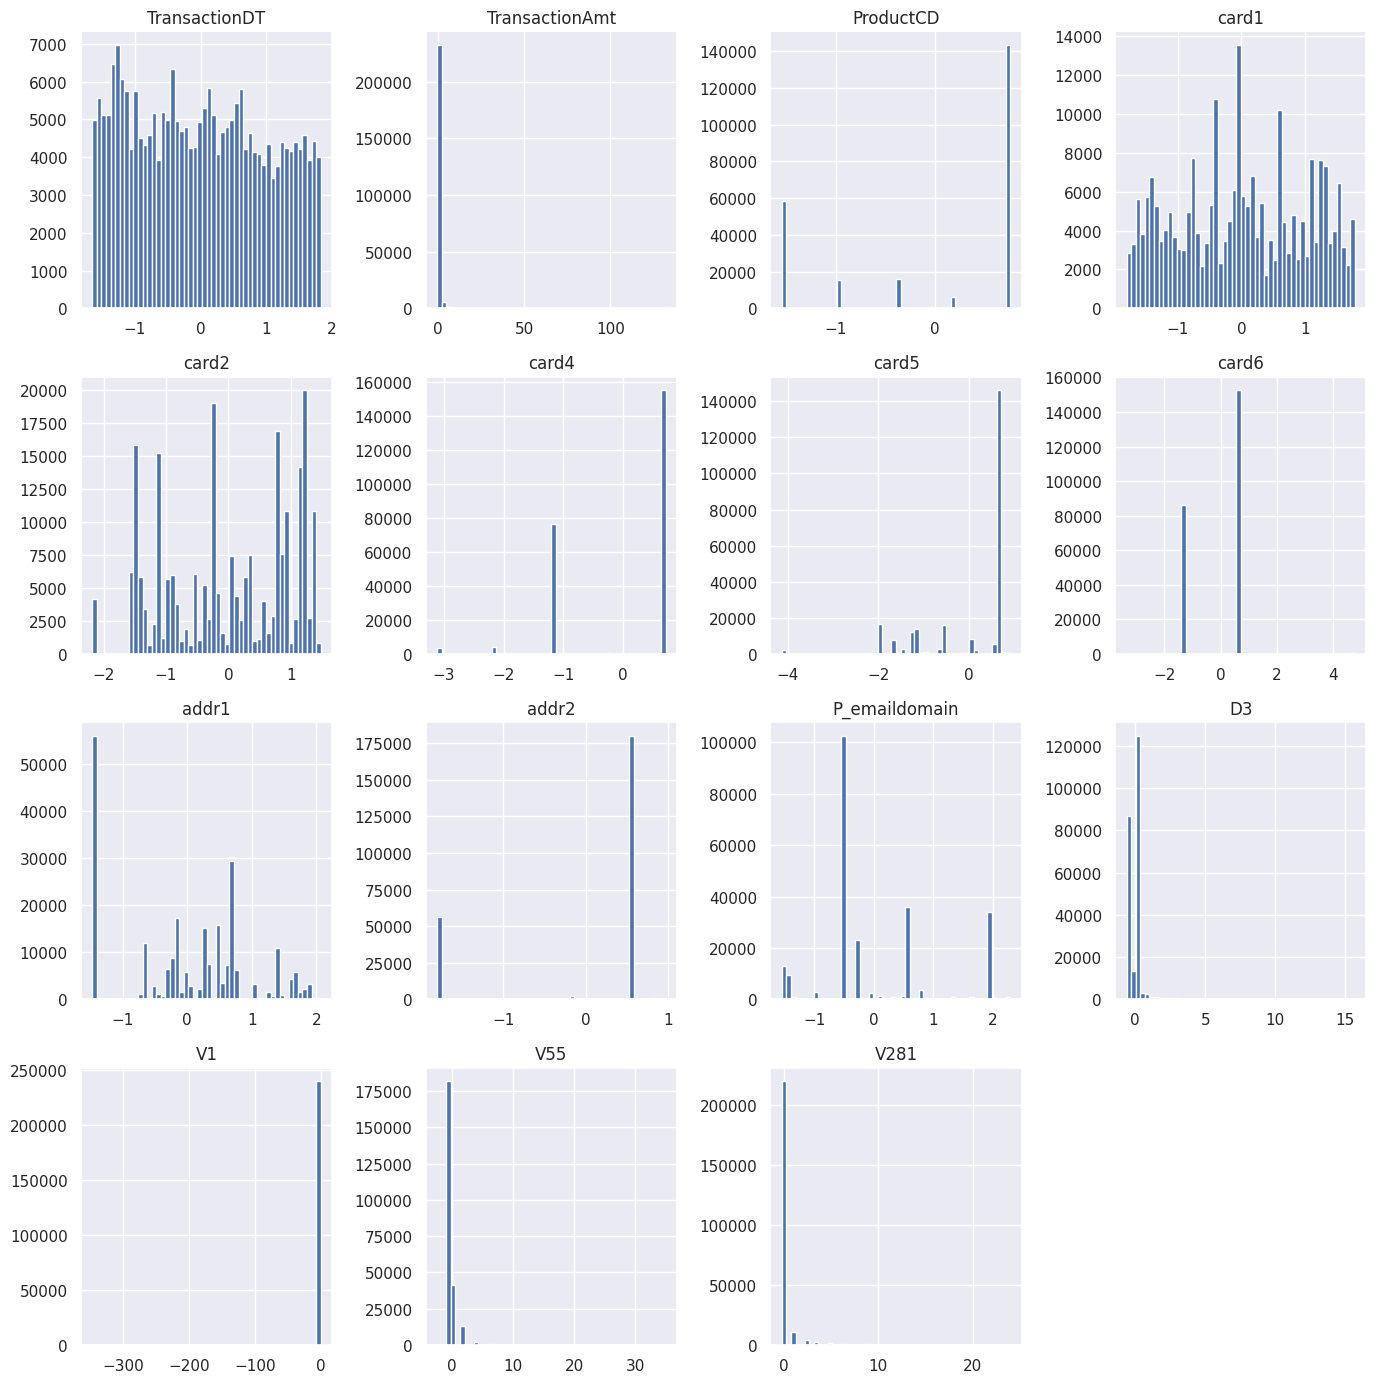

In [183]:
X_train_sc.hist(bins=50, figsize=(14,14))
plt.tight_layout()

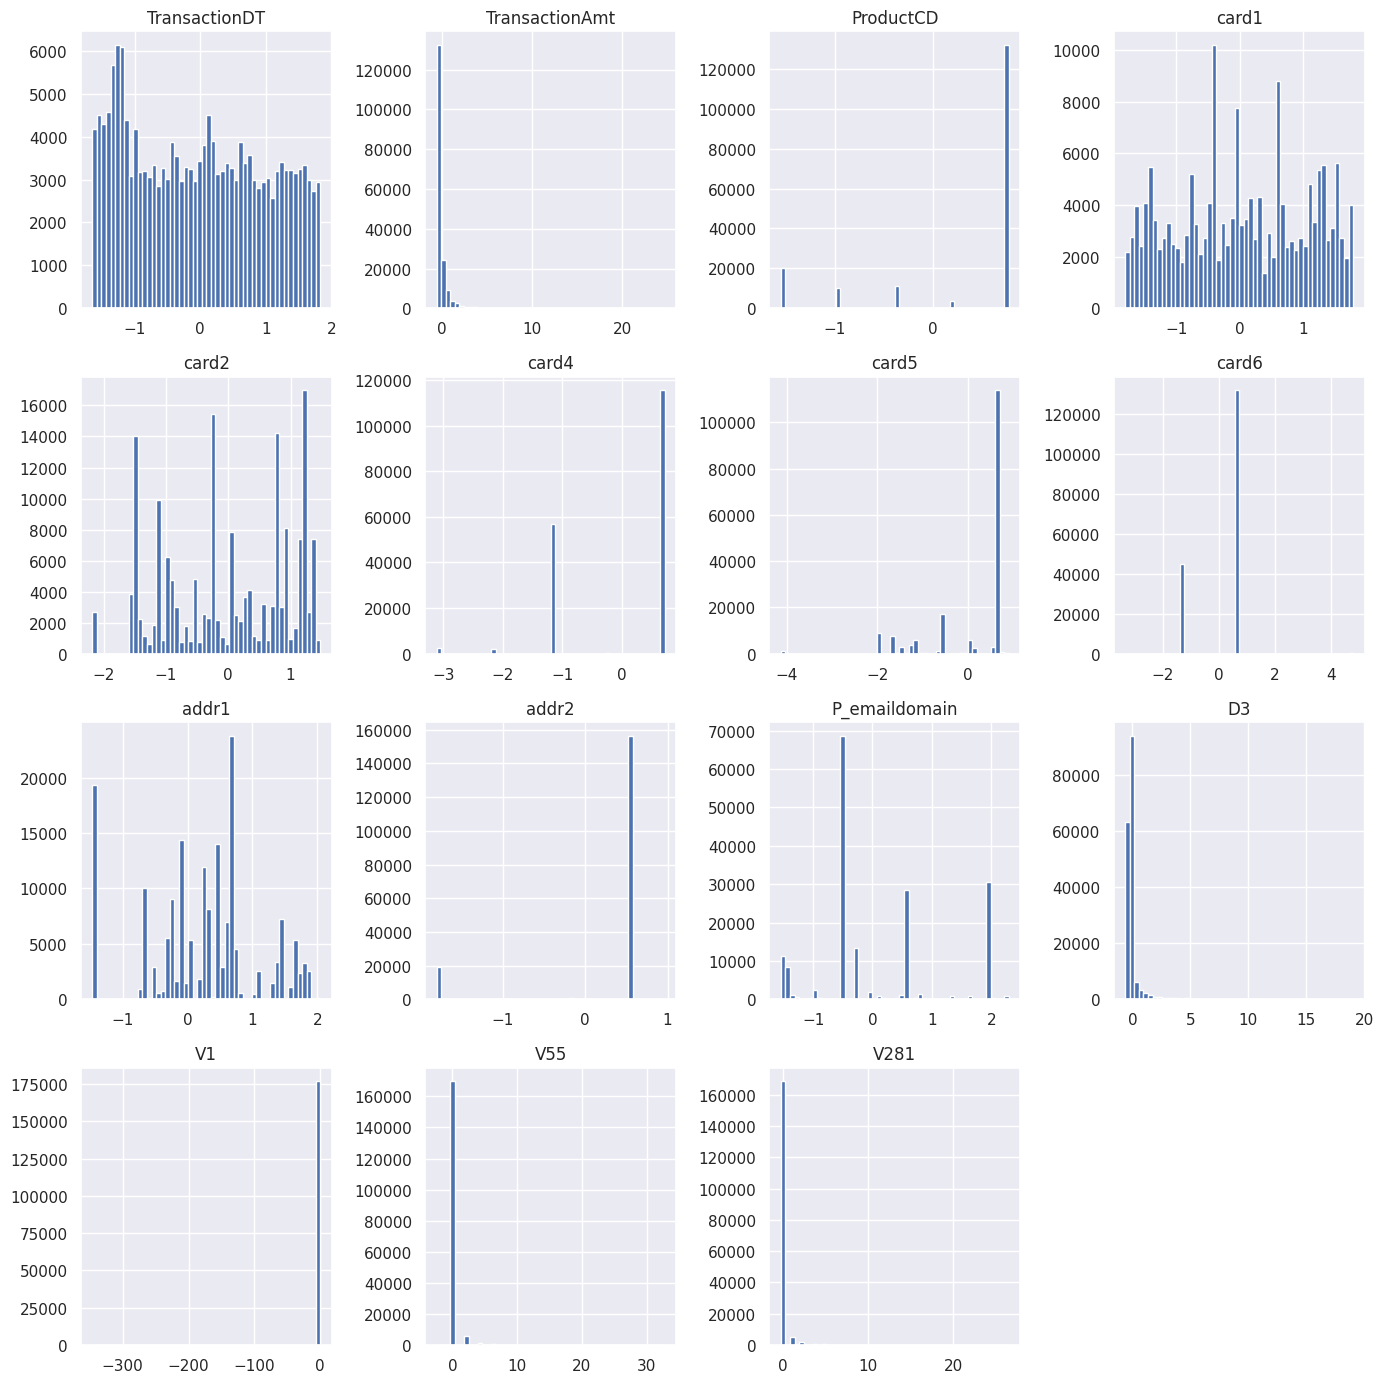

In [184]:
X_valid_sc.hist(bins=50, figsize=(14,14))
plt.tight_layout()

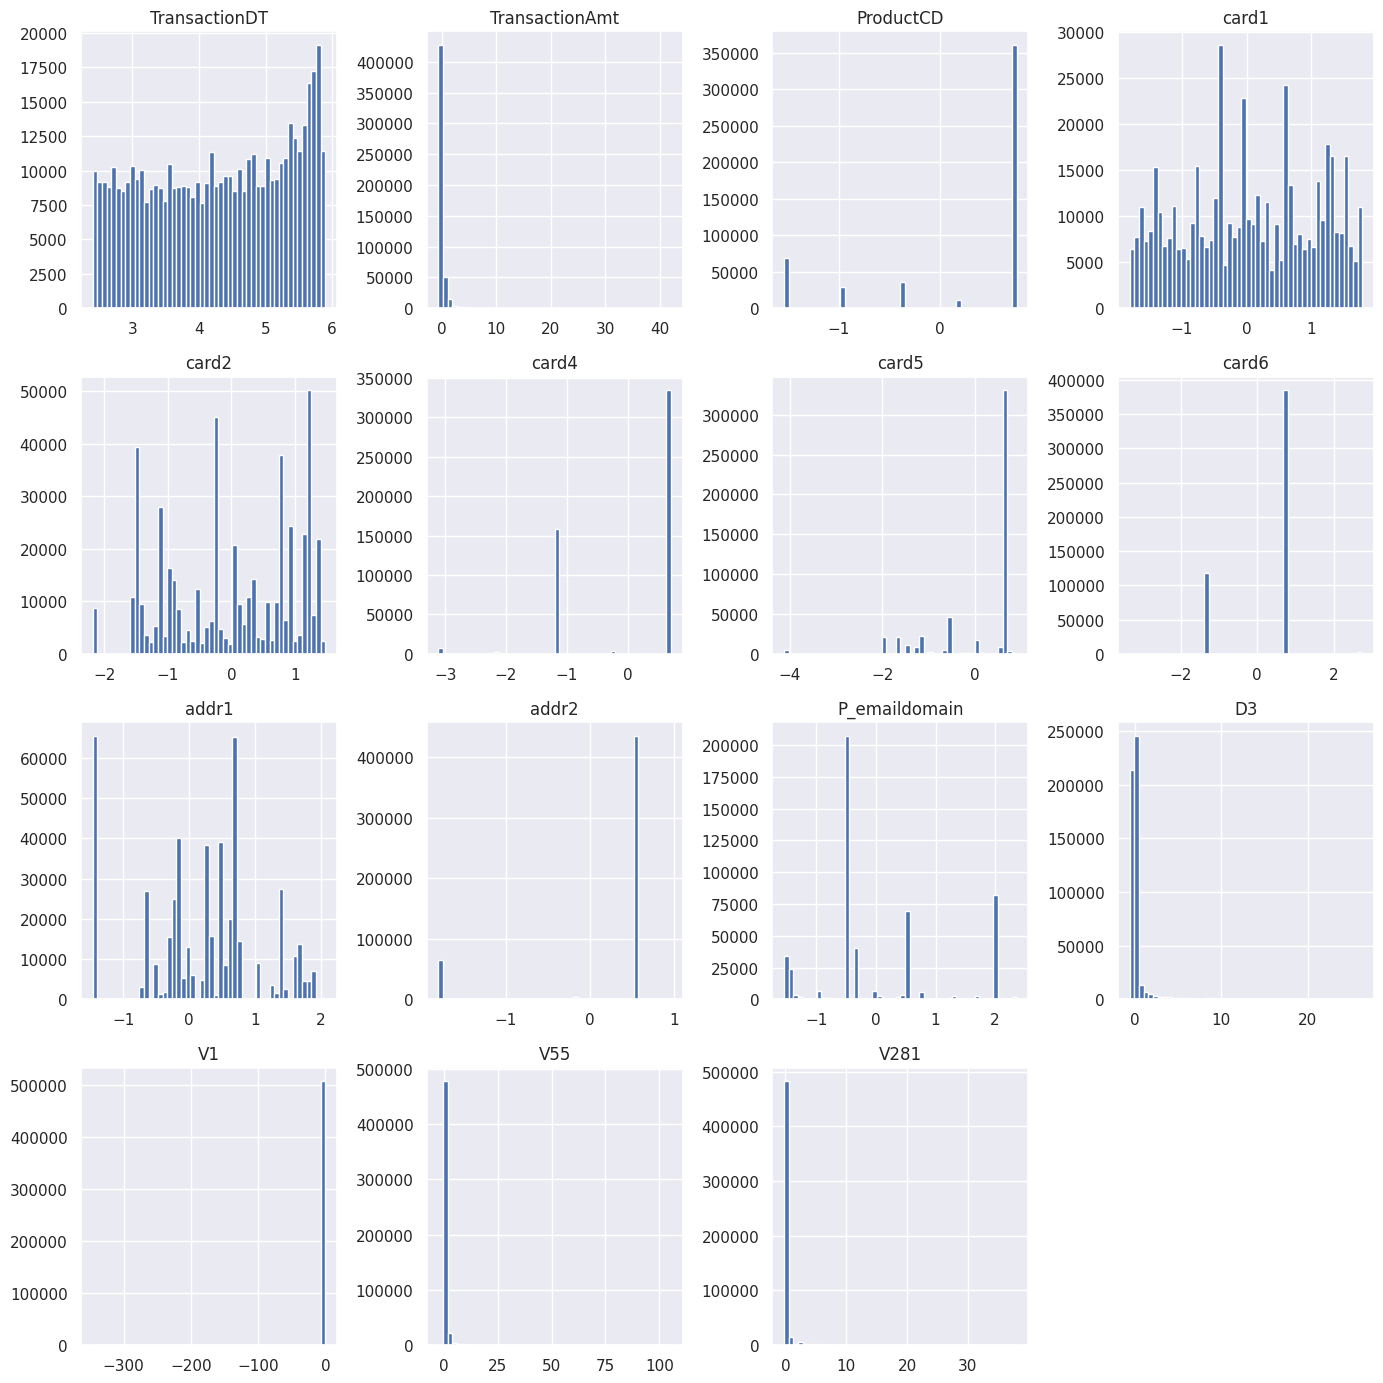

In [185]:
test_df_sc.hist(bins=50, figsize=(14,14))
plt.tight_layout()

А также на boxplotы

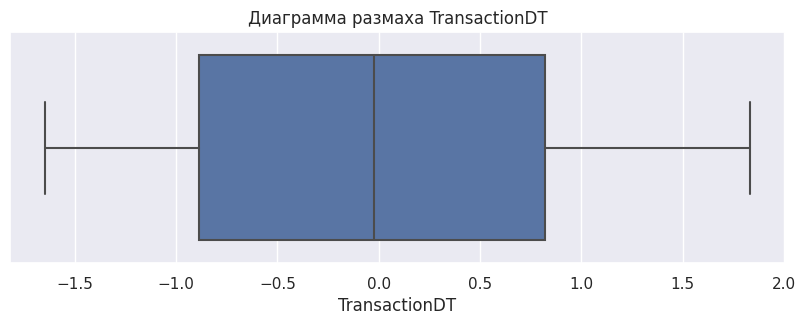

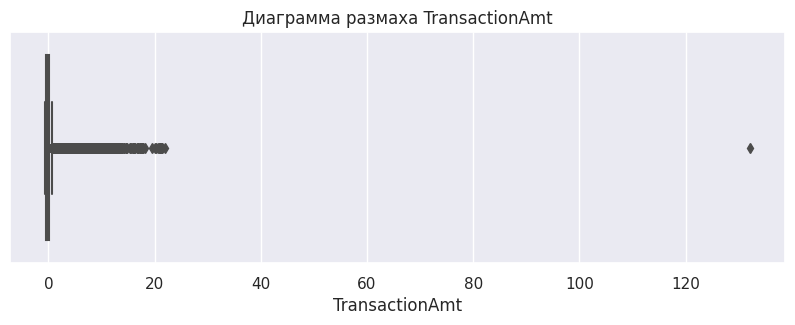

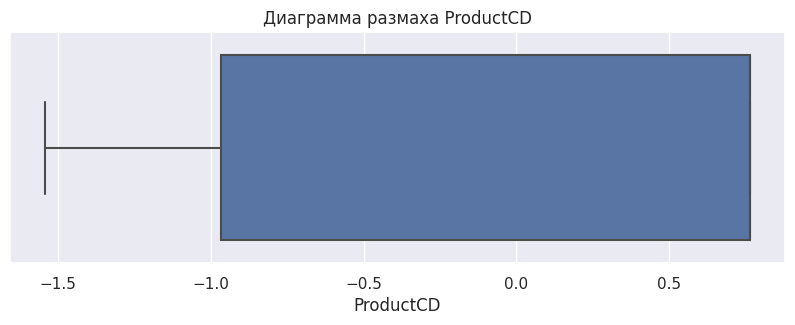

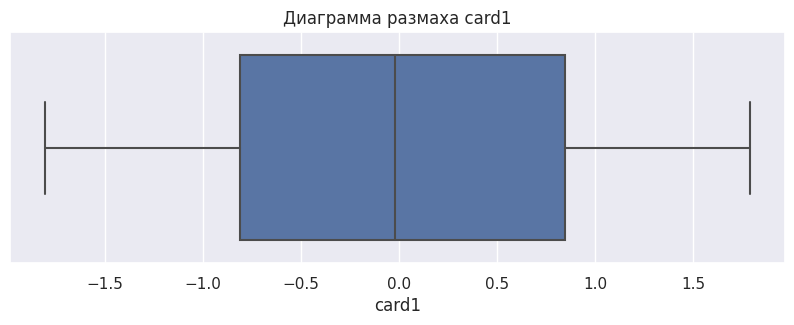

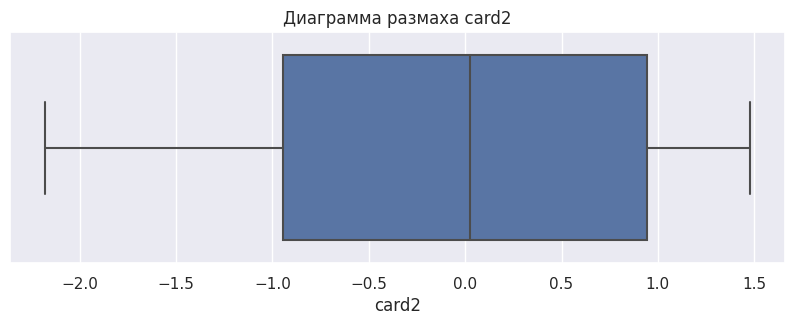

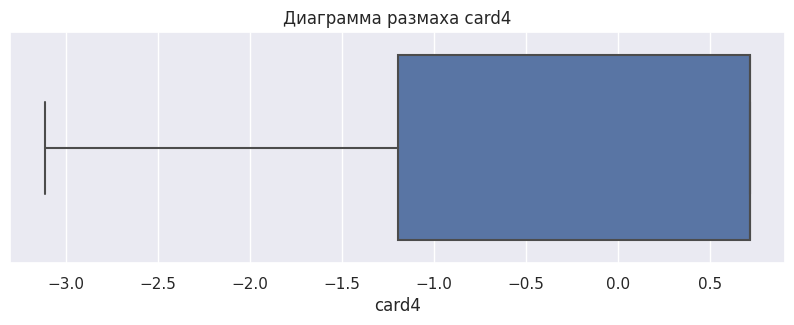

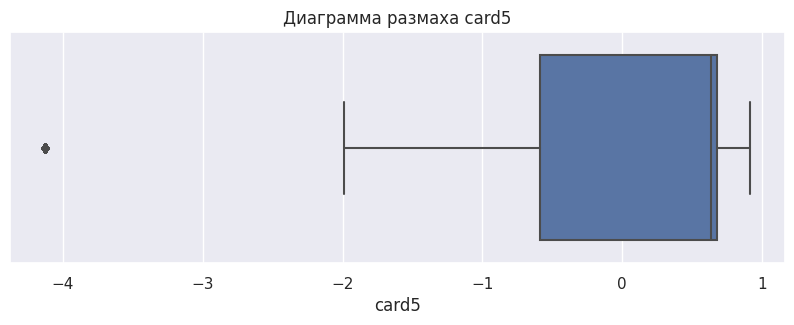

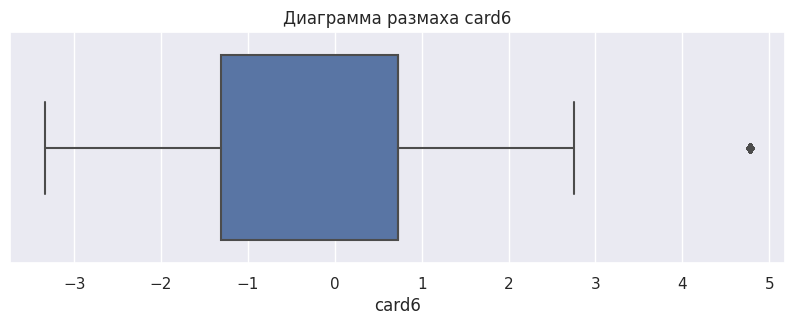

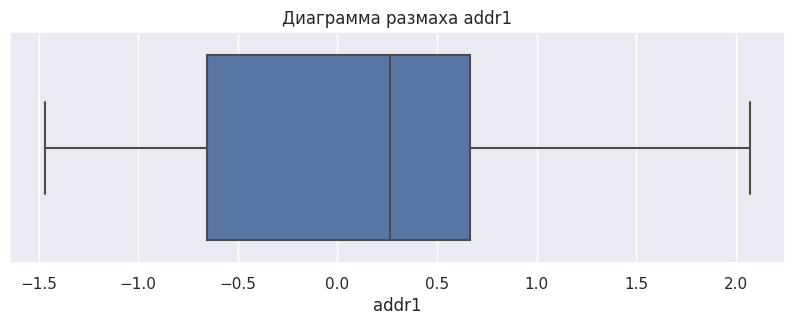

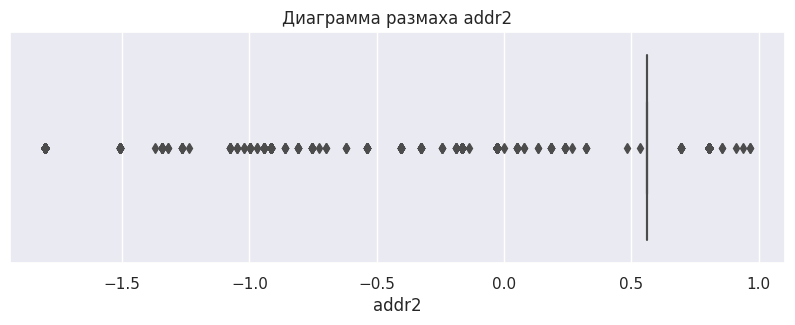

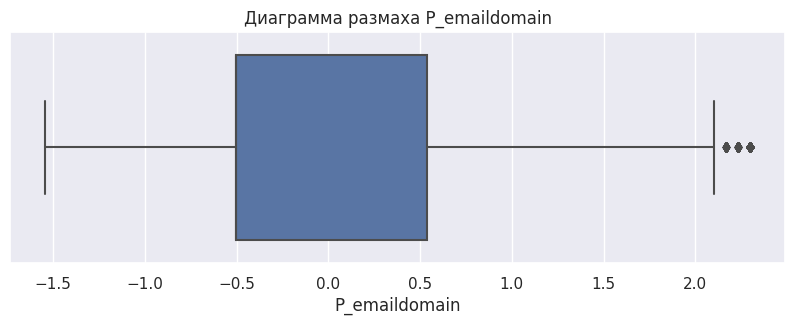

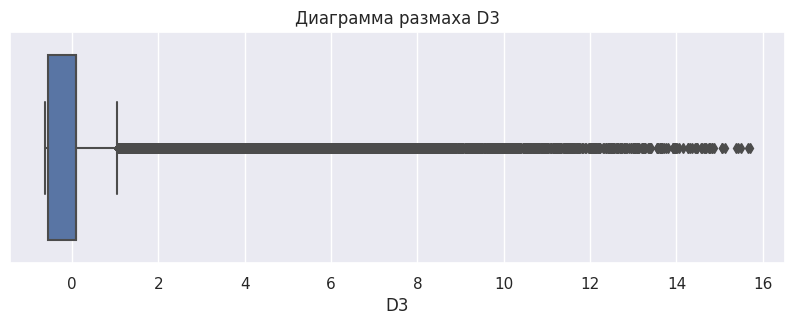

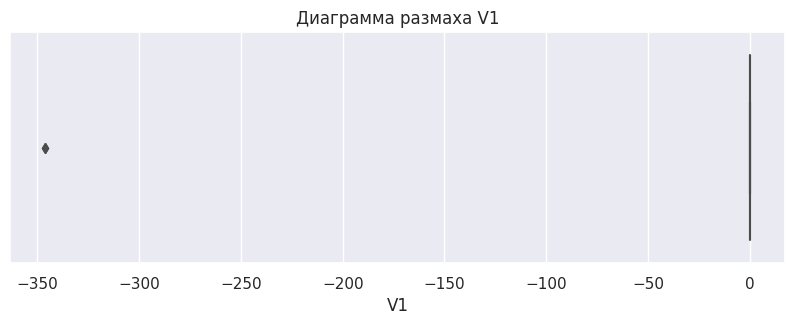

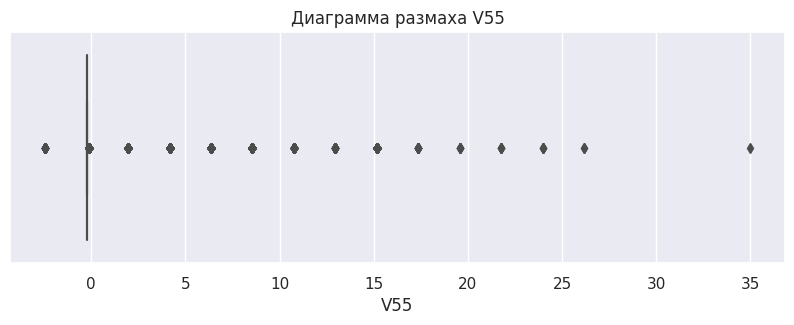

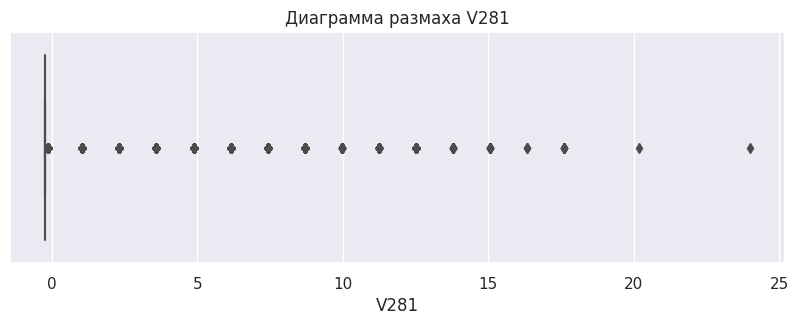

In [186]:
for feat in X_train_sc.columns:
    plt_boxplot(X_train_sc, feat)

Для валидационного датасета:

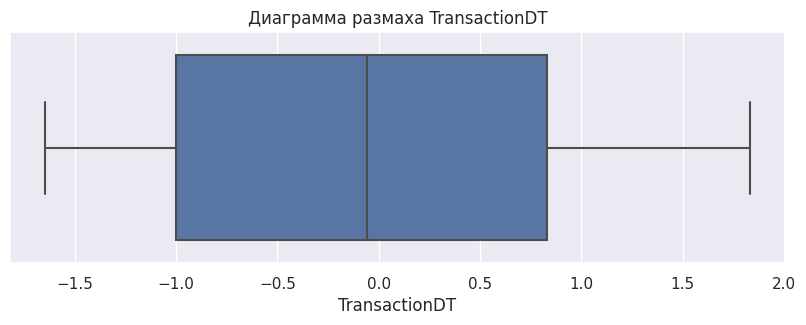

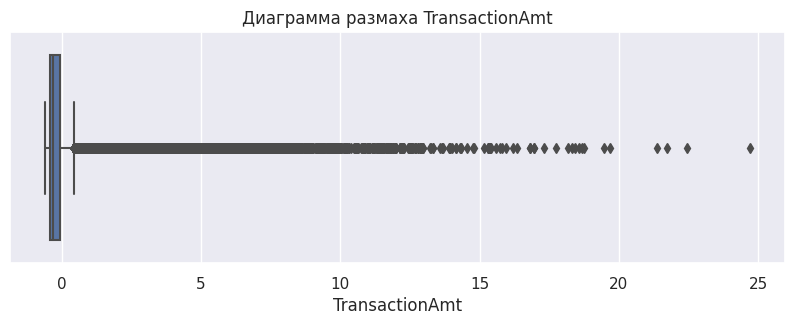

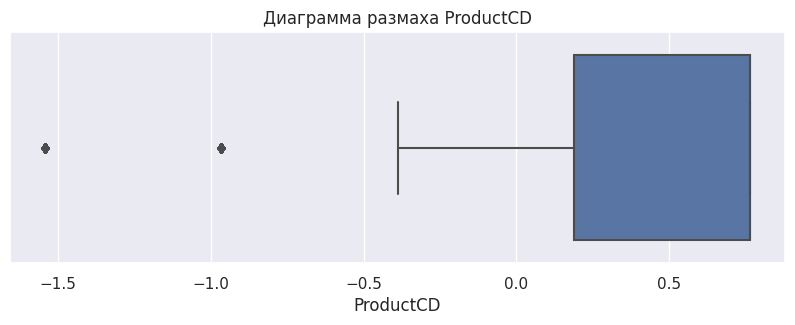

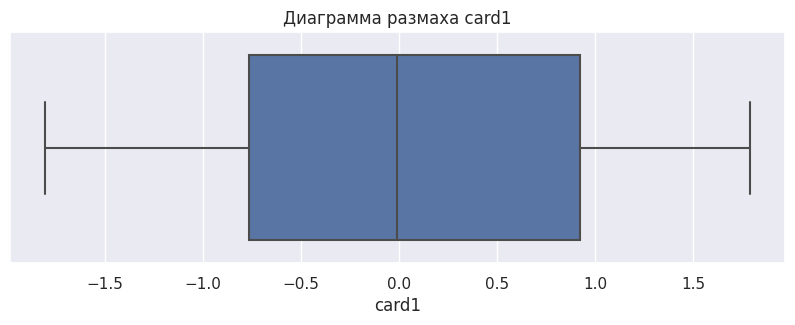

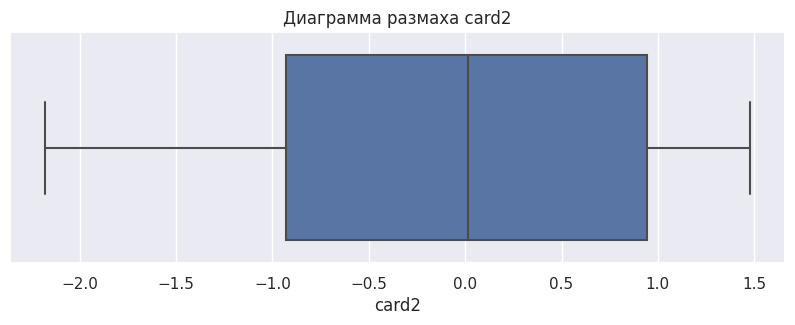

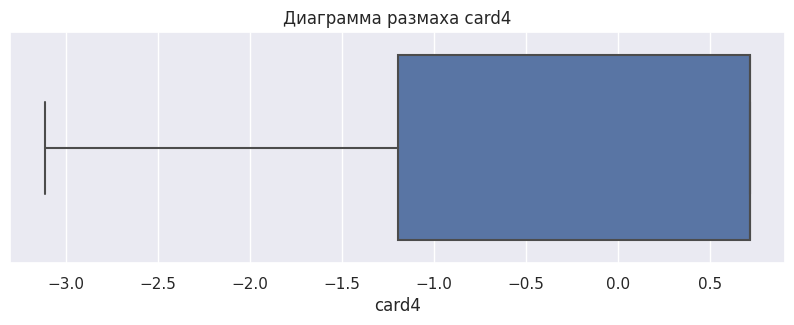

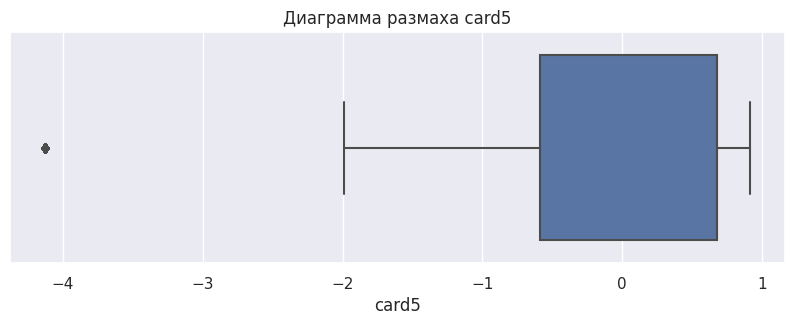

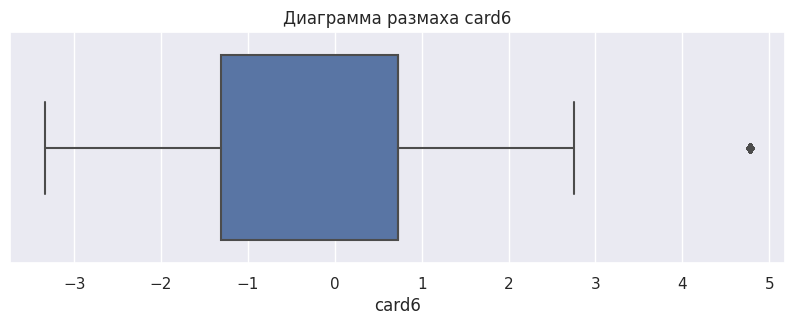

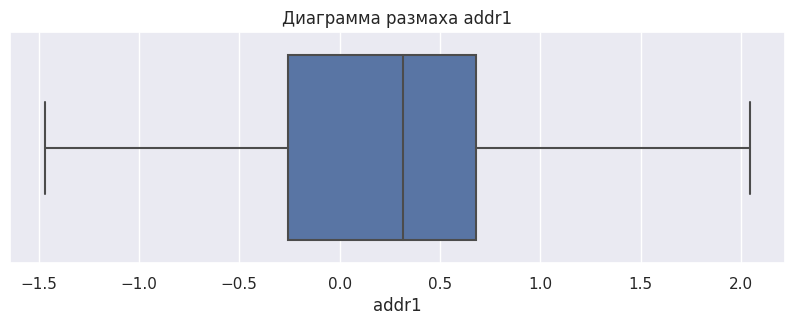

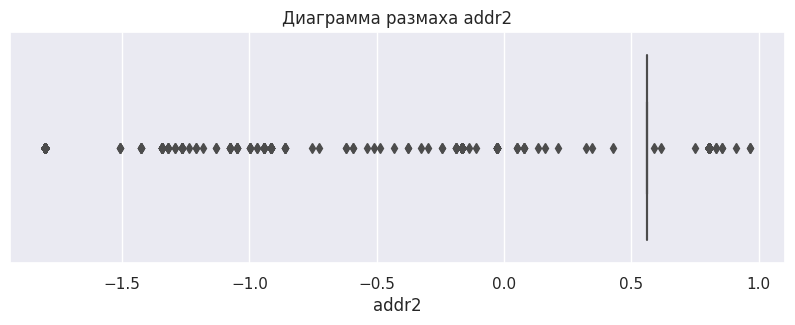

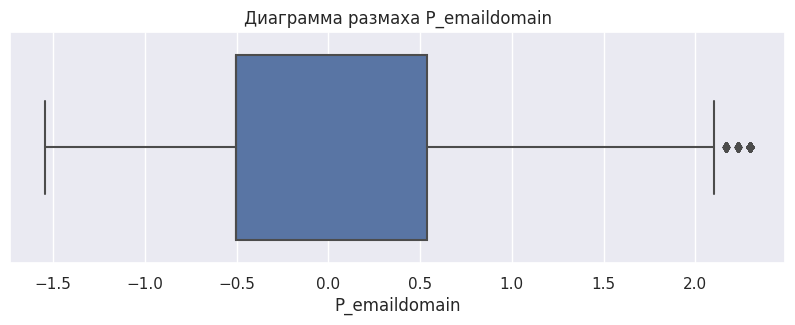

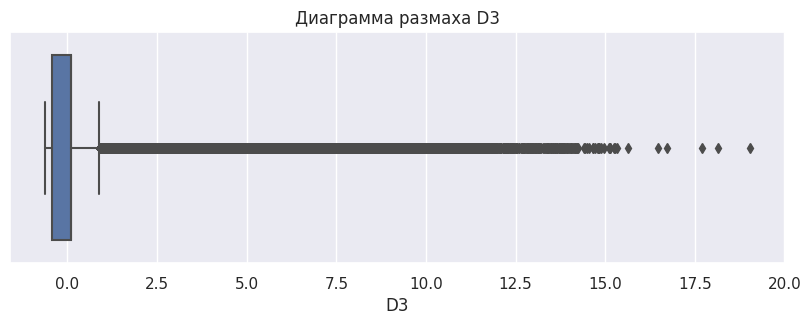

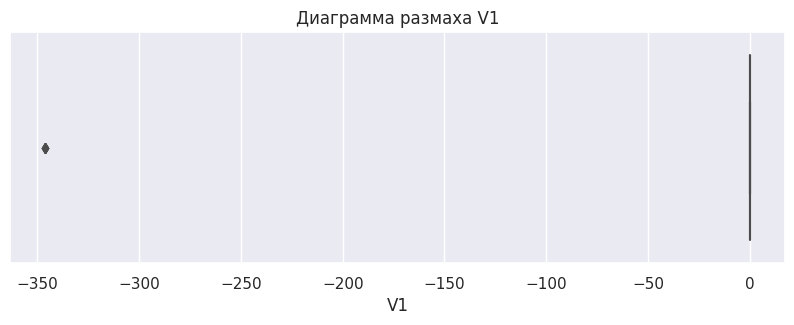

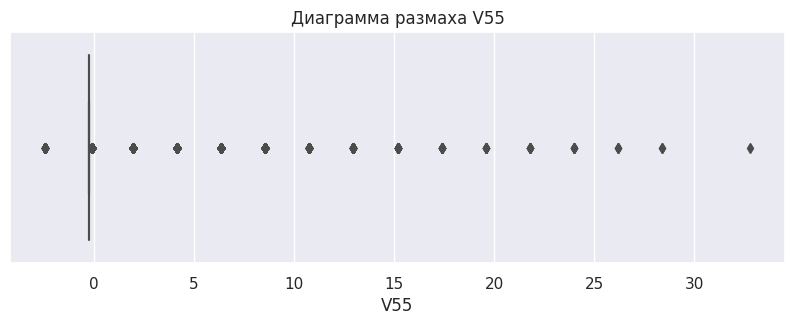

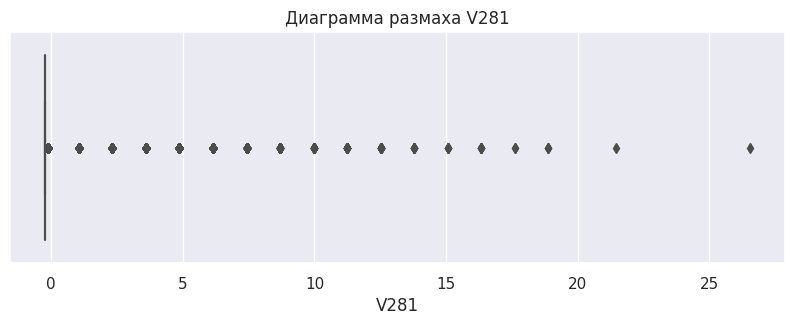

In [187]:
for feat in X_valid_sc.columns:
    plt_boxplot(X_valid_sc, feat)

Для тестового датасета

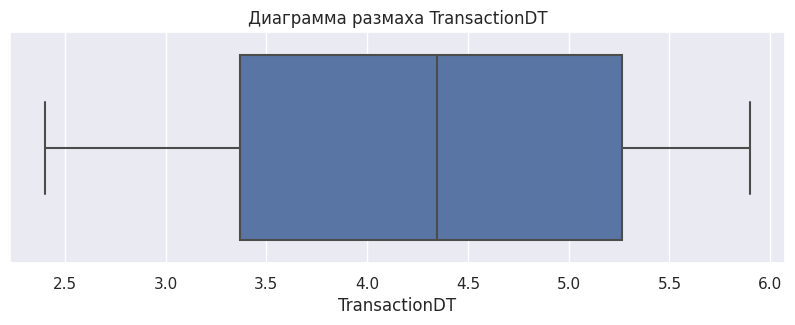

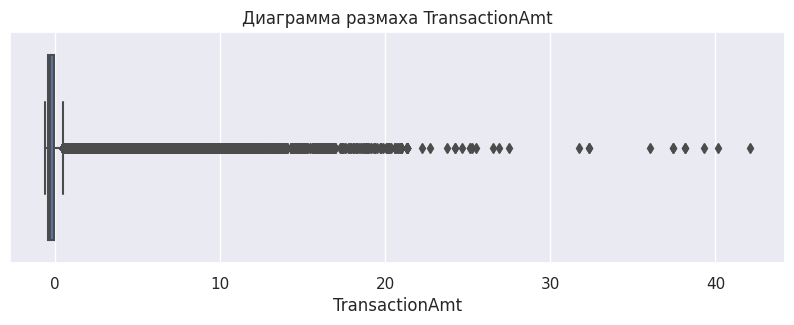

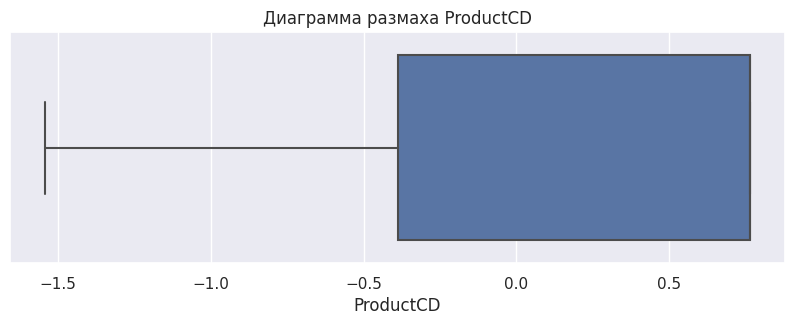

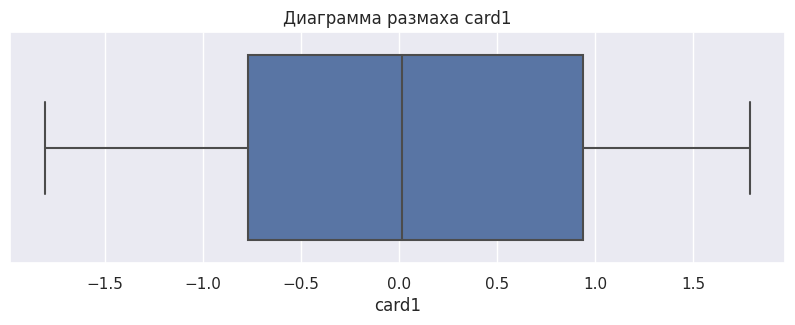

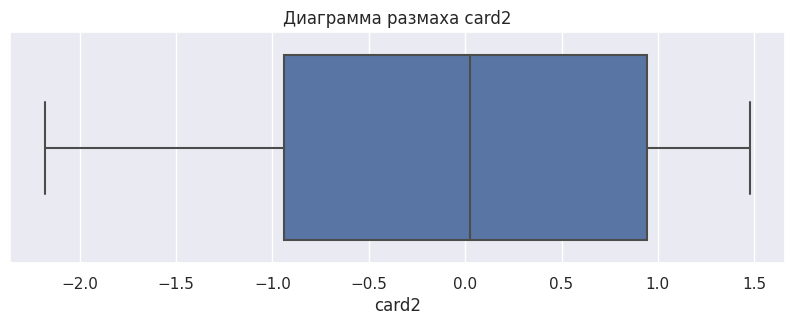

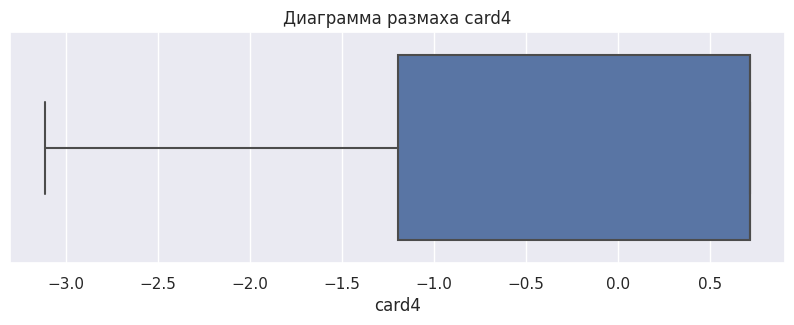

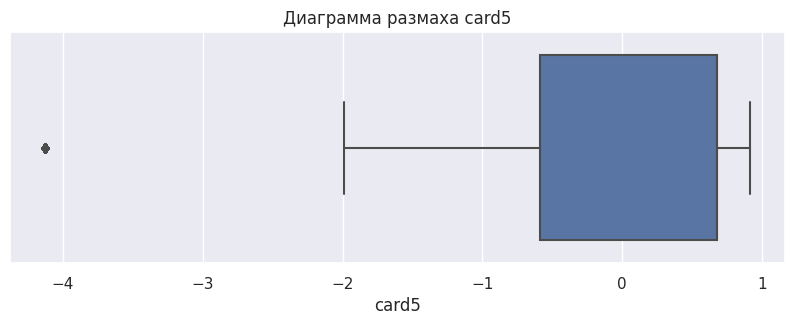

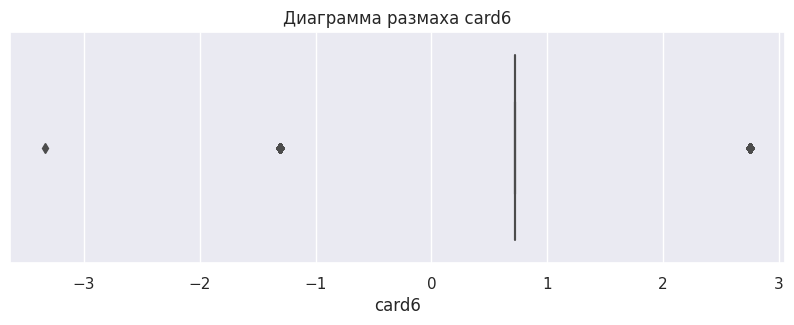

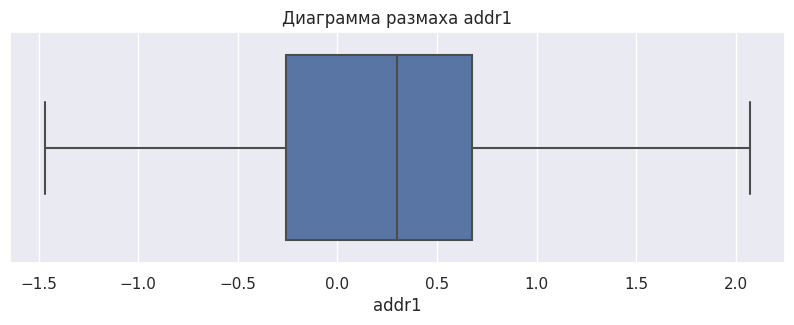

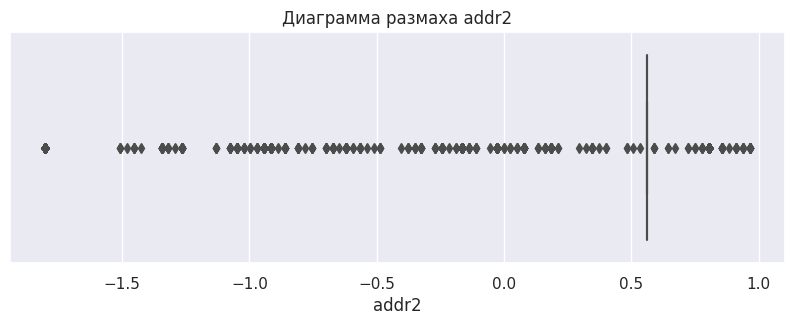

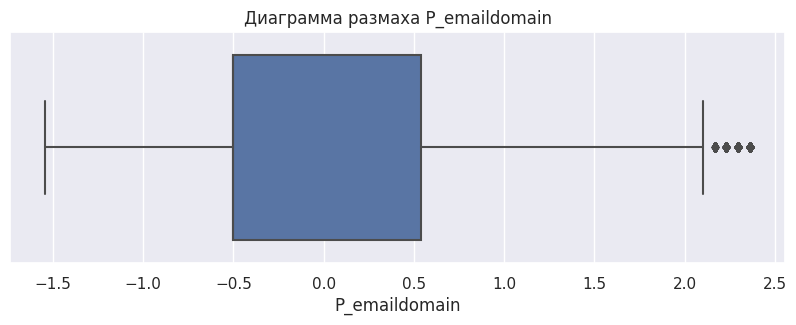

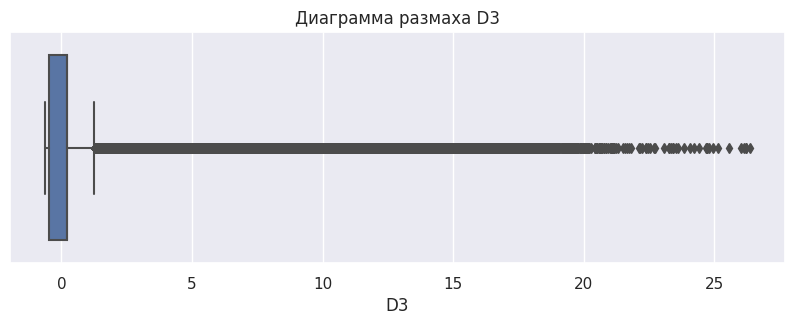

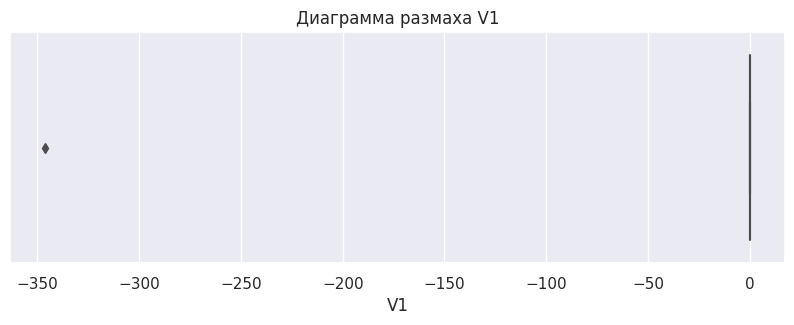

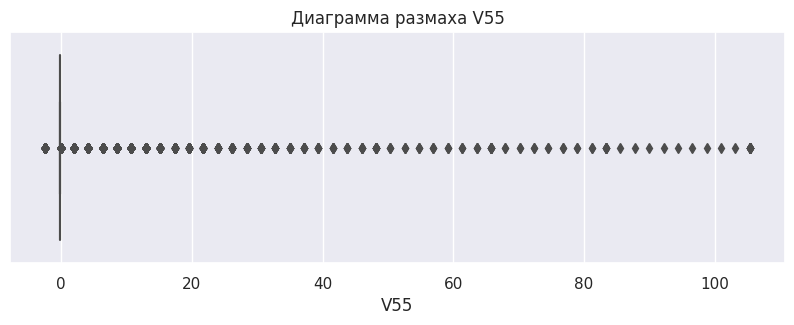

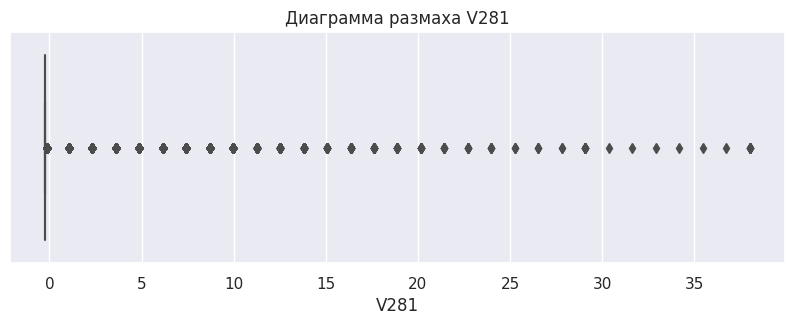

In [188]:
for feat in test_df_sc.columns:
    plt_boxplot(test_df_sc, feat)

Видим, что в признаках ```V1``` и ```V281``` очень много выбросов. Удалим эти признаки из данных

In [189]:
X_train_sc = X_train_sc.drop(columns=['V1', 'V281'])
X_valid_sc = X_valid_sc.drop(columns=['V1', 'V281'])
test_df_sc = test_df_sc.drop(columns=['V1', 'V281'])

In [190]:
X_train_sc

TransactionDT  TransactionAmt  ProductCD     card1     card2  \
184962      -0.754182       -0.343262   0.764772  1.499366  1.203163   
510418       1.290382       -0.347624   0.764772  1.734702  1.276167   
121172      -1.137010       -0.347624   0.764772  1.321469 -1.497995   
461070       0.952623       -0.172921  -0.965826  0.181773  1.373506   
329698       0.128026       -0.447128   0.764772 -0.048811 -0.220420   
...               ...             ...        ...       ...       ...   
229182      -0.464365       -0.509061  -1.542692  0.171855 -0.932212   
66399       -1.335012       -0.526066  -0.965826 -0.444481  1.190995   
276627      -0.178139       -0.546212  -1.542692  0.846251  0.108099   
683         -1.642945       -0.071781  -1.542692 -0.810812  0.308861   
131836      -1.087993       -0.002581   0.764772 -0.375472 -0.993049   

           card4     card5     card6     addr1     addr2  P_emaildomain  \
184962  0.714331  0.679743  0.721377 -0.257547  0.561576      -0.501521   
510418 -1.199469 -1.628247  0.721377 -0.126744  0.561576      -0.501521   
121172  0.714331  0.679743  0.721377  0.494569  0.561576      -0.501521   
461070  0.714331  0.679743 -1.305821  0.265664  0.561576      -0.046029   
329698  0.714331  0.679743  0.721377  0.697314  0.561576       0.409462   
...          ...       ...       ...       ...       ...            ...   
229182  0.714331  0.679743 -1.305821 -1.467472 -1.801624      -0.501521   
66399   0.714331  0.679743 -1.305821  0.743095  0.561576      -0.957012   
276627 -1.199469  0.637394  0.721377 -1.467472 -1.801624      -0.306310   
683    -1.199469  0.637394  0.721377 -1.467472 -1.801624      -0.501521   
131836 -1.199469  0.171561  0.721377  1.606393  0.561576      -0.501521   

              D3       V55  
184962 -0.469273 -0.239278  
510418 -0.369010 -0.239278  
121172 -0.444207 -0.239278  
461070  0.090272 -0.089083  
329698 -0.594602 -0.239278  
...          ...       ...  
229182  6.499029 -0.239278  
66399   0.090272 -0.089083  
276627 -0.619668 -0.239278  
683    -0.619668 -0.239278  
131836 -0.619668 -0.239278  

[239725 rows x 13 columns]

In [191]:
X_valid_sc

TransactionDT  TransactionAmt  ProductCD     card1     card2  \
587423       1.809678       -0.102292   0.764772  0.586948 -0.542856   
268070      -0.231764        0.574914   0.764772 -0.477127  1.130158   
85582       -1.264944       -0.417866  -1.542692  0.235493 -1.540581   
544807       1.515572       -0.347624   0.764772  1.342131  0.235856   
571901       1.692963        1.031925   0.764772  1.309692  0.953731   
...               ...             ...        ...       ...       ...   
30610       -1.495668        0.034811  -0.388960  0.638602  1.203163   
207146      -0.613348       -0.118952   0.764772 -0.700892 -0.183918   
393770       0.524038        0.078435   0.764772  0.531368  0.016844   
362875       0.322919        0.038965   0.764772 -0.984577 -0.804454   
121325      -1.136485        0.637026   0.764772  0.685297 -0.336010   

           card4     card5     card6     addr1     addr2  P_emaildomain  \
587423  0.714331 -0.590711  0.721377  1.652174  0.561576      -0.501521   
268070 -1.199469  0.637394  0.721377 -0.525692  0.561576      -0.501521   
85582   0.714331 -1.204763 -1.305821 -1.467472 -1.801624      -0.306310   
544807 -1.199469  0.637394  0.721377  0.599212  0.561576      -0.501521   
571901 -1.199469 -1.945861 -1.305821  0.599212  0.561576      -0.306310   
...          ...       ...       ...       ...       ...            ...   
30610   0.714331 -1.945861 -1.305821  2.044582  0.803267      -0.501521   
207146 -2.156369 -0.590711  0.721377  0.664613  0.561576       1.971148   
393770  0.714331 -0.590711  0.721377 -0.211766  0.561576      -0.306310   
362875 -1.199469 -1.628247  0.721377  0.494569  0.561576       1.971148   
121325  0.714331  0.679743  0.721377  0.743095  0.561576       1.971148   

               D3       V55  
587423  -0.594602 -0.239278  
268070  -0.318878  1.961155  
85582   -0.619668  4.161588  
544807  12.464698 -0.239278  
571901   0.091966 -0.239278  
...           ...       ...  
30610    0.091966 -0.093385  
207146   0.091966 -0.239278  
393770   0.091966 -0.239278  
362875   0.091966 -0.239278  
121325   0.809085 -0.239278  

[177162 rows x 13 columns]

In [192]:
test_df_sc

TransactionDT  TransactionAmt  ProductCD     card1     card2  \
0            2.403273       -0.455645   0.764772  0.139003 -1.497995   
1            2.403281       -0.384808   0.764772 -1.129002 -1.497995   
2            2.403292        0.122058   0.764772 -1.086852  1.318753   
3            2.403292        0.595480   0.764772  0.258841  0.016844   
4            2.403293       -0.306078   0.764772  1.711147  0.576543   
...               ...             ...        ...       ...       ...   
506686       5.898478       -0.195028  -1.542692  0.846251  0.108099   
506687       5.898479       -0.537811  -1.542692 -1.359999  0.308861   
506688       5.898488       -0.384808   0.764772  1.430769  0.807723   
506689       5.898490        0.250852   0.764772  1.422504  0.965899   
506690       5.898492       -0.487237  -1.542692 -0.831267 -1.151225   

           card4     card5     card6     addr1     addr2  P_emaildomain  \
0       0.714331  0.679743  0.721377 -0.349109  0.561576      -0.501521   
1       0.714331  0.679743  0.721377  0.494569  0.561576      -1.412504   
2       0.714331  0.679743  0.721377  1.626014  0.561576      -0.306310   
3       0.714331 -0.590711  0.721377 -0.120204  0.561576      -0.501521   
4      -1.199469 -1.628247  0.721377  0.265664  0.561576      -0.501521   
...          ...       ...       ...       ...       ...            ...   
506686 -1.199469  0.637394  0.721377  0.396467 -0.163497      -0.501521   
506687 -1.199469  0.637394  0.721377 -1.467472 -1.801624      -0.306310   
506688  0.714331  0.679743  0.721377  0.677693  0.561576      -0.306310   
506689 -1.199469  0.637394  0.721377 -0.303328  0.561576      -0.306310   
506690  0.714331 -0.993021 -1.305821 -1.467472 -1.801624      -0.306310   

              D3       V55  
0       0.057110 -0.239278  
1      -0.444207 -0.239278  
2      -0.369010 -0.239278  
3       0.408031 -0.239278  
4      -0.619668 -0.239278  
...          ...       ...  
506686  0.217399 -0.239278  
506687 -0.218615  1.961155  
506688  0.217399 -0.239278  
506689  0.217399 -0.239278  
506690  0.217399 -0.239278  

[506691 rows x 13 columns]

Также видим, что данные в тестовом датасете упорядочены по признаку ```TransactionDT```, а этот признак является одним из важных признаков при обучении, как видно в списках важности признаков, поэтому следует также упорядочить наши тренировочный и валидационный датасеты по этому признаку (так данные были изначально упорядочены, но они перемешались после всех обработок)

Временно соединим вместе данные с целевыми метками, чтобы не потерять порядок данных

In [193]:
data_sc = pd.concat([X_train_sc, y_train_balanced], axis=1)
data_sc

TransactionDT  TransactionAmt  ProductCD     card1     card2  \
184962      -0.754182       -0.343262   0.764772  1.499366  1.203163   
510418       1.290382       -0.347624   0.764772  1.734702  1.276167   
121172      -1.137010       -0.347624   0.764772  1.321469 -1.497995   
461070       0.952623       -0.172921  -0.965826  0.181773  1.373506   
329698       0.128026       -0.447128   0.764772 -0.048811 -0.220420   
...               ...             ...        ...       ...       ...   
229182      -0.464365       -0.509061  -1.542692  0.171855 -0.932212   
66399       -1.335012       -0.526066  -0.965826 -0.444481  1.190995   
276627      -0.178139       -0.546212  -1.542692  0.846251  0.108099   
683         -1.642945       -0.071781  -1.542692 -0.810812  0.308861   
131836      -1.087993       -0.002581   0.764772 -0.375472 -0.993049   

           card4     card5     card6     addr1     addr2  P_emaildomain  \
184962  0.714331  0.679743  0.721377 -0.257547  0.561576      -0.501521   
510418 -1.199469 -1.628247  0.721377 -0.126744  0.561576      -0.501521   
121172  0.714331  0.679743  0.721377  0.494569  0.561576      -0.501521   
461070  0.714331  0.679743 -1.305821  0.265664  0.561576      -0.046029   
329698  0.714331  0.679743  0.721377  0.697314  0.561576       0.409462   
...          ...       ...       ...       ...       ...            ...   
229182  0.714331  0.679743 -1.305821 -1.467472 -1.801624      -0.501521   
66399   0.714331  0.679743 -1.305821  0.743095  0.561576      -0.957012   
276627 -1.199469  0.637394  0.721377 -1.467472 -1.801624      -0.306310   
683    -1.199469  0.637394  0.721377 -1.467472 -1.801624      -0.501521   
131836 -1.199469  0.171561  0.721377  1.606393  0.561576      -0.501521   

              D3       V55  isFraud  
184962 -0.469273 -0.239278        0  
510418 -0.369010 -0.239278        0  
121172 -0.444207 -0.239278        0  
461070  0.090272 -0.089083        0  
329698 -0.594602 -0.239278        0  
...          ...       ...      ...  
229182  6.499029 -0.239278        1  
66399   0.090272 -0.089083        1  
276627 -0.619668 -0.239278        1  
683    -0.619668 -0.239278        1  
131836 -0.619668 -0.239278        1  

[239725 rows x 14 columns]

In [194]:
data_sc = data_sc.sort_values('TransactionDT')
data_sc

TransactionDT  TransactionAmt  ProductCD     card1     card2  \
5           -1.645835       -0.384808   0.764772 -0.784985  1.203163   
6           -1.645833        0.072203   0.764772  0.531368  0.016844   
10          -1.645827       -0.273102  -1.542692  1.396677 -0.031826   
18          -1.645788       -0.389170   0.764772 -1.048215  0.807723   
23          -1.645770       -0.139892   0.764772 -1.517440  0.016844   
...               ...             ...        ...       ...       ...   
590526       1.830206        0.450275  -0.388960 -1.760835 -1.114722   
590528       1.830213        0.574707   0.764772  1.101216 -1.139057   
590533       1.830240       -0.139892   0.764772  0.689016 -0.220420   
590536       1.830244       -0.424277   0.764772  0.146235 -0.804454   
590537       1.830251       -0.459799   0.764772  0.475375  1.446510   

           card4     card5     card6     addr1     addr2  P_emaildomain  \
5       0.714331  0.679743  0.721377  0.317986  0.561576      -0.501521   
6       0.714331 -0.590711  0.721377 -0.636875  0.561576       1.971148   
10     -1.199469 -1.268286 -1.305821 -1.467472 -1.801624      -0.501521   
18      0.714331 -0.590711  0.721377 -0.257547  0.561576      -0.501521   
23     -1.199469 -0.590711  0.721377 -0.636875  0.561576      -0.501521   
...          ...       ...       ...       ...       ...            ...   
590526  0.714331  0.679743 -1.305821  0.317986  0.561576      -0.501521   
590528 -1.199469 -1.945861 -1.305821  0.494569  0.561576      -0.501521   
590533  0.714331  0.679743  0.721377  1.711035  0.561576      -0.501521   
590536 -1.199469  0.637394  0.721377 -0.126744  0.561576      -0.501521   
590537 -1.199469  0.637394  0.721377  0.049840  0.561576      -0.501521   

              D3       V55  isFraud  
5       0.090272 -0.239278        0  
6       0.090272 -0.239278        0  
10     -0.619668  6.362021        0  
18      0.090272 -0.239278        0  
23      0.090272 -0.239278        0  
...          ...       ...      ...  
590526  0.090272 -0.089083        1  
590528  0.090272 -0.239278        0  
590533 -0.469273 -0.239278        0  
590536  0.090272 -0.239278        0  
590537  0.090272 -0.239278        0  

[239725 rows x 14 columns]

Проделаем то же самое для валидационного датасета

In [195]:
valid_data_sc = pd.concat([X_valid_sc, y_valid], axis=1)
valid_data_sc

TransactionDT  TransactionAmt  ProductCD     card1     card2  \
587423       1.809678       -0.102292   0.764772  0.586948 -0.542856   
268070      -0.231764        0.574914   0.764772 -0.477127  1.130158   
85582       -1.264944       -0.417866  -1.542692  0.235493 -1.540581   
544807       1.515572       -0.347624   0.764772  1.342131  0.235856   
571901       1.692963        1.031925   0.764772  1.309692  0.953731   
...               ...             ...        ...       ...       ...   
30610       -1.495668        0.034811  -0.388960  0.638602  1.203163   
207146      -0.613348       -0.118952   0.764772 -0.700892 -0.183918   
393770       0.524038        0.078435   0.764772  0.531368  0.016844   
362875       0.322919        0.038965   0.764772 -0.984577 -0.804454   
121325      -1.136485        0.637026   0.764772  0.685297 -0.336010   

           card4     card5     card6     addr1     addr2  P_emaildomain  \
587423  0.714331 -0.590711  0.721377  1.652174  0.561576      -0.501521   
268070 -1.199469  0.637394  0.721377 -0.525692  0.561576      -0.501521   
85582   0.714331 -1.204763 -1.305821 -1.467472 -1.801624      -0.306310   
544807 -1.199469  0.637394  0.721377  0.599212  0.561576      -0.501521   
571901 -1.199469 -1.945861 -1.305821  0.599212  0.561576      -0.306310   
...          ...       ...       ...       ...       ...            ...   
30610   0.714331 -1.945861 -1.305821  2.044582  0.803267      -0.501521   
207146 -2.156369 -0.590711  0.721377  0.664613  0.561576       1.971148   
393770  0.714331 -0.590711  0.721377 -0.211766  0.561576      -0.306310   
362875 -1.199469 -1.628247  0.721377  0.494569  0.561576       1.971148   
121325  0.714331  0.679743  0.721377  0.743095  0.561576       1.971148   

               D3       V55  isFraud  
587423  -0.594602 -0.239278        0  
268070  -0.318878  1.961155        0  
85582   -0.619668  4.161588        0  
544807  12.464698 -0.239278        0  
571901   0.091966 -0.239278        0  
...           ...       ...      ...  
30610    0.091966 -0.093385        0  
207146   0.091966 -0.239278        0  
393770   0.091966 -0.239278        0  
362875   0.091966 -0.239278        0  
121325   0.809085 -0.239278        0  

[177162 rows x 14 columns]

In [196]:
valid_data_sc = valid_data_sc.sort_values('TransactionDT')
valid_data_sc

TransactionDT  TransactionAmt  ProductCD     card1     card2  \
0           -1.645860       -0.303792   0.764772  0.865673 -2.179368   
2           -1.645845       -0.343262   0.764772 -1.048215  0.807723   
3           -1.645838       -0.380653   0.764772  1.734702  1.276167   
4           -1.645836       -0.380653  -0.965826 -1.082513  0.953731   
11          -1.645826       -0.519855  -1.542692 -1.089951  0.108099   
...               ...             ...        ...       ...       ...   
590530       1.830217        1.076712   0.764772  1.101216 -1.139057   
590531       1.830219        1.073471  -0.388960 -0.768043  1.373506   
590532       1.830235        0.263191   0.764772  0.475375  1.446510   
590534       1.830240       -0.307926  -1.542692 -0.810812  0.308861   
590538       1.830253       -0.102292   0.764772 -0.394687  0.752970   

           card4     card5     card6     addr1     addr2  P_emaildomain  \
0      -2.156369 -1.098892 -1.305821  0.599212  0.561576       0.539603   
2       0.714331 -0.590711  0.721377  0.697314  0.561576       0.799884   
3      -1.199469 -1.628247  0.721377  1.652174  0.561576       1.971148   
4      -1.199469 -1.945861 -1.305821  1.285926  0.561576      -0.501521   
11     -1.199469  0.637394  0.721377 -1.467472 -1.801624      -0.306310   
...          ...       ...       ...       ...       ...            ...   
590530 -1.199469 -1.945861 -1.305821  0.494569  0.561576       1.971148   
590531  0.714331  0.679743 -1.305821  0.743095  0.561576      -0.501521   
590532 -1.199469  0.637394  0.721377  0.049840  0.561576       0.734814   
590534 -1.199469  0.637394  0.721377 -1.467472 -1.801624      -0.501521   
590538 -1.199469  0.637394  0.721377  1.070102  0.561576      -1.412504   

              D3       V55  isFraud  
0      -0.293812 -0.239278        0  
2       0.091966 -0.239278        0  
3      -0.619668 -0.239278        0  
4       0.091966 -0.093385        0  
11      0.091966 -0.239278        0  
...          ...       ...      ...  
590530  0.091966 -0.239278        0  
590531  0.091966 -0.093385        0  
590532  7.276070 -0.239278        0  
590534  0.091966 -0.239278        0  
590538 -0.619668 -0.239278        0  

[177162 rows x 14 columns]

Напишем функцию для отбора данных от выбросов

In [197]:
def data_without_feat_emsns(df, feature):
    first_qrt = df[feature].describe()['25%']
    third_qrt = df[feature].describe()['75%']
    iqr = third_qrt - first_qrt
    
    condition = (df[feature] > (first_qrt - 3 * iqr)) & \
    (df[feature] < (third_qrt + 3 * iqr))
    
    df = df[condition]
    return df

In [198]:
num_feats = [feat for feat in num_feats if feat in data_sc.columns]
num_feats

['TransactionDT', 'TransactionAmt', 'D3', 'V55']

In [199]:
train_sc_no_emsms = data_without_feat_emsns(data_sc, 'TransactionAmt')
# train_sc_no_emsms = data_without_feat_emsns(train_sc_no_emsms, 'D3')
# train_sc_no_emsms = data_without_feat_emsns(train_sc_no_emsms, 'V55')
train_sc_no_emsms

TransactionDT  TransactionAmt  ProductCD     card1     card2  \
5           -1.645835       -0.384808   0.764772 -0.784985  1.203163   
6           -1.645833        0.072203   0.764772  0.531368  0.016844   
10          -1.645827       -0.273102  -1.542692  1.396677 -0.031826   
18          -1.645788       -0.389170   0.764772 -1.048215  0.807723   
23          -1.645770       -0.139892   0.764772 -1.517440  0.016844   
...               ...             ...        ...       ...       ...   
590526       1.830206        0.450275  -0.388960 -1.760835 -1.114722   
590528       1.830213        0.574707   0.764772  1.101216 -1.139057   
590533       1.830240       -0.139892   0.764772  0.689016 -0.220420   
590536       1.830244       -0.424277   0.764772  0.146235 -0.804454   
590537       1.830251       -0.459799   0.764772  0.475375  1.446510   

           card4     card5     card6     addr1     addr2  P_emaildomain  \
5       0.714331  0.679743  0.721377  0.317986  0.561576      -0.501521   
6       0.714331 -0.590711  0.721377 -0.636875  0.561576       1.971148   
10     -1.199469 -1.268286 -1.305821 -1.467472 -1.801624      -0.501521   
18      0.714331 -0.590711  0.721377 -0.257547  0.561576      -0.501521   
23     -1.199469 -0.590711  0.721377 -0.636875  0.561576      -0.501521   
...          ...       ...       ...       ...       ...            ...   
590526  0.714331  0.679743 -1.305821  0.317986  0.561576      -0.501521   
590528 -1.199469 -1.945861 -1.305821  0.494569  0.561576      -0.501521   
590533  0.714331  0.679743  0.721377  1.711035  0.561576      -0.501521   
590536 -1.199469  0.637394  0.721377 -0.126744  0.561576      -0.501521   
590537 -1.199469  0.637394  0.721377  0.049840  0.561576      -0.501521   

              D3       V55  isFraud  
5       0.090272 -0.239278        0  
6       0.090272 -0.239278        0  
10     -0.619668  6.362021        0  
18      0.090272 -0.239278        0  
23      0.090272 -0.239278        0  
...          ...       ...      ...  
590526  0.090272 -0.089083        1  
590528  0.090272 -0.239278        0  
590533 -0.469273 -0.239278        0  
590536  0.090272 -0.239278        0  
590537  0.090272 -0.239278        0  

[227931 rows x 14 columns]

In [200]:
valid_sc_no_emsms = data_without_feat_emsns(valid_data_sc, 'TransactionAmt')
# valid_sc_no_emsms = data_without_feat_emsns(valid_sc_no_emsms, 'D3')
valid_sc_no_emsms

TransactionDT  TransactionAmt  ProductCD     card1     card2  \
0           -1.645860       -0.303792   0.764772  0.865673 -2.179368   
2           -1.645845       -0.343262   0.764772 -1.048215  0.807723   
3           -1.645838       -0.380653   0.764772  1.734702  1.276167   
4           -1.645836       -0.380653  -0.965826 -1.082513  0.953731   
11          -1.645826       -0.519855  -1.542692 -1.089951  0.108099   
...               ...             ...        ...       ...       ...   
590524       1.830197       -0.276787   0.764772 -0.394687  0.752970   
590527       1.830208        0.200789   0.764772 -0.678371  1.203163   
590532       1.830235        0.263191   0.764772  0.475375  1.446510   
590534       1.830240       -0.307926  -1.542692 -0.810812  0.308861   
590538       1.830253       -0.102292   0.764772 -0.394687  0.752970   

           card4     card5     card6     addr1     addr2  P_emaildomain  \
0      -2.156369 -1.098892 -1.305821  0.599212  0.561576       0.539603   
2       0.714331 -0.590711  0.721377  0.697314  0.561576       0.799884   
3      -1.199469 -1.628247  0.721377  1.652174  0.561576       1.971148   
4      -1.199469 -1.945861 -1.305821  1.285926  0.561576      -0.501521   
11     -1.199469  0.637394  0.721377 -1.467472 -1.801624      -0.306310   
...          ...       ...       ...       ...       ...            ...   
590524 -1.199469  0.637394  0.721377  1.070102  0.561576      -0.501521   
590527  0.714331  0.679743  0.721377  0.265664  0.561576      -1.412504   
590532 -1.199469  0.637394  0.721377  0.049840  0.561576       0.734814   
590534 -1.199469  0.637394  0.721377 -1.467472 -1.801624      -0.501521   
590538 -1.199469  0.637394  0.721377  1.070102  0.561576      -1.412504   

              D3       V55  isFraud  
0      -0.293812 -0.239278        0  
2       0.091966 -0.239278        0  
3      -0.619668 -0.239278        0  
4       0.091966 -0.093385        0  
11      0.091966 -0.239278        0  
...          ...       ...      ...  
590524  0.091966 -0.239278        0  
590527 -0.469273 -0.239278        0  
590532  7.276070 -0.239278        0  
590534  0.091966 -0.239278        0  
590538 -0.619668 -0.239278        0  

[166075 rows x 14 columns]

Снова выполним упорядочивание данных по признаку ```TransactionDT```

In [201]:
train_sc_no_emsms = train_sc_no_emsms.sort_values('TransactionDT')
train_sc_no_emsms

TransactionDT  TransactionAmt  ProductCD     card1     card2  \
5           -1.645835       -0.384808   0.764772 -0.784985  1.203163   
6           -1.645833        0.072203   0.764772  0.531368  0.016844   
10          -1.645827       -0.273102  -1.542692  1.396677 -0.031826   
18          -1.645788       -0.389170   0.764772 -1.048215  0.807723   
23          -1.645770       -0.139892   0.764772 -1.517440  0.016844   
...               ...             ...        ...       ...       ...   
590526       1.830206        0.450275  -0.388960 -1.760835 -1.114722   
590528       1.830213        0.574707   0.764772  1.101216 -1.139057   
590533       1.830240       -0.139892   0.764772  0.689016 -0.220420   
590536       1.830244       -0.424277   0.764772  0.146235 -0.804454   
590537       1.830251       -0.459799   0.764772  0.475375  1.446510   

           card4     card5     card6     addr1     addr2  P_emaildomain  \
5       0.714331  0.679743  0.721377  0.317986  0.561576      -0.501521   
6       0.714331 -0.590711  0.721377 -0.636875  0.561576       1.971148   
10     -1.199469 -1.268286 -1.305821 -1.467472 -1.801624      -0.501521   
18      0.714331 -0.590711  0.721377 -0.257547  0.561576      -0.501521   
23     -1.199469 -0.590711  0.721377 -0.636875  0.561576      -0.501521   
...          ...       ...       ...       ...       ...            ...   
590526  0.714331  0.679743 -1.305821  0.317986  0.561576      -0.501521   
590528 -1.199469 -1.945861 -1.305821  0.494569  0.561576      -0.501521   
590533  0.714331  0.679743  0.721377  1.711035  0.561576      -0.501521   
590536 -1.199469  0.637394  0.721377 -0.126744  0.561576      -0.501521   
590537 -1.199469  0.637394  0.721377  0.049840  0.561576      -0.501521   

              D3       V55  isFraud  
5       0.090272 -0.239278        0  
6       0.090272 -0.239278        0  
10     -0.619668  6.362021        0  
18      0.090272 -0.239278        0  
23      0.090272 -0.239278        0  
...          ...       ...      ...  
590526  0.090272 -0.089083        1  
590528  0.090272 -0.239278        0  
590533 -0.469273 -0.239278        0  
590536  0.090272 -0.239278        0  
590537  0.090272 -0.239278        0  

[227931 rows x 14 columns]

In [202]:
valid_sc_no_emsms = valid_sc_no_emsms.sort_values('TransactionDT')
valid_sc_no_emsms

TransactionDT  TransactionAmt  ProductCD     card1     card2  \
0           -1.645860       -0.303792   0.764772  0.865673 -2.179368   
2           -1.645845       -0.343262   0.764772 -1.048215  0.807723   
3           -1.645838       -0.380653   0.764772  1.734702  1.276167   
4           -1.645836       -0.380653  -0.965826 -1.082513  0.953731   
11          -1.645826       -0.519855  -1.542692 -1.089951  0.108099   
...               ...             ...        ...       ...       ...   
590524       1.830197       -0.276787   0.764772 -0.394687  0.752970   
590527       1.830208        0.200789   0.764772 -0.678371  1.203163   
590532       1.830235        0.263191   0.764772  0.475375  1.446510   
590534       1.830240       -0.307926  -1.542692 -0.810812  0.308861   
590538       1.830253       -0.102292   0.764772 -0.394687  0.752970   

           card4     card5     card6     addr1     addr2  P_emaildomain  \
0      -2.156369 -1.098892 -1.305821  0.599212  0.561576       0.539603   
2       0.714331 -0.590711  0.721377  0.697314  0.561576       0.799884   
3      -1.199469 -1.628247  0.721377  1.652174  0.561576       1.971148   
4      -1.199469 -1.945861 -1.305821  1.285926  0.561576      -0.501521   
11     -1.199469  0.637394  0.721377 -1.467472 -1.801624      -0.306310   
...          ...       ...       ...       ...       ...            ...   
590524 -1.199469  0.637394  0.721377  1.070102  0.561576      -0.501521   
590527  0.714331  0.679743  0.721377  0.265664  0.561576      -1.412504   
590532 -1.199469  0.637394  0.721377  0.049840  0.561576       0.734814   
590534 -1.199469  0.637394  0.721377 -1.467472 -1.801624      -0.501521   
590538 -1.199469  0.637394  0.721377  1.070102  0.561576      -1.412504   

              D3       V55  isFraud  
0      -0.293812 -0.239278        0  
2       0.091966 -0.239278        0  
3      -0.619668 -0.239278        0  
4       0.091966 -0.093385        0  
11      0.091966 -0.239278        0  
...          ...       ...      ...  
590524  0.091966 -0.239278        0  
590527 -0.469273 -0.239278        0  
590532  7.276070 -0.239278        0  
590534  0.091966 -0.239278        0  
590538 -0.619668 -0.239278        0  

[166075 rows x 14 columns]

Теперь можно снова отделить данные от целевых меток

In [203]:
y_train_no_ems = train_sc_no_emsms['isFraud']
X_train_no_ems = train_sc_no_emsms.drop(columns=['isFraud'])

In [204]:
print(y_train_no_ems.shape)
print(X_train_no_ems.shape)

(227931,)
(227931, 13)


In [205]:
y_valid_no_ems = valid_sc_no_emsms['isFraud']
X_valid_no_ems = valid_sc_no_emsms.drop(columns=['isFraud'])
print(y_valid_no_ems.shape)
print(X_valid_no_ems.shape)

(166075,)
(166075, 13)


Посмотрим на распределения данных и boxplotы после очистки данных от выбросов

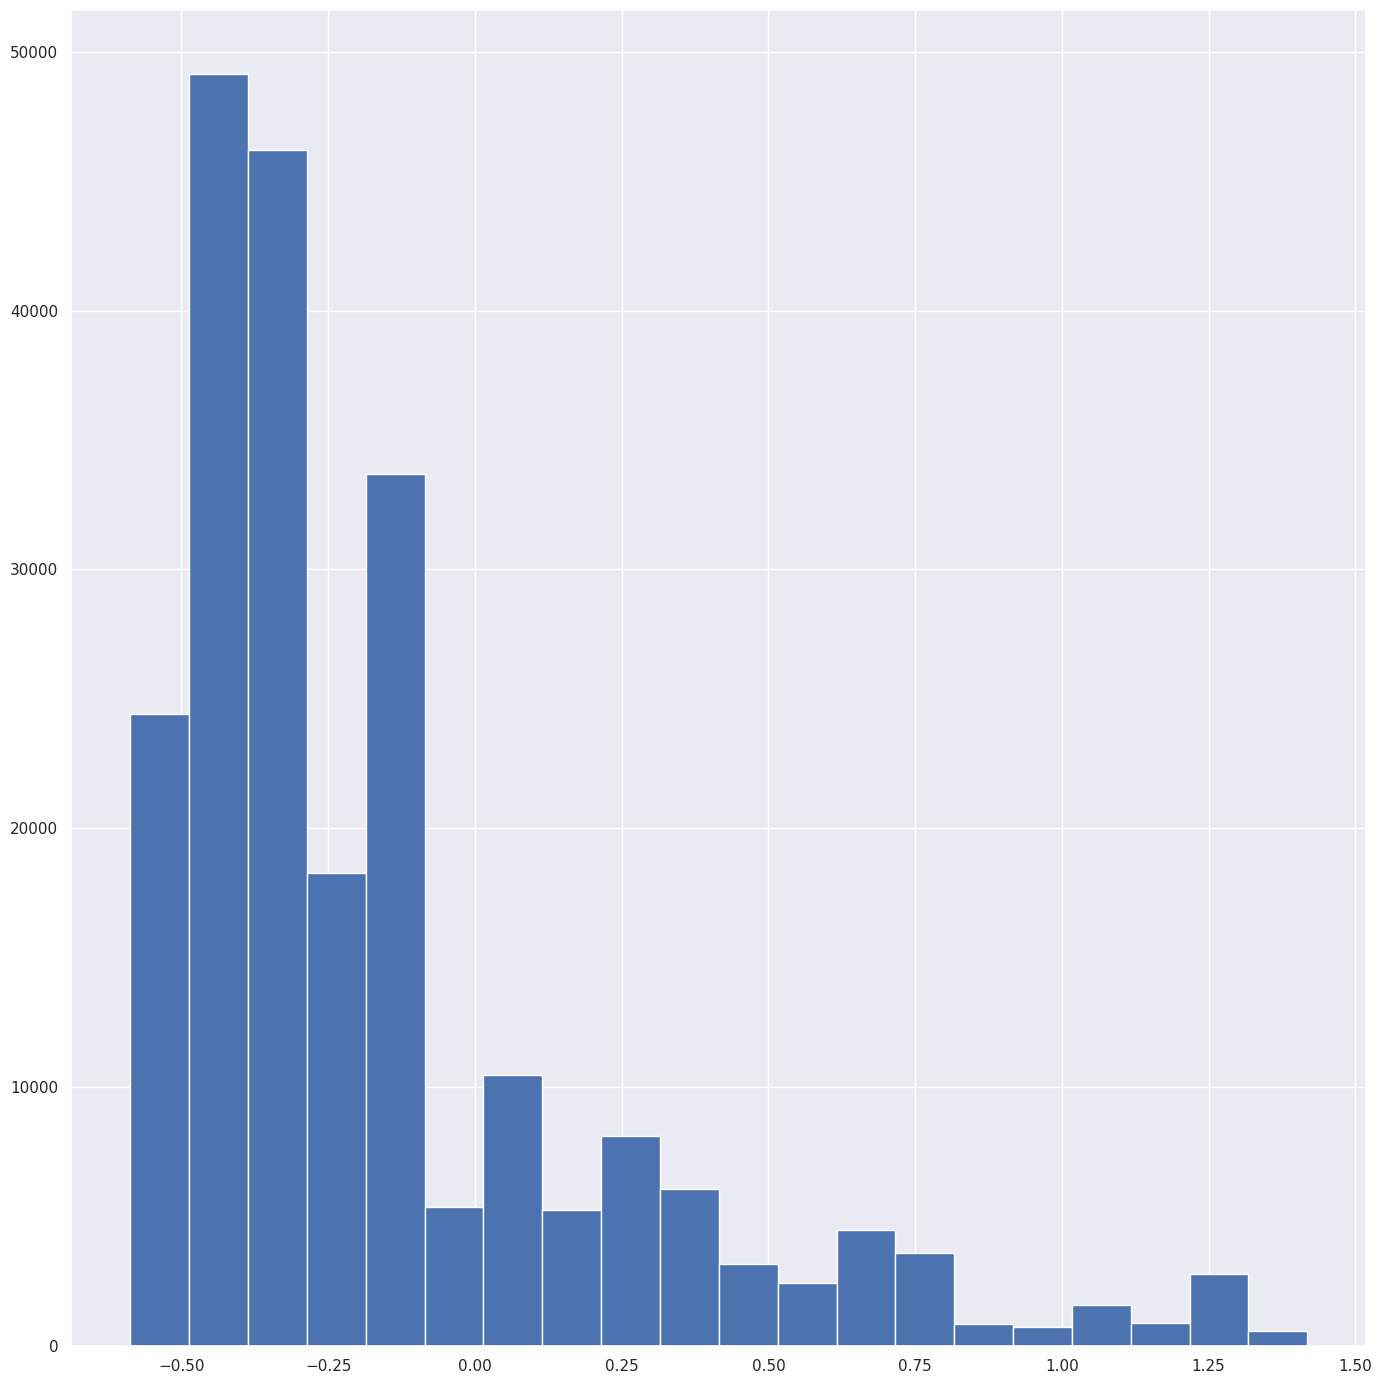

In [206]:
X_train_no_ems['TransactionAmt'].hist(bins=20, figsize=(14,14))
plt.tight_layout()

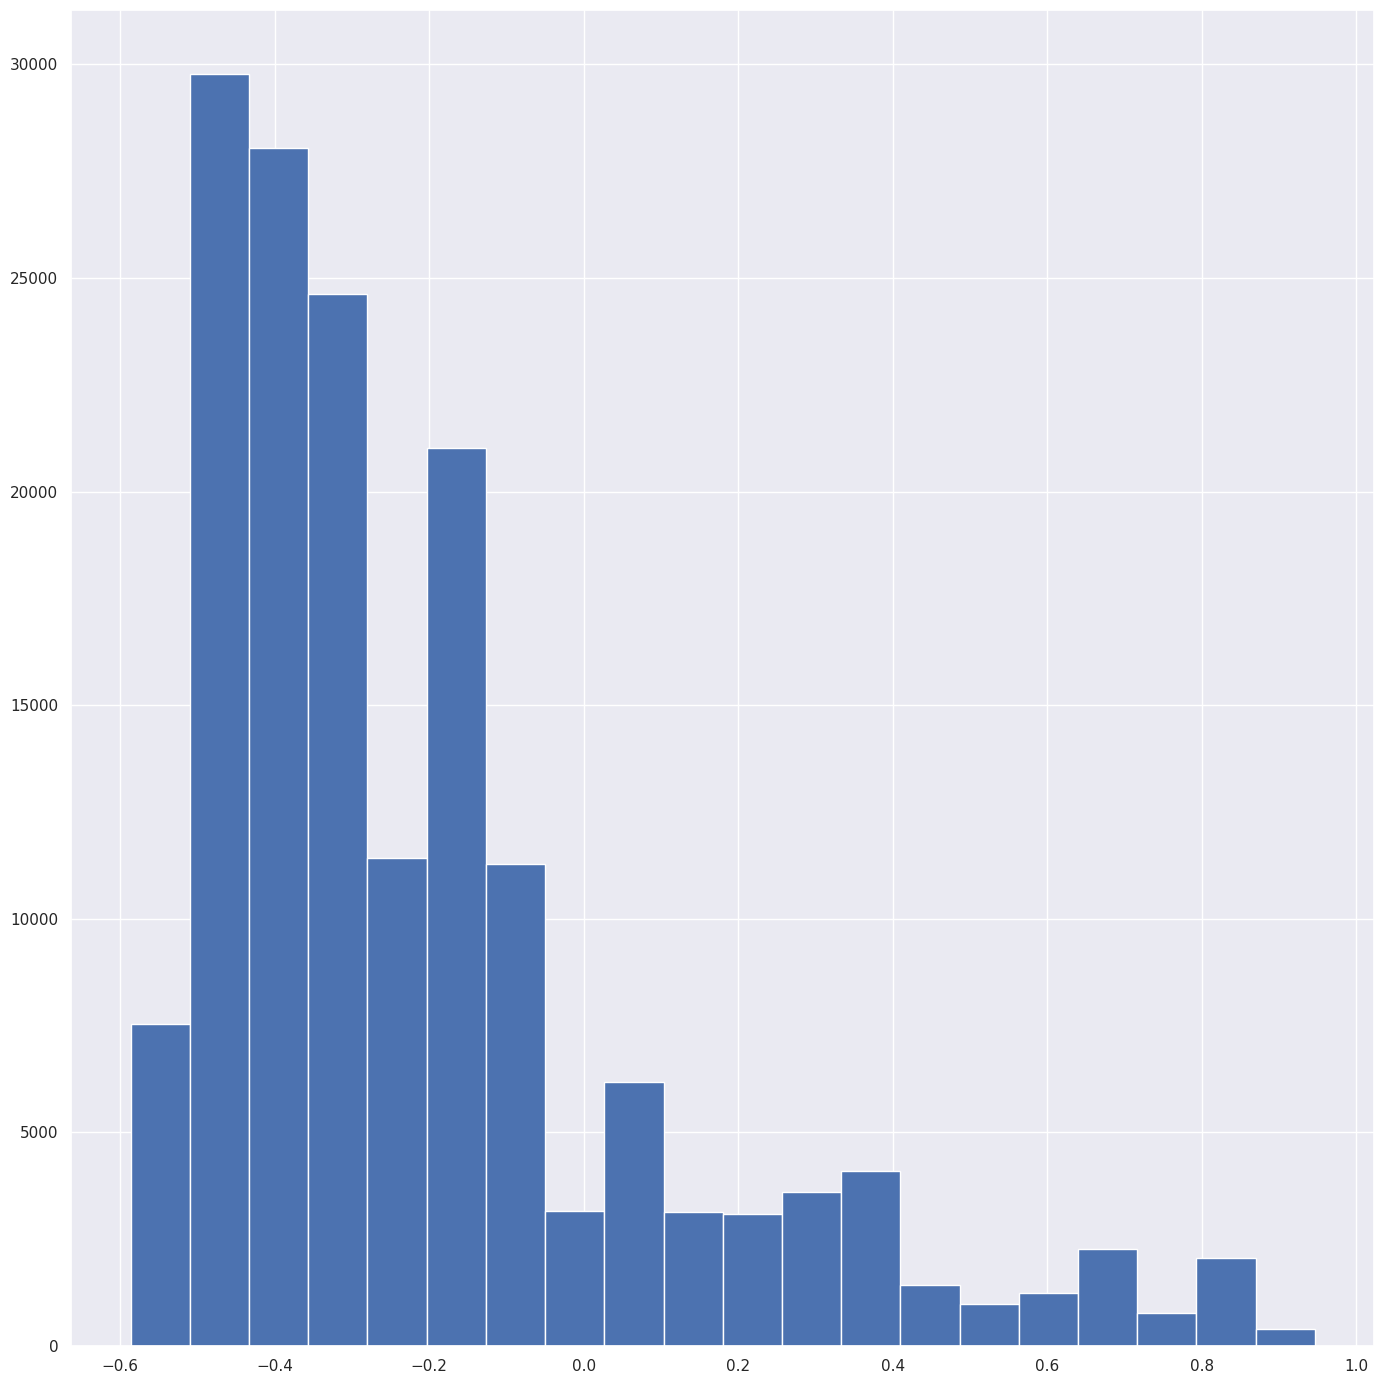

In [207]:
X_valid_no_ems['TransactionAmt'].hist(bins=20, figsize=(14,14))
plt.tight_layout()

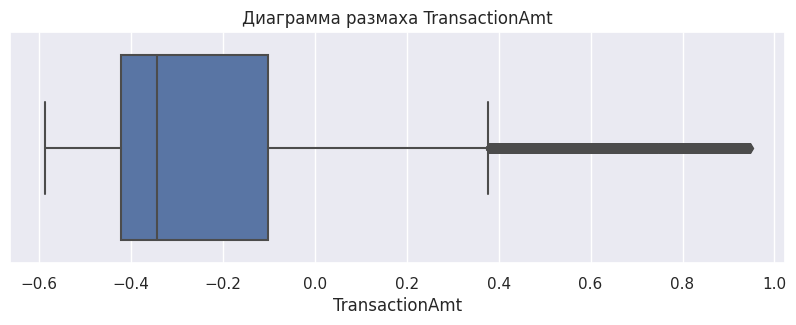

In [208]:
plt_boxplot(X_valid_no_ems, 'TransactionAmt')

Видим, что данные стали намного "чище" после очистки их от выбросов

#### Снова приступим к обучению моделей

------------------------------
DecisionTree
Доля верно угаданных объектов 0.932518440463646


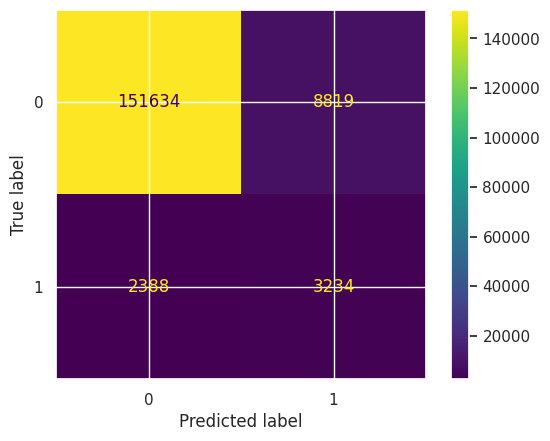

              precision    recall  f1-score   support

           0       0.98      0.95      0.96    160453
           1       0.27      0.58      0.37      5622

    accuracy                           0.93    166075
   macro avg       0.63      0.76      0.67    166075
weighted avg       0.96      0.93      0.94    166075

roc auc score:  0.7601384962230168


In [209]:
DT_no_ems, DT_no_ems_roc_auc = fit_pred_score(DecisionTreeClassifier(), 'DecisionTree', X_train_no_ems, y_train_no_ems, X_valid_no_ems, y_valid_no_ems)

------------------------------
RF
Доля верно угаданных объектов 0.9659611621255457


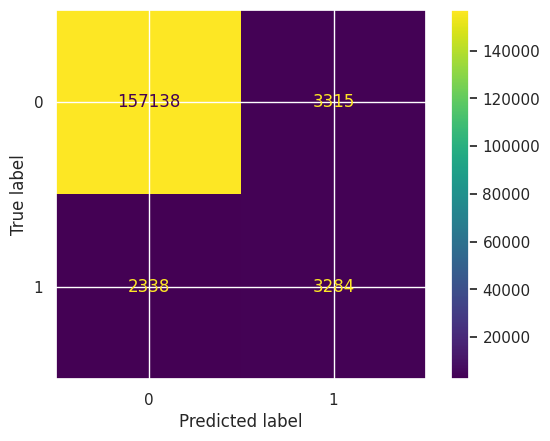

              precision    recall  f1-score   support

           0       0.99      0.98      0.98    160453
           1       0.50      0.58      0.54      5622

    accuracy                           0.97    166075
   macro avg       0.74      0.78      0.76    166075
weighted avg       0.97      0.97      0.97    166075

roc auc score:  0.913444449520935


In [210]:
RF_no_ems, RF_no_ems_roc_auc = fit_pred_score(RandomForestClassifier(), 'RF', X_train_no_ems, y_train_no_ems, X_valid_no_ems, y_valid_no_ems)

------------------------------
AdaBoost
Доля верно угаданных объектов 0.7668222188770134


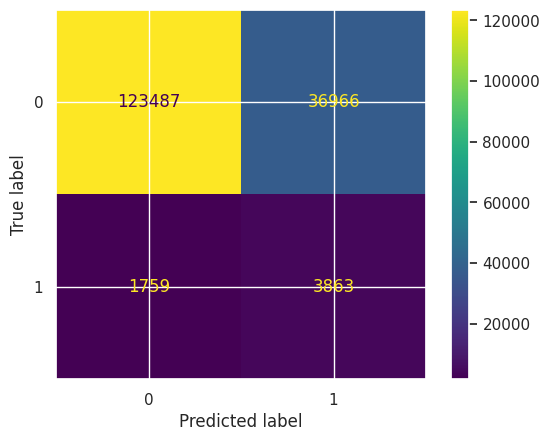

              precision    recall  f1-score   support

           0       0.99      0.77      0.86    160453
           1       0.09      0.69      0.17      5622

    accuracy                           0.77    166075
   macro avg       0.54      0.73      0.52    166075
weighted avg       0.96      0.77      0.84    166075

roc auc score:  0.8022931464476544


In [211]:
AdaBoost_no_ems, AdaBoost_no_ems_roc_auc = fit_pred_score(AdaBoostClassifier(), 'AdaBoost', X_train_no_ems, y_train_no_ems, X_valid_no_ems, y_valid_no_ems)

------------------------------
GradBoost
Доля верно угаданных объектов 0.7821827487580912


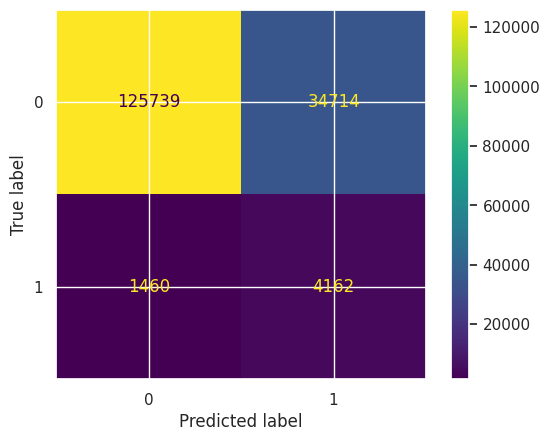

              precision    recall  f1-score   support

           0       0.99      0.78      0.87    160453
           1       0.11      0.74      0.19      5622

    accuracy                           0.78    166075
   macro avg       0.55      0.76      0.53    166075
weighted avg       0.96      0.78      0.85    166075

roc auc score:  0.8339715272250702


In [212]:
GradBoost_no_ems, GradBoost_no_ems_roc_auc = fit_pred_score(GradientBoostingClassifier(), 'GradBoost', X_train_no_ems, y_train_no_ems, X_valid_no_ems, y_valid_no_ems)

------------------------------
XGB
Доля верно угаданных объектов 0.8602679512268553


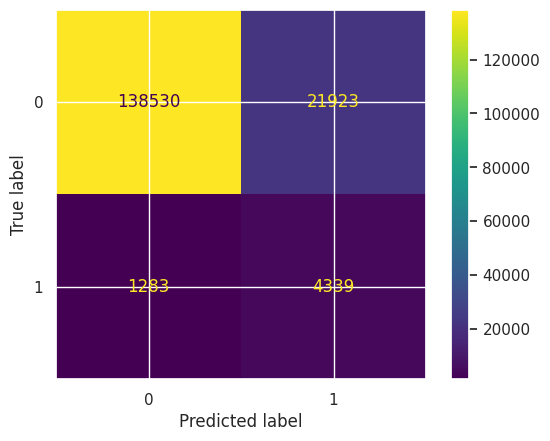

              precision    recall  f1-score   support

           0       0.99      0.86      0.92    160453
           1       0.17      0.77      0.27      5622

    accuracy                           0.86    166075
   macro avg       0.58      0.82      0.60    166075
weighted avg       0.96      0.86      0.90    166075

roc auc score:  0.895728072416316


In [213]:
XGB_no_ems, XGB_no_ems_roc_auc = fit_pred_score(XGBClassifier(), 'XGB', X_train_no_ems, y_train_no_ems, X_valid_no_ems, y_valid_no_ems)

------------------------------
LGBM
Доля верно угаданных объектов 0.8274936022881229


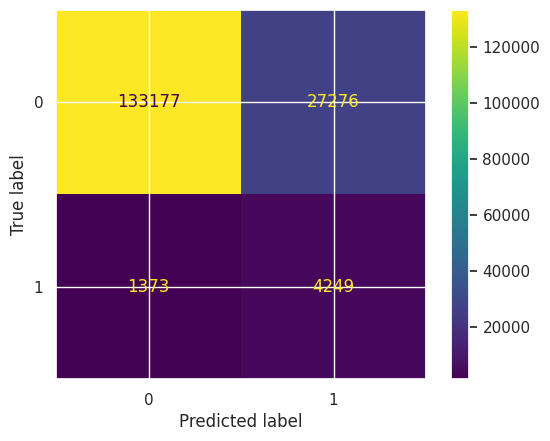

              precision    recall  f1-score   support

           0       0.99      0.83      0.90    160453
           1       0.13      0.76      0.23      5622

    accuracy                           0.83    166075
   macro avg       0.56      0.79      0.57    166075
weighted avg       0.96      0.83      0.88    166075

roc auc score:  0.8729983618529629


In [214]:
LGBM_no_ems, LGBM_no_ems_roc_auc = fit_pred_score(LGBMClassifier(), 'LGBM', X_train_no_ems, y_train_no_ems, X_valid_no_ems, y_valid_no_ems)

Посмотрим на сравнение результатов ```roc auc score``` до очистки от выбросов и после

In [215]:
roc_auc_df3 = pd.DataFrame(data=[DT_no_ems_roc_auc, 
                                 RF_no_ems_roc_auc, 
                                 AdaBoost_no_ems_roc_auc,
                                 GradBoost_no_ems_roc_auc,
                                 XGB_no_ems_roc_auc,
                                 LGBM_no_ems_roc_auc],
                           index=['DT', 'RF', 'AdaBoost', 'GBM', 'XGB', 'LGBM'],
                          columns=['roc auc score (no emmisions)'])
roc_auc_general = pd.concat([roc_auc_df, roc_auc_df3], axis=1)
roc_auc_general

roc_auc_score(mean, not sc)  roc_auc_score(mean, sc)  \
DT                           0.756123                 0.757102   
RF                           0.911107                 0.910616   
AdaBoost                     0.809307                 0.809307   
GBM                          0.832951                 0.832950   
XGB                          0.893081                 0.893080   
LGBM                         0.873134                 0.872604   

          roc auc score (no emmisions)  
DT                            0.760138  
RF                            0.913444  
AdaBoost                      0.802293  
GBM                           0.833972  
XGB                           0.895728  
LGBM                          0.872998

Прогнозы в целом не улучшились, а значит следует поискать другие способы улучшения наших прогнозов

Напомню, что это прогнозы на валидационном датасете с дисбалансом классов, а значит это довольно хороший результат прогнозов

(array([118755.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0., 109176.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

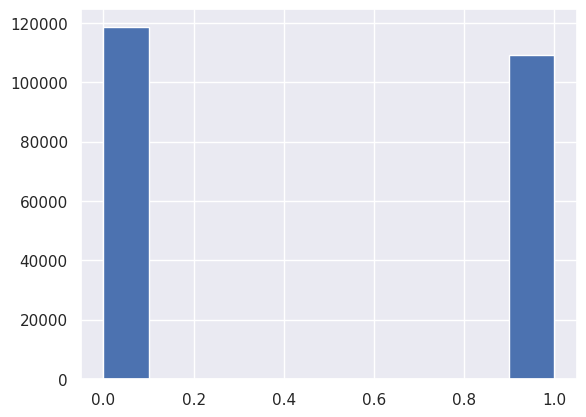

In [216]:
plt.hist(y_train_no_ems, label='train')

(array([160453.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,   5622.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

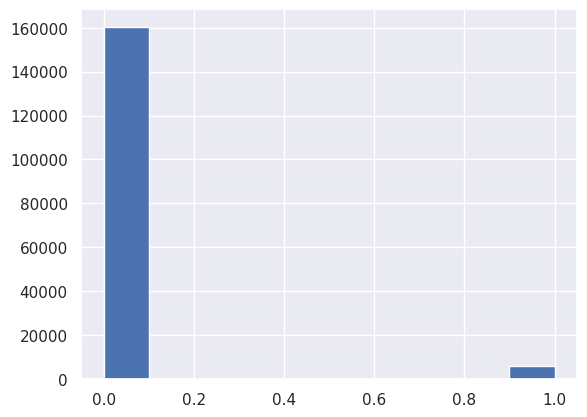

In [217]:
plt.hist(y_valid_no_ems, label='valid')

### Попробуем заполнить пропуски в числовых значениях медианными значениями по колонке

In [218]:
X_train_copy2 = X_train.copy()
X_valid_copy2 = X_valid.copy()
test_df_copy2 = test_df.copy()

In [219]:
num_feats = ['TransactionDT', 'TransactionAmt', 'C3', 'D3', 'V1', 'V55', 'V107', 'V121', 'V281', 'V286', 'V305']
num_feats

['TransactionDT',
 'TransactionAmt',
 'C3',
 'D3',
 'V1',
 'V55',
 'V107',
 'V121',
 'V281',
 'V286',
 'V305']

In [220]:
X_train_copy2.isna().sum()

TransactionID          0
TransactionDT          0
TransactionAmt         0
ProductCD              0
card1                  0
card2               6232
card4                  0
card5               2993
card6                  0
addr1              46348
addr2              46348
P_emaildomain          0
C3                     0
D3                184268
V1                195833
V55                53927
V107                 208
V121                 208
V281                 902
V286                   8
V305                   8
dtype: int64

In [221]:
X_train_copy2[num_feats] = X_train_copy2[num_feats].fillna(
    X_train_copy2[num_feats].median())

In [222]:
X_valid_copy2[num_feats] = X_valid_copy2[num_feats].fillna(
    X_valid_copy2[num_feats].median())

In [223]:
test_df_copy2[num_feats] = test_df_copy2[num_feats].fillna(
    test_df_copy2[num_feats].median())

В категориальных признаках заполним пропуски константой ```-1```

In [224]:
cat_feats

['ProductCD',
 'card1',
 'card2',
 'card4',
 'card5',
 'card6',
 'addr1',
 'addr2',
 'P_emaildomain']

In [225]:
X_train_copy2[cat_feats] = X_train_copy2[cat_feats].fillna(-1)
X_valid_copy2[cat_feats] = X_valid_copy2[cat_feats].fillna(-1)
test_df_copy2[cat_feats] = test_df_copy2[cat_feats].fillna(-1)

Проверим, остались ли пропуски в данных

In [226]:
X_train_copy2.isna().sum()

TransactionID     0
TransactionDT     0
TransactionAmt    0
ProductCD         0
card1             0
card2             0
card4             0
card5             0
card6             0
addr1             0
addr2             0
P_emaildomain     0
C3                0
D3                0
V1                0
V55               0
V107              0
V121              0
V281              0
V286              0
V305              0
dtype: int64

In [227]:
X_valid_copy2.isna().sum()

TransactionID     0
TransactionDT     0
TransactionAmt    0
ProductCD         0
card1             0
card2             0
card4             0
card5             0
card6             0
addr1             0
addr2             0
P_emaildomain     0
C3                0
D3                0
V1                0
V55               0
V107              0
V121              0
V281              0
V286              0
V305              0
dtype: int64

In [228]:
test_df_copy2.isna().sum()

TransactionID     0
TransactionDT     0
TransactionAmt    0
ProductCD         0
card1             0
card2             0
card4             0
card5             0
card6             0
addr1             0
addr2             0
P_emaildomain     0
C3                0
D3                0
V1                0
V55               0
V107              0
V121              0
V281              0
V286              0
V305              0
dtype: int64

### Распределения признаков после заполнения пропусков **медианой** для числовых признаков и константой -1 для категориальных признаков

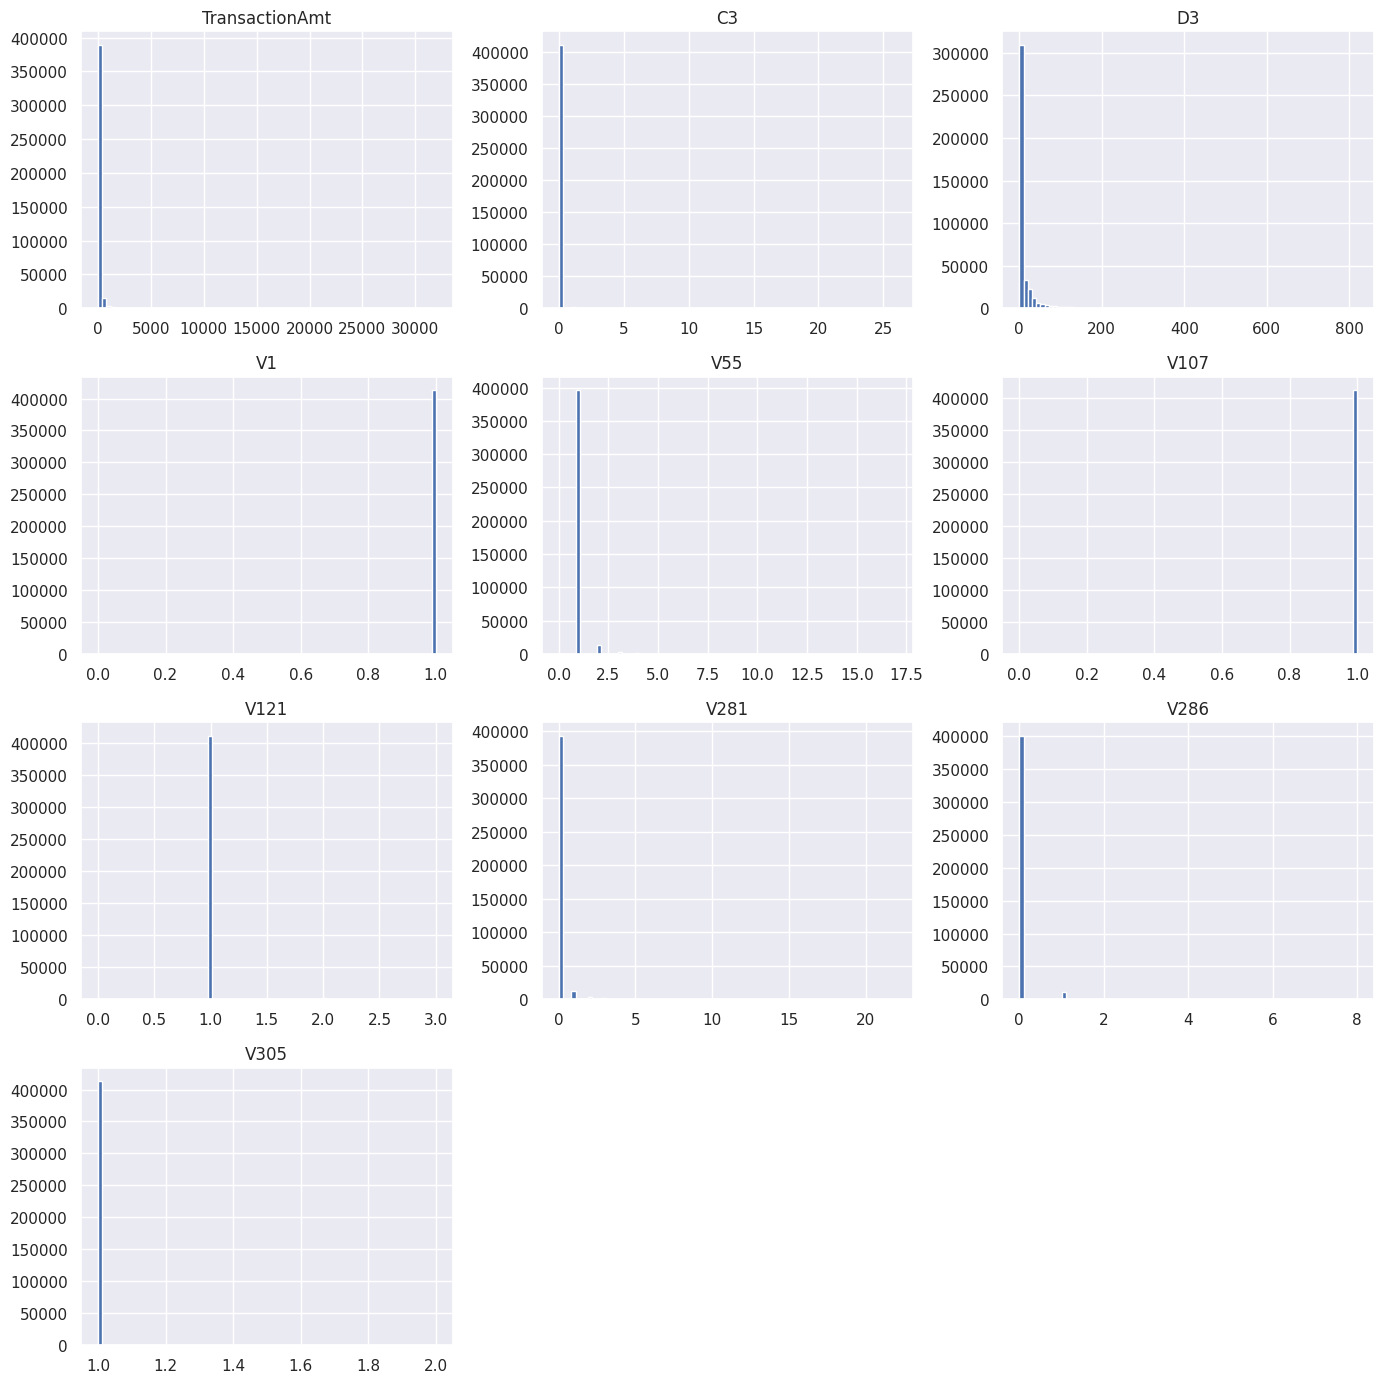

In [229]:
X_train_copy2[num_feats[1:]].hist(bins=80, figsize=(14,14))
plt.tight_layout()

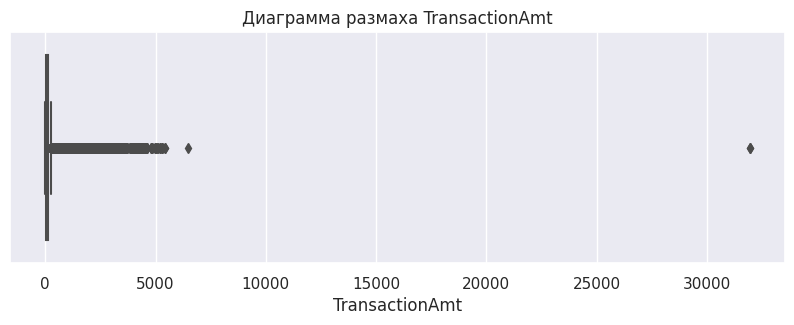

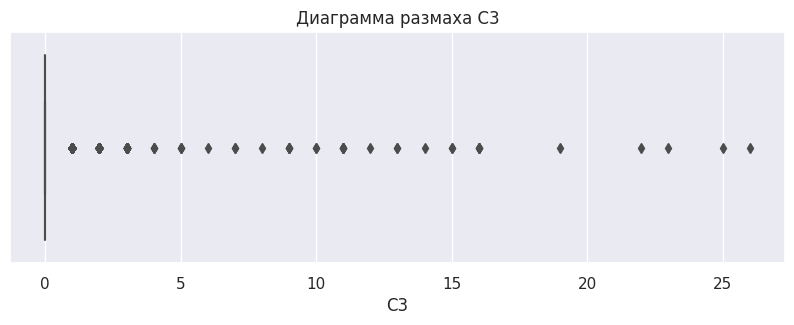

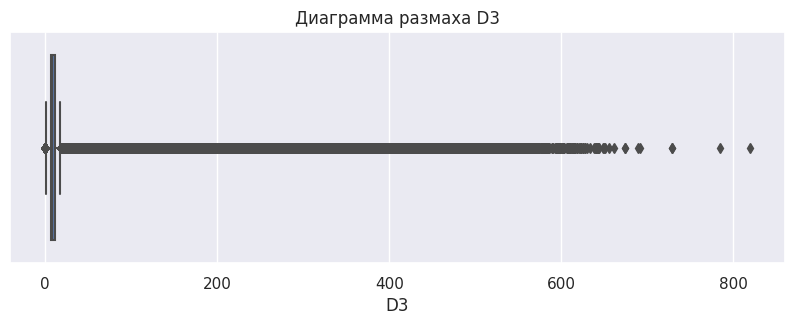

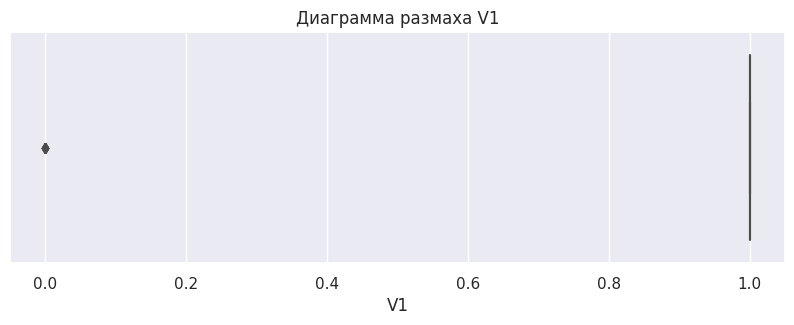

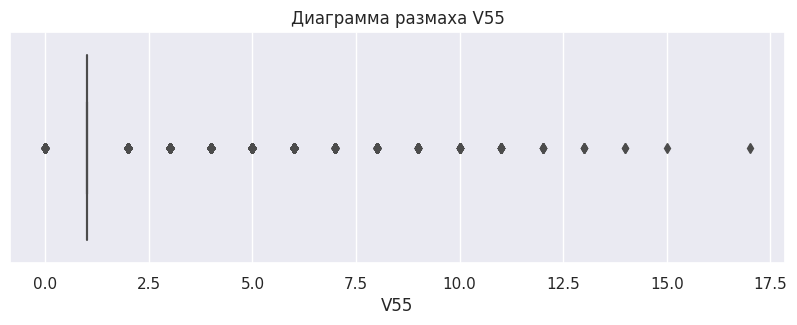

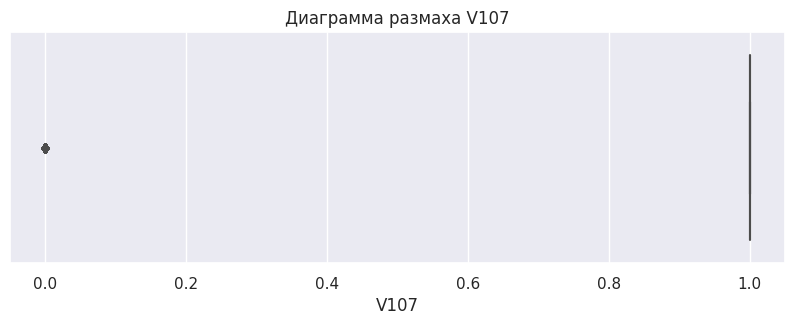

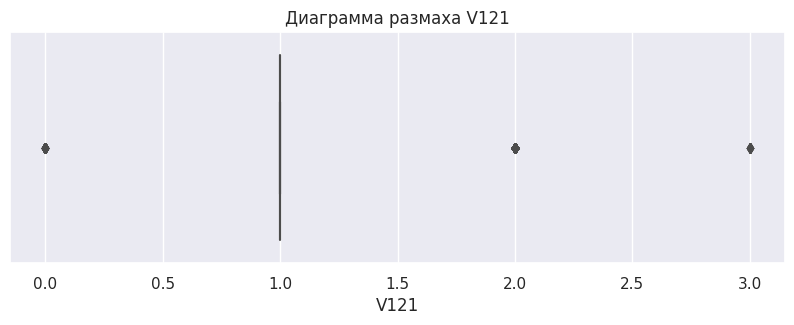

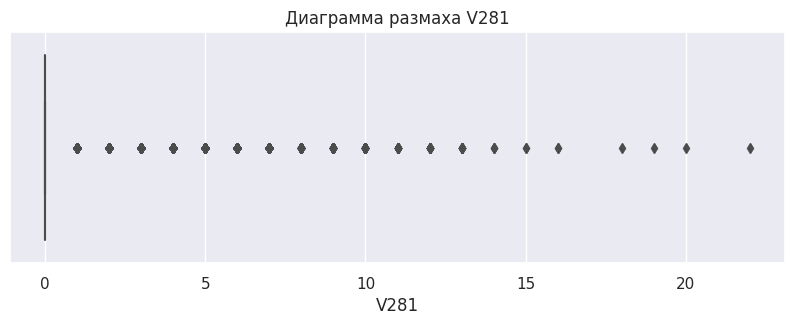

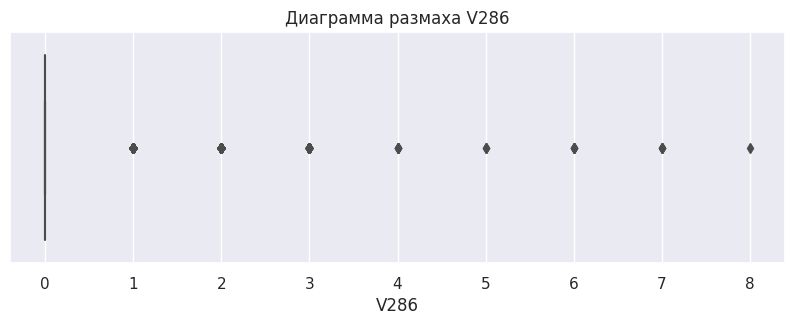

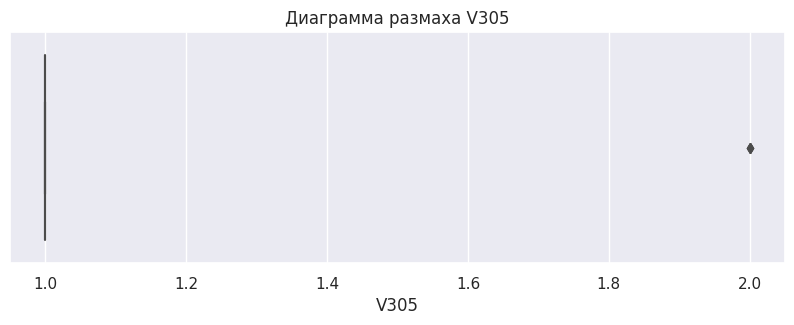

In [230]:
for feat in X_train_copy2[num_feats[1:]].columns:
    plt_boxplot(X_train_copy2, feat)

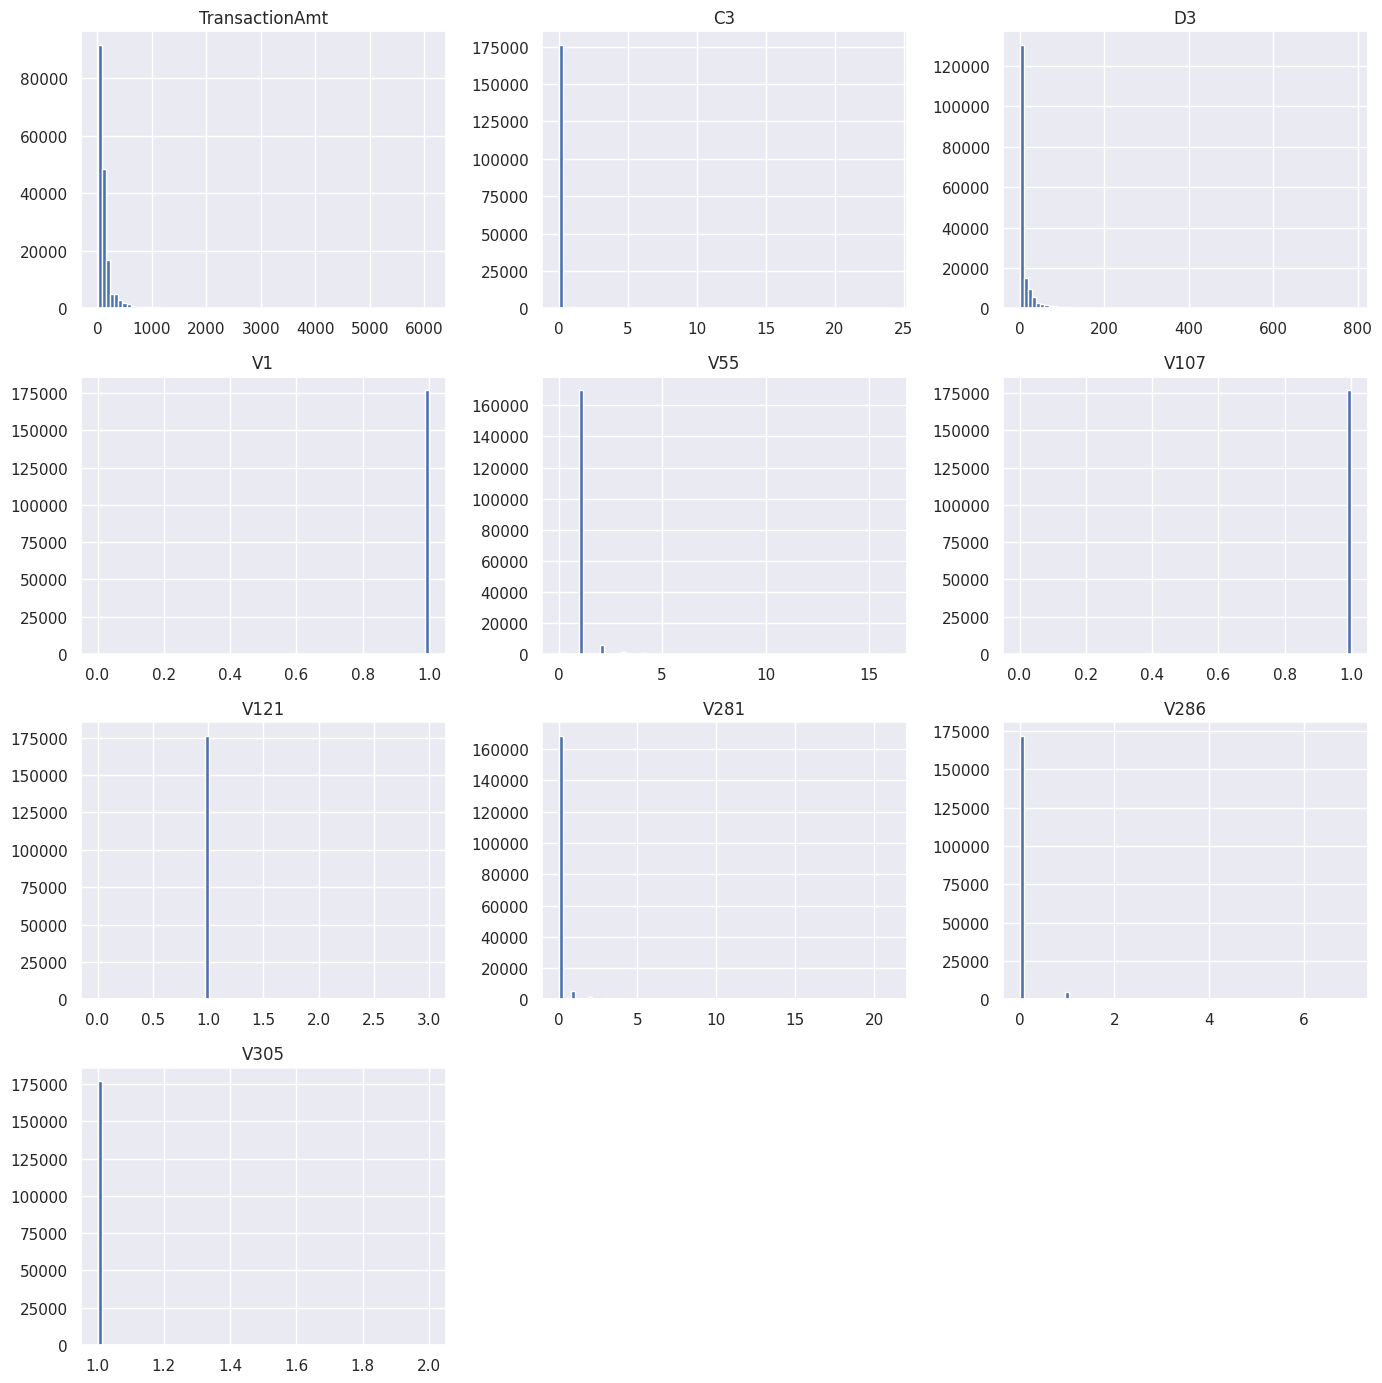

In [231]:
X_valid_copy2[num_feats[1:]].hist(bins=80, figsize=(14,14))
plt.tight_layout()

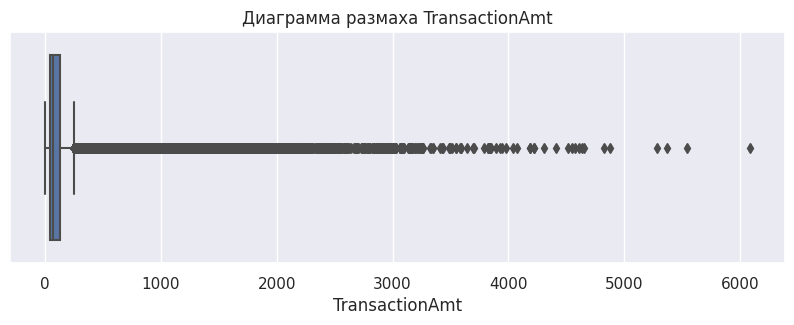

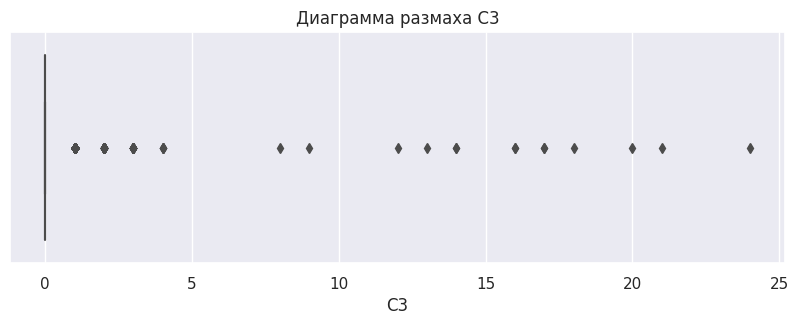

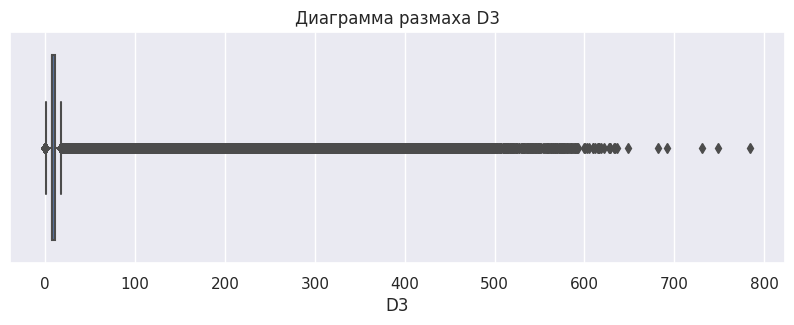

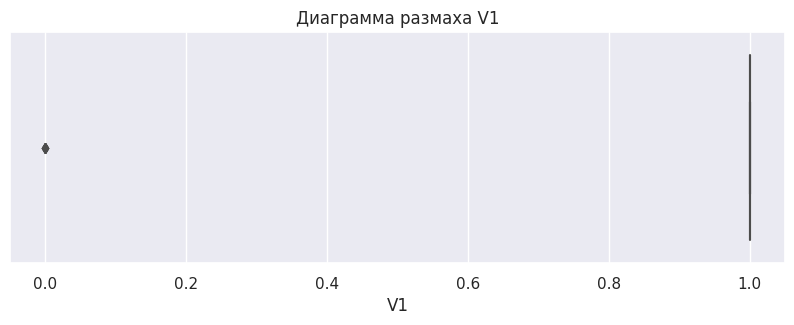

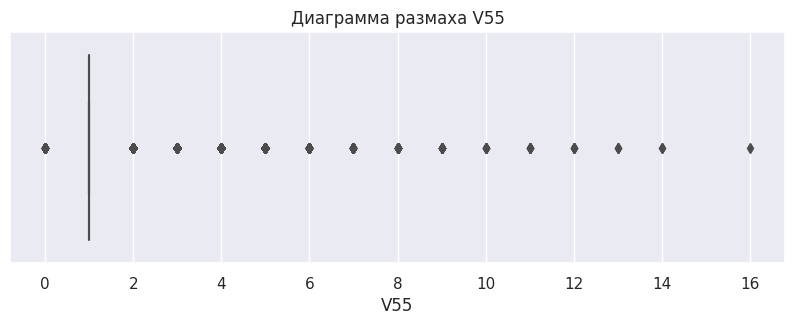

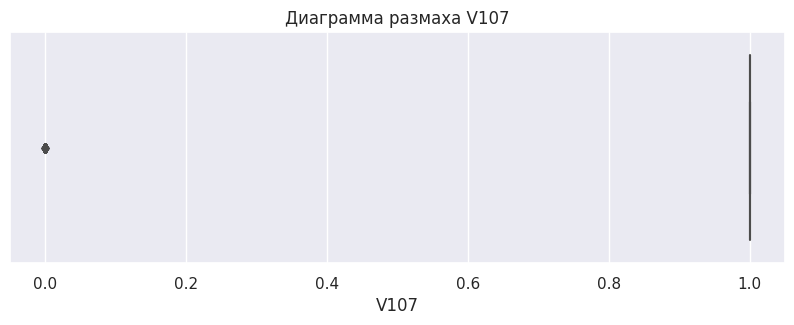

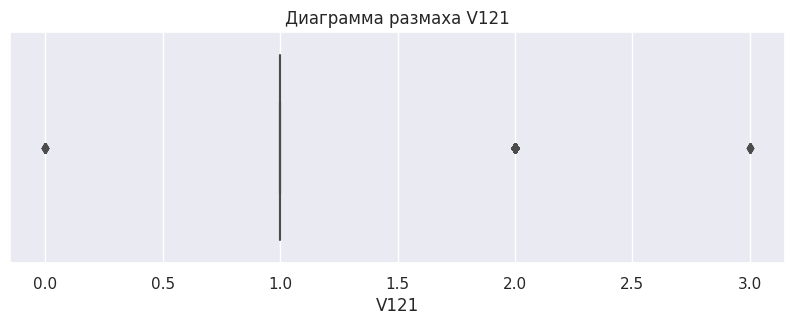

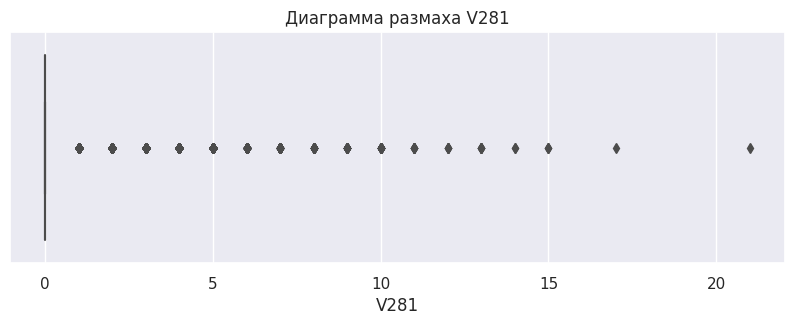

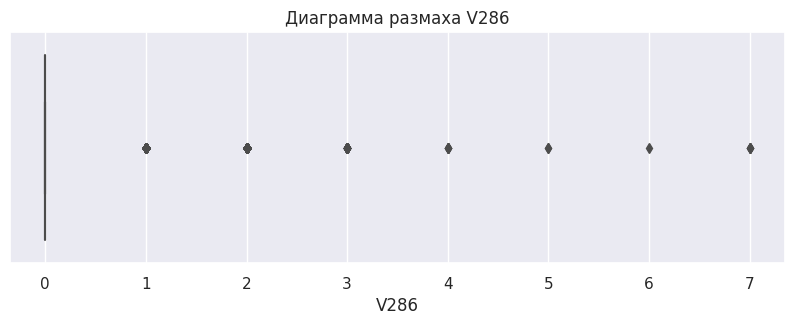

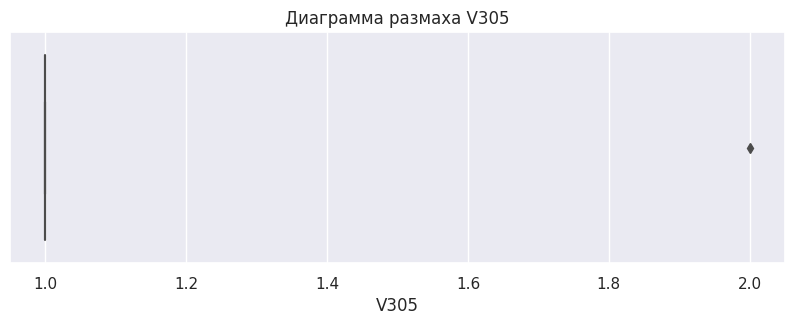

In [232]:
for feat in X_valid_copy2[num_feats[1:]].columns:
    plt_boxplot(X_valid_copy2, feat)

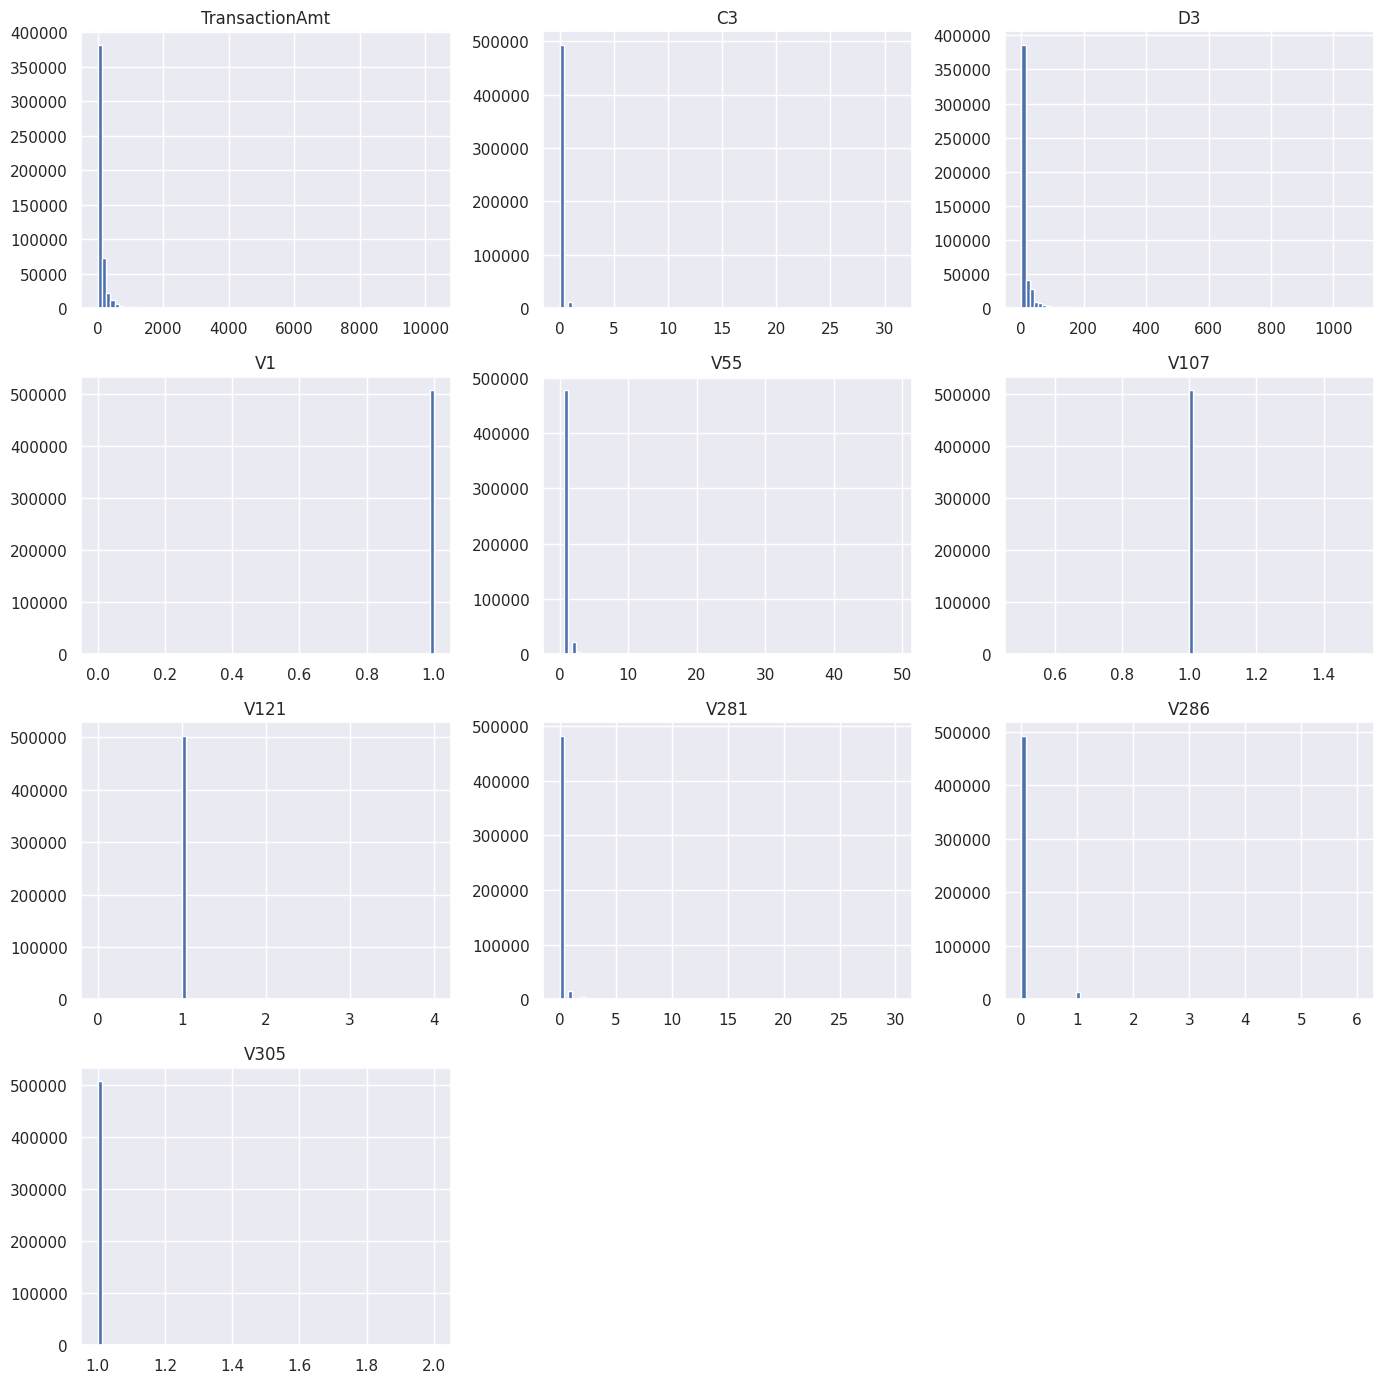

In [233]:
test_df_copy2[num_feats[1:]].hist(bins=80, figsize=(14,14))
plt.tight_layout()

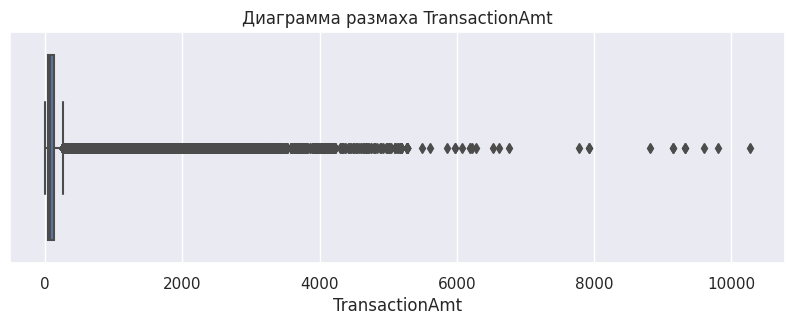

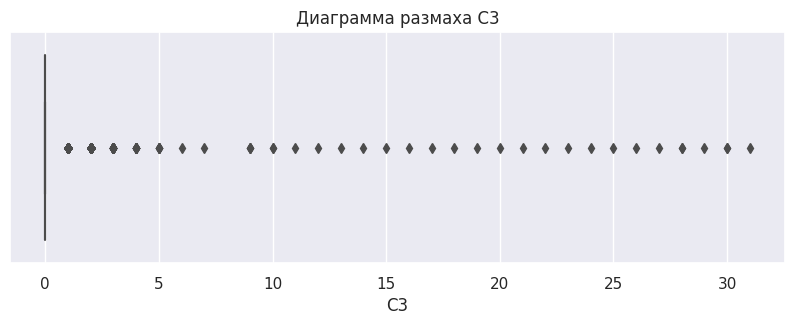

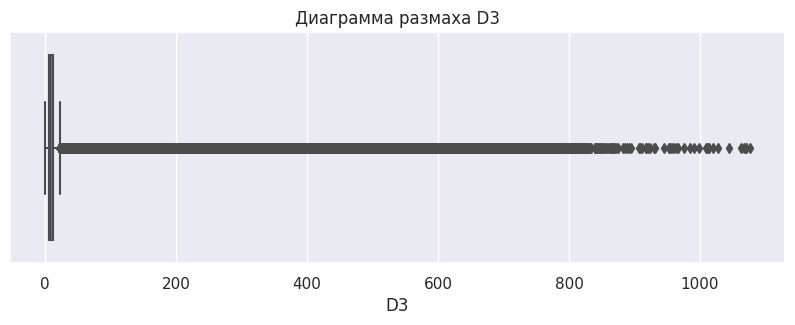

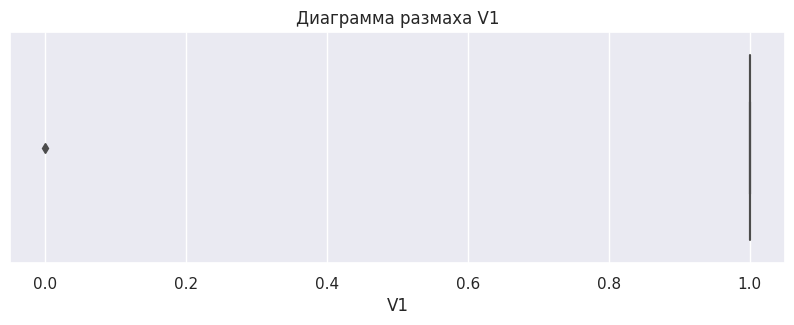

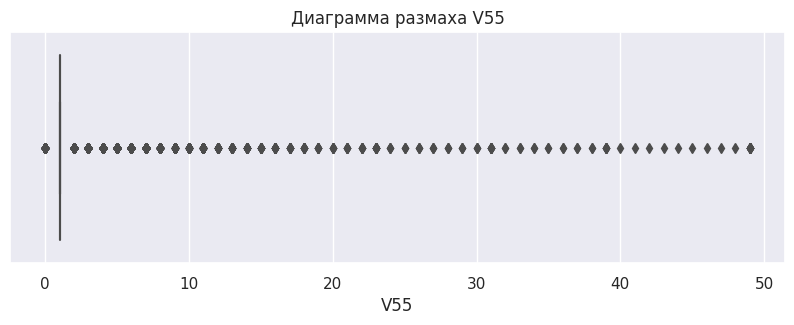

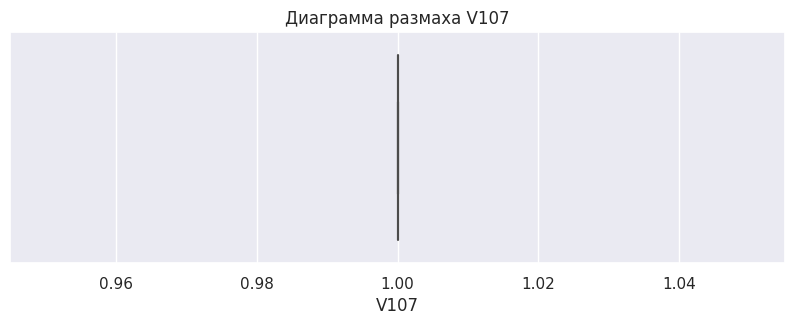

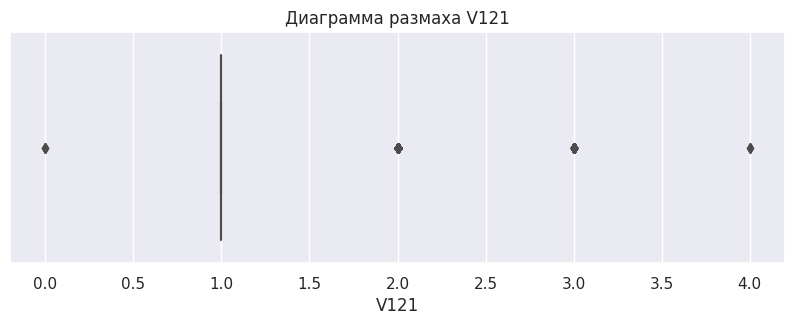

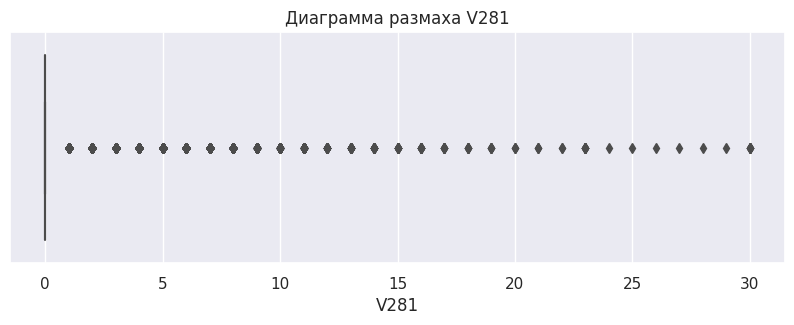

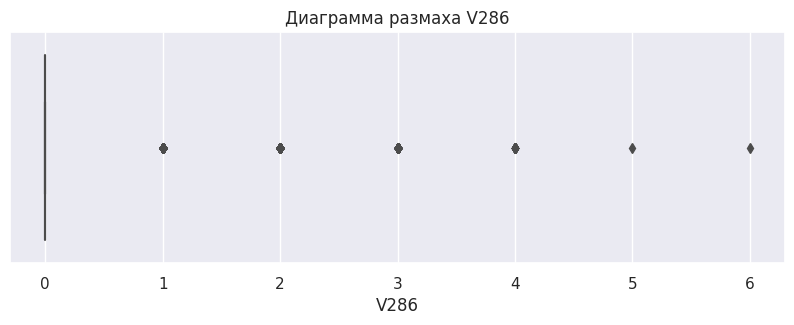

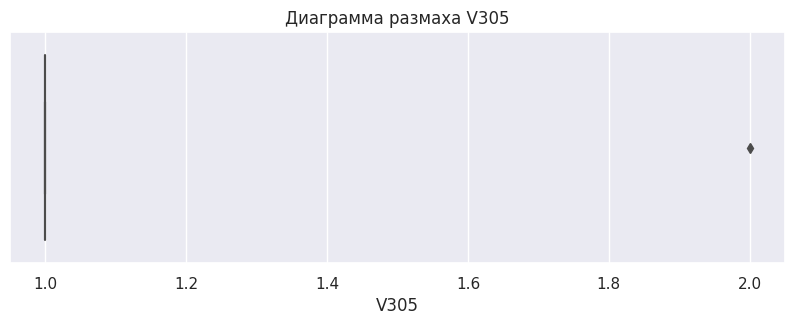

In [234]:
for feat in test_df_copy2[num_feats[1:]].columns:
    plt_boxplot(test_df_copy2, feat)

Удалим признаки с большим количеством выбросов (вспомним, что некоторые из них также оказывают слабое влияние на обучение моделей) 

In [235]:
not_important_feats = ['C3', 'V1', 'V107', 'V121', 'V305']
X_train_copy2 = X_train_copy2.drop(columns=not_important_feats)
X_valid_copy2 = X_valid_copy2.drop(columns=not_important_feats)
test_df_copy2 = test_df_copy2.drop(columns=not_important_feats)

In [236]:
X_train_copy2

TransactionID  TransactionDT  TransactionAmt  ProductCD  card1  card2  \
184962        3171962        4120030       59.000000          4  16993  555.0   
510418        3497418       13368904       57.950001          4  18132  567.0   
121172        3108172        2388253       57.950001          4  16132  111.0   
461070        3448070       11841006      100.000000          1  10616  583.0   
329698        3316698        8110823       34.000000          4   9500  321.0   
...               ...            ...             ...        ...    ...    ...   
481831        3468831       12521063       67.949997          4   2803  100.0   
14141         3001141         406952      107.949997          4  16132  111.0   
158241        3145241        3292480       25.000000          4   7664  490.0   
195829        3182829        4403405      150.000000          2  10825  111.0   
16290         3003290         433915      100.598999          0  15146  311.0   

        card4  card5  card6  addr1  addr2  P_emaildomain    D3  V55  V281  \
184962      4  226.0      2  184.0   87.0             16   6.0  1.0   0.0   
510418      2  117.0      2  204.0   87.0             16  10.0  1.0   0.0   
121172      4  226.0      2  299.0   87.0             16   7.0  1.0   0.0   
461070      4  226.0      1  264.0   87.0             23   8.0  1.0   0.0   
329698      4  226.0      2  330.0   87.0             30   1.0  1.0   0.0   
...       ...    ...    ...    ...    ...            ...   ...  ...   ...   
481831      4  226.0      2  184.0   87.0             16  23.0  1.0   0.0   
14141       4  226.0      2  299.0   87.0             54  25.0  1.0   0.0   
158241      4  226.0      2  315.0   87.0             16   8.0  1.0   0.0   
195829      4  195.0      1  204.0   87.0              1   8.0  1.0   0.0   
16290       4  102.0      1   -1.0   -1.0             16   8.0  1.0   0.0   

        V286  
184962   0.0  
510418   0.0  
121172   0.0  
461070   0.0  
329698   0.0  
...      ...  
481831   0.0  
14141    0.0  
158241   0.0  
195829   0.0  
16290    0.0  

[413378 rows x 16 columns]

In [237]:
X_valid_copy2

TransactionID  TransactionDT  TransactionAmt  ProductCD  card1  card2  \
587423        3574423       15718014      117.000000          4  12577  268.0   
268070        3255070        6483262      280.000000          4   7427  543.0   
85582         3072582        1809527       41.042999          0  10876  104.0   
544807        3531807       14387583       57.950001          4  16232  396.0   
571901        3558901       15190040      390.000000          4  16075  514.0   
...               ...            ...             ...        ...    ...    ...   
30610         3017610         765815      150.000000          2  12827  555.0   
207146        3194146        4757113      112.989998          4   6344  327.0   
393770        3380770        9902240      160.500000          4  12308  360.0   
362875        3349875        8992448      151.000000          4   4971  225.0   
121325        3108325        2390627      294.950012          4  13053  302.0   

        card4  card5  card6  addr1  addr2  P_emaildomain     D3  V55  V281  \
587423      4  166.0      2  476.0   87.0             16    1.0  1.0   0.0   
268070      2  224.0      2  143.0   87.0             16   12.0  2.0   0.0   
85582       4  137.0      1   -1.0   -1.0             19    0.0  3.0   0.0   
544807      2  224.0      2  315.0   87.0             16  522.0  1.0   0.0   
571901      2  102.0      1  315.0   87.0             19    8.0  1.0   0.0   
...       ...    ...    ...    ...    ...            ...    ...  ...   ...   
30610       4  102.0      1  536.0   96.0             16    8.0  1.0   0.0   
207146      1  166.0      2  325.0   87.0             54    8.0  1.0   0.0   
393770      4  166.0      2  191.0   87.0             19    8.0  1.0   0.0   
362875      2  117.0      2  299.0   87.0             54    8.0  1.0   0.0   
121325      4  226.0      2  337.0   87.0             54   57.0  1.0   0.0   

        V286  
587423   0.0  
268070   0.0  
85582    0.0  
544807   0.0  
571901   0.0  
...      ...  
30610    0.0  
207146   0.0  
393770   0.0  
362875   0.0  
121325   0.0  

[177162 rows x 16 columns]

In [238]:
test_df_copy2

TransactionID  TransactionDT  TransactionAmt  ProductCD  card1  card2  \
0             3663549       18403224       31.950001          4  10409  111.0   
1             3663550       18403263       49.000000          4   4272  111.0   
2             3663551       18403310      171.000000          4   4476  574.0   
3             3663552       18403310      284.950012          4  10989  360.0   
4             3663553       18403317       67.949997          4  18018  452.0   
...               ...            ...             ...        ...    ...    ...   
506686        4170235       34214279       94.679001          0  13832  375.0   
506687        4170236       34214287       12.173000          0   3154  408.0   
506688        4170237       34214326       49.000000          4  16661  490.0   
506689        4170238       34214337      202.000000          4  16621  516.0   
506690        4170239       34214345       24.346001          0   5713  168.0   

        card4  card5  card6  addr1  addr2  P_emaildomain    D3  V55  V281  \
0           4  226.0      2  170.0   87.0             16  27.0  1.0   0.0   
1           4  226.0      2  299.0   87.0              2   7.0  1.0   0.0   
2           4  226.0      2  472.0   87.0             19  10.0  1.0   0.0   
3           4  166.0      2  205.0   87.0             16  41.0  1.0   0.0   
4           2  117.0      2  264.0   87.0             16   0.0  1.0   0.0   
...       ...    ...    ...    ...    ...            ...   ...  ...   ...   
506686      2  224.0      2  284.0   60.0             16   7.0  1.0   0.0   
506687      2  224.0      2   -1.0   -1.0             19  16.0  2.0   1.0   
506688      4  226.0      2  327.0   87.0             19   7.0  1.0   0.0   
506689      2  224.0      2  177.0   87.0             19   7.0  1.0   0.0   
506690      4  147.0      1   -1.0   -1.0             19   7.0  1.0   0.0   

        V286  
0        0.0  
1        0.0  
2        0.0  
3        0.0  
4        1.0  
...      ...  
506686   0.0  
506687   0.0  
506688   0.0  
506689   0.0  
506690   0.0  

[506691 rows x 16 columns]

#### Избавимся от выбросов

Временно соединяем датасеты с целевыми метками, чтобы не потерять порядок данных после очистки от выбросов. И упорядочим данные по полю ```TransactionDT```

In [239]:
train_data2 = pd.concat([X_train_copy2, y_train], axis=1)
train_data2 = train_data2.sort_values('TransactionDT')
train_data2

TransactionID  TransactionDT  TransactionAmt  ProductCD  card1  card2  \
1             2987001          86401       29.000000          4   2755  404.0   
5             2987005          86510       49.000000          4   5937  555.0   
6             2987006          86522      159.000000          4  12308  360.0   
7             2987007          86529      422.500000          4  12695  490.0   
8             2987008          86535       15.000000          1   2803  100.0   
...               ...            ...             ...        ...    ...    ...   
590533        3577533       15811029      107.949997          4  13071  321.0   
590535        3577535       15811047       49.000000          4   6550   -1.0   
590536        3577536       15811049       39.500000          4  10444  225.0   
590537        3577537       15811079       30.950001          4  12037  595.0   
590539        3577539       15811131      279.950012          4  15066  170.0   

        card4  card5  card6  addr1  addr2  P_emaildomain    D3  V55  V281  \
1           2  102.0      1  325.0   87.0             16   8.0  1.0   0.0   
5           4  226.0      2  272.0   87.0             16   8.0  1.0   0.0   
6           4  166.0      2  126.0   87.0             54   8.0  1.0   0.0   
7           4  226.0      2  325.0   87.0             29   8.0  1.0   0.0   
8           4  226.0      2  337.0   87.0              1   8.0  1.0   0.0   
...       ...    ...    ...    ...    ...            ...   ...  ...   ...   
590533      4  226.0      2  485.0   87.0             16   6.0  1.0   0.0   
590535      4  226.0      2  272.0   87.0             32  30.0  1.0   0.0   
590536      2  224.0      2  204.0   87.0             16   8.0  1.0   0.0   
590537      2  224.0      2  231.0   87.0             16   8.0  1.0   0.0   
590539      2  102.0      1  299.0   87.0             16   0.0  1.0   0.0   

        V286  isFraud  
1        0.0        0  
5        0.0        0  
6        0.0        0  
7        0.0        0  
8        0.0        0  
...      ...      ...  
590533   0.0        0  
590535   0.0        0  
590536   0.0        0  
590537   0.0        0  
590539   0.0        0  

[413378 rows x 17 columns]

In [240]:
valid_data2 = pd.concat([X_valid_copy2, y_valid], axis=1)
valid_data2 = valid_data2.sort_values('TransactionDT')
valid_data2

TransactionID  TransactionDT  TransactionAmt  ProductCD  card1  card2  \
0             2987000          86400       68.500000          4  13926   -1.0   
2             2987002          86469       59.000000          4   4663  490.0   
3             2987003          86499       50.000000          4  18132  567.0   
4             2987004          86506       50.000000          1   4497  514.0   
11            2987011          86555       16.495001          0   4461  375.0   
...               ...            ...             ...        ...    ...    ...   
590530        3577530       15810926      400.779999          4  15066  170.0   
590531        3577531       15810935      400.000000          2   6019  583.0   
590532        3577532       15811007      204.970001          4  12037  595.0   
590534        3577534       15811030       67.504997          0   5812  408.0   
590538        3577538       15811088      117.000000          4   7826  481.0   

        card4  card5  card6  addr1  addr2  P_emaildomain     D3  V55  V281  \
0           1  142.0      1  315.0   87.0             32   13.0  1.0   0.0   
2           4  166.0      2  330.0   87.0             36    8.0  1.0   0.0   
3           2  117.0      2  476.0   87.0             54    0.0  1.0   0.0   
4           2  102.0      1  420.0   87.0             16    8.0  1.0   0.0   
11          2  224.0      2   -1.0   -1.0             19    8.0  1.0   0.0   
...       ...    ...    ...    ...    ...            ...    ...  ...   ...   
590530      2  102.0      1  299.0   87.0             54    8.0  1.0   0.0   
590531      4  226.0      1  337.0   87.0             16    8.0  1.0   0.0   
590532      2  224.0      2  231.0   87.0             35  315.0  1.0   0.0   
590534      2  224.0      2   -1.0   -1.0             16    8.0  1.0   0.0   
590538      2  224.0      2  387.0   87.0              2    0.0  1.0   0.0   

        V286  isFraud  
0        0.0        0  
2        0.0        0  
3        0.0        0  
4        0.0        0  
11       0.0        0  
...      ...      ...  
590530   0.0        0  
590531   0.0        0  
590532   0.0        0  
590534   0.0        0  
590538   0.0        0  

[177162 rows x 17 columns]

Очистим датасеты от выбросов

In [241]:
num_feats = ['TransactionDT', 'TransactionAmt', 'D3', 'V281', 'V286']

In [242]:
# train_data2_with_no_emsns = data_without_feat_emsns(
#     train_data2, 'TransactionDT')
train_data2_with_no_emsns = data_without_feat_emsns(
    train_data2, 'TransactionAmt')
# train_data2_with_no_emsns = data_without_feat_emsns(
#     train_data2_with_no_emsns, 'D3')
train_data2_with_no_emsns

TransactionID  TransactionDT  TransactionAmt  ProductCD  card1  card2  \
1             2987001          86401       29.000000          4   2755  404.0   
5             2987005          86510       49.000000          4   5937  555.0   
6             2987006          86522      159.000000          4  12308  360.0   
8             2987008          86535       15.000000          1   2803  100.0   
9             2987009          86536      117.000000          4  17399  111.0   
...               ...            ...             ...        ...    ...    ...   
590533        3577533       15811029      107.949997          4  13071  321.0   
590535        3577535       15811047       49.000000          4   6550   -1.0   
590536        3577536       15811049       39.500000          4  10444  225.0   
590537        3577537       15811079       30.950001          4  12037  595.0   
590539        3577539       15811131      279.950012          4  15066  170.0   

        card4  card5  card6  addr1  addr2  P_emaildomain    D3  V55  V281  \
1           2  102.0      1  325.0   87.0             16   8.0  1.0   0.0   
5           4  226.0      2  272.0   87.0             16   8.0  1.0   0.0   
6           4  166.0      2  126.0   87.0             54   8.0  1.0   0.0   
8           4  226.0      2  337.0   87.0              1   8.0  1.0   0.0   
9           2  224.0      2  204.0   87.0             54  30.0  1.0   0.0   
...       ...    ...    ...    ...    ...            ...   ...  ...   ...   
590533      4  226.0      2  485.0   87.0             16   6.0  1.0   0.0   
590535      4  226.0      2  272.0   87.0             32  30.0  1.0   0.0   
590536      2  224.0      2  204.0   87.0             16   8.0  1.0   0.0   
590537      2  224.0      2  231.0   87.0             16   8.0  1.0   0.0   
590539      2  102.0      1  299.0   87.0             16   0.0  1.0   0.0   

        V286  isFraud  
1        0.0        0  
5        0.0        0  
6        0.0        0  
8        0.0        0  
9        0.0        0  
...      ...      ...  
590533   0.0        0  
590535   0.0        0  
590536   0.0        0  
590537   0.0        0  
590539   0.0        0  

[387973 rows x 17 columns]

In [243]:
# valid_data2_with_no_emsns = data_without_feat_emsns(
#     valid_data2, 'TransactionDT')
valid_data2_with_no_emsns = data_without_feat_emsns(
    valid_data2, 'TransactionAmt')
# valid_data2_with_no_emsns = data_without_feat_emsns(
#     valid_data2_with_no_emsns, 'D3')
valid_data2_with_no_emsns

TransactionID  TransactionDT  TransactionAmt  ProductCD  card1  card2  \
0             2987000          86400       68.500000          4  13926   -1.0   
2             2987002          86469       59.000000          4   4663  490.0   
3             2987003          86499       50.000000          4  18132  567.0   
4             2987004          86506       50.000000          1   4497  514.0   
11            2987011          86555       16.495001          0   4461  375.0   
...               ...            ...             ...        ...    ...    ...   
590524        3577524       15810836       75.000000          4   7826  481.0   
590527        3577527       15810883      189.949997          4   6453  555.0   
590532        3577532       15811007      204.970001          4  12037  595.0   
590534        3577534       15811030       67.504997          0   5812  408.0   
590538        3577538       15811088      117.000000          4   7826  481.0   

        card4  card5  card6  addr1  addr2  P_emaildomain     D3  V55  V281  \
0           1  142.0      1  315.0   87.0             32   13.0  1.0   0.0   
2           4  166.0      2  330.0   87.0             36    8.0  1.0   0.0   
3           2  117.0      2  476.0   87.0             54    0.0  1.0   0.0   
4           2  102.0      1  420.0   87.0             16    8.0  1.0   0.0   
11          2  224.0      2   -1.0   -1.0             19    8.0  1.0   0.0   
...       ...    ...    ...    ...    ...            ...    ...  ...   ...   
590524      2  224.0      2  387.0   87.0             16    8.0  1.0   0.0   
590527      4  226.0      2  264.0   87.0              2    6.0  1.0   0.0   
590532      2  224.0      2  231.0   87.0             35  315.0  1.0   0.0   
590534      2  224.0      2   -1.0   -1.0             16    8.0  1.0   0.0   
590538      2  224.0      2  387.0   87.0              2    0.0  1.0   0.0   

        V286  isFraud  
0        0.0        0  
2        0.0        0  
3        0.0        0  
4        0.0        0  
11       0.0        0  
...      ...      ...  
590524   0.0        0  
590527   0.0        0  
590532   0.0        0  
590534   0.0        0  
590538   0.0        0  

[166075 rows x 17 columns]

Упорядочим датафреймы по признаку ```TransactionDT```

In [244]:
train_data2_with_no_emsns = train_data2_with_no_emsns.sort_values('TransactionDT')
valid_data2_with_no_emsns = valid_data2_with_no_emsns.sort_values('TransactionDT')

In [245]:
train_data2_with_no_emsns

TransactionID  TransactionDT  TransactionAmt  ProductCD  card1  card2  \
1             2987001          86401       29.000000          4   2755  404.0   
5             2987005          86510       49.000000          4   5937  555.0   
6             2987006          86522      159.000000          4  12308  360.0   
8             2987008          86535       15.000000          1   2803  100.0   
9             2987009          86536      117.000000          4  17399  111.0   
...               ...            ...             ...        ...    ...    ...   
590533        3577533       15811029      107.949997          4  13071  321.0   
590535        3577535       15811047       49.000000          4   6550   -1.0   
590536        3577536       15811049       39.500000          4  10444  225.0   
590537        3577537       15811079       30.950001          4  12037  595.0   
590539        3577539       15811131      279.950012          4  15066  170.0   

        card4  card5  card6  addr1  addr2  P_emaildomain    D3  V55  V281  \
1           2  102.0      1  325.0   87.0             16   8.0  1.0   0.0   
5           4  226.0      2  272.0   87.0             16   8.0  1.0   0.0   
6           4  166.0      2  126.0   87.0             54   8.0  1.0   0.0   
8           4  226.0      2  337.0   87.0              1   8.0  1.0   0.0   
9           2  224.0      2  204.0   87.0             54  30.0  1.0   0.0   
...       ...    ...    ...    ...    ...            ...   ...  ...   ...   
590533      4  226.0      2  485.0   87.0             16   6.0  1.0   0.0   
590535      4  226.0      2  272.0   87.0             32  30.0  1.0   0.0   
590536      2  224.0      2  204.0   87.0             16   8.0  1.0   0.0   
590537      2  224.0      2  231.0   87.0             16   8.0  1.0   0.0   
590539      2  102.0      1  299.0   87.0             16   0.0  1.0   0.0   

        V286  isFraud  
1        0.0        0  
5        0.0        0  
6        0.0        0  
8        0.0        0  
9        0.0        0  
...      ...      ...  
590533   0.0        0  
590535   0.0        0  
590536   0.0        0  
590537   0.0        0  
590539   0.0        0  

[387973 rows x 17 columns]

In [246]:
valid_data2_with_no_emsns

TransactionID  TransactionDT  TransactionAmt  ProductCD  card1  card2  \
0             2987000          86400       68.500000          4  13926   -1.0   
2             2987002          86469       59.000000          4   4663  490.0   
3             2987003          86499       50.000000          4  18132  567.0   
4             2987004          86506       50.000000          1   4497  514.0   
11            2987011          86555       16.495001          0   4461  375.0   
...               ...            ...             ...        ...    ...    ...   
590524        3577524       15810836       75.000000          4   7826  481.0   
590527        3577527       15810883      189.949997          4   6453  555.0   
590532        3577532       15811007      204.970001          4  12037  595.0   
590534        3577534       15811030       67.504997          0   5812  408.0   
590538        3577538       15811088      117.000000          4   7826  481.0   

        card4  card5  card6  addr1  addr2  P_emaildomain     D3  V55  V281  \
0           1  142.0      1  315.0   87.0             32   13.0  1.0   0.0   
2           4  166.0      2  330.0   87.0             36    8.0  1.0   0.0   
3           2  117.0      2  476.0   87.0             54    0.0  1.0   0.0   
4           2  102.0      1  420.0   87.0             16    8.0  1.0   0.0   
11          2  224.0      2   -1.0   -1.0             19    8.0  1.0   0.0   
...       ...    ...    ...    ...    ...            ...    ...  ...   ...   
590524      2  224.0      2  387.0   87.0             16    8.0  1.0   0.0   
590527      4  226.0      2  264.0   87.0              2    6.0  1.0   0.0   
590532      2  224.0      2  231.0   87.0             35  315.0  1.0   0.0   
590534      2  224.0      2   -1.0   -1.0             16    8.0  1.0   0.0   
590538      2  224.0      2  387.0   87.0              2    0.0  1.0   0.0   

        V286  isFraud  
0        0.0        0  
2        0.0        0  
3        0.0        0  
4        0.0        0  
11       0.0        0  
...      ...      ...  
590524   0.0        0  
590527   0.0        0  
590532   0.0        0  
590534   0.0        0  
590538   0.0        0  

[166075 rows x 17 columns]

Распределения признаков после очистки от выбросов

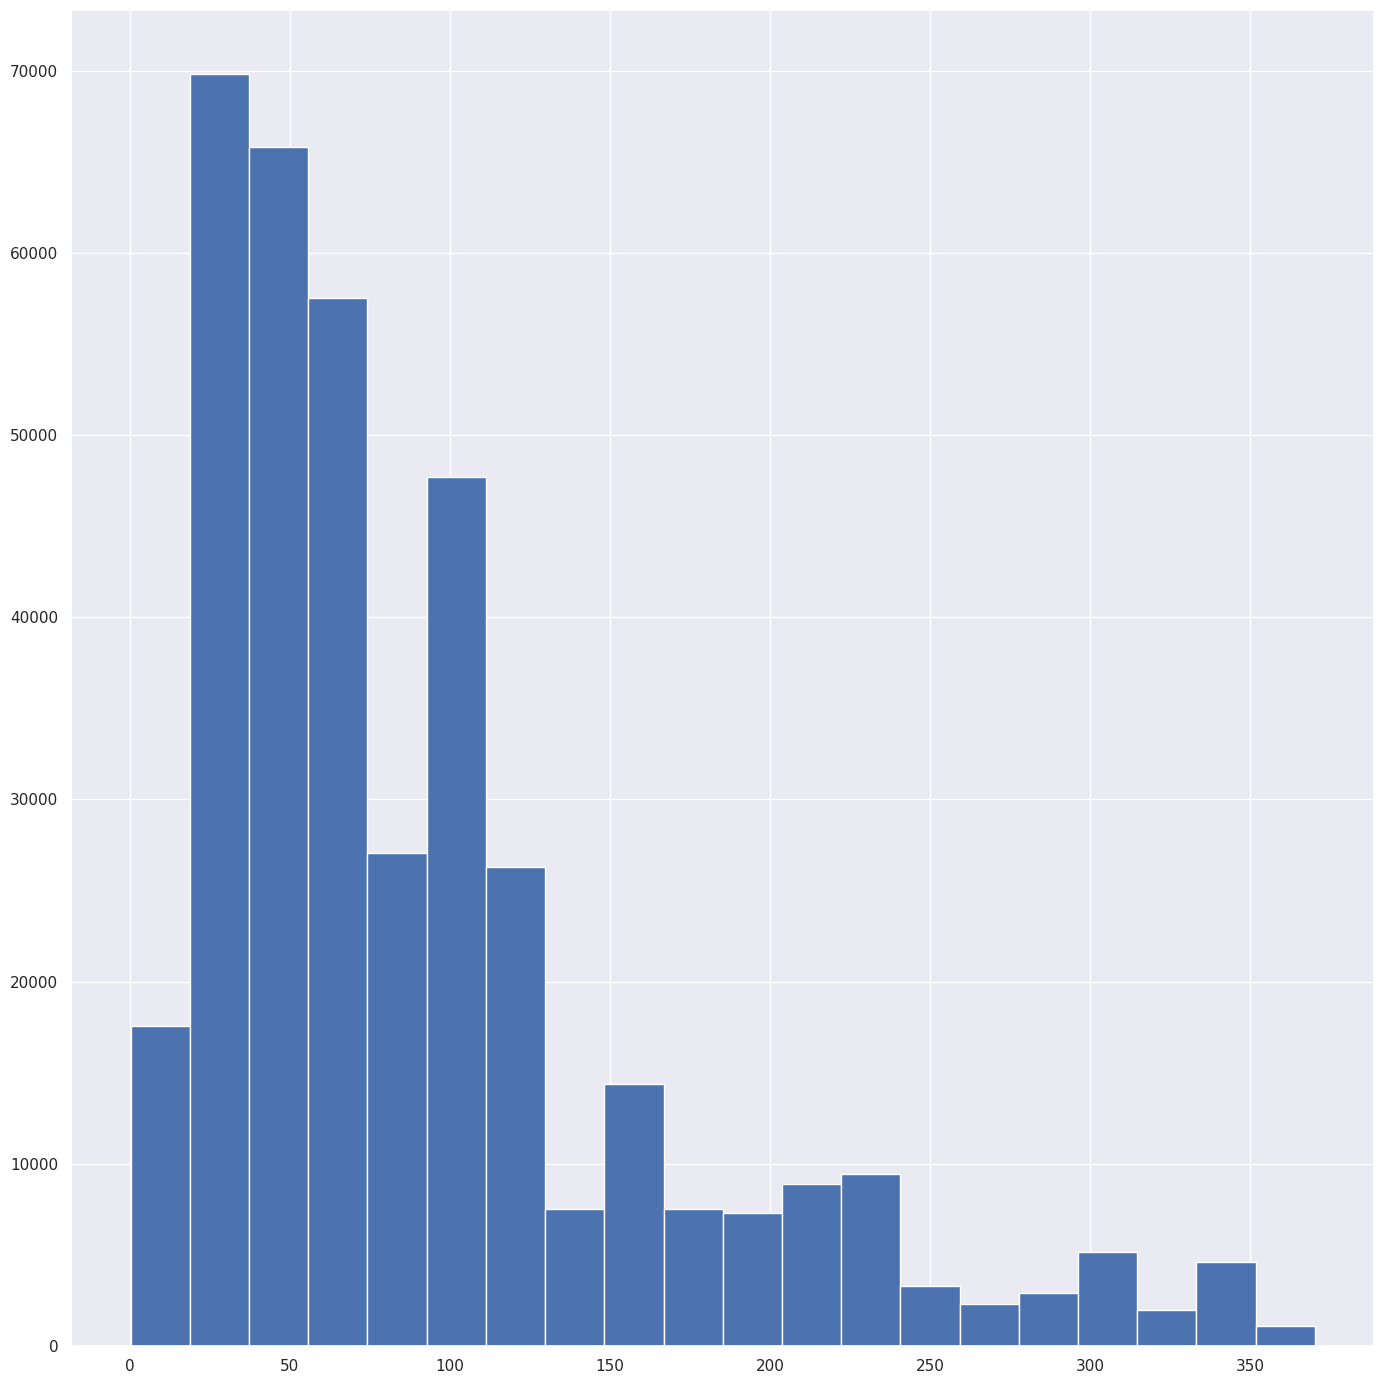

In [247]:
train_data2_with_no_emsns['TransactionAmt'].hist(bins=20, figsize=(14,14))
plt.tight_layout()

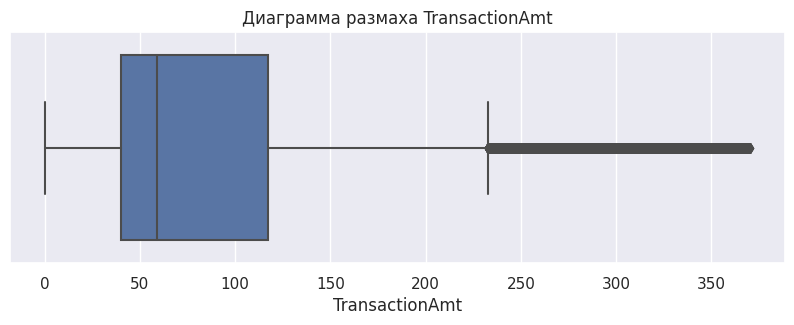

In [248]:
# for feat in train_data2_with_no_emsns[num_feats[:3]].columns:
plt_boxplot(train_data2_with_no_emsns, 'TransactionAmt')

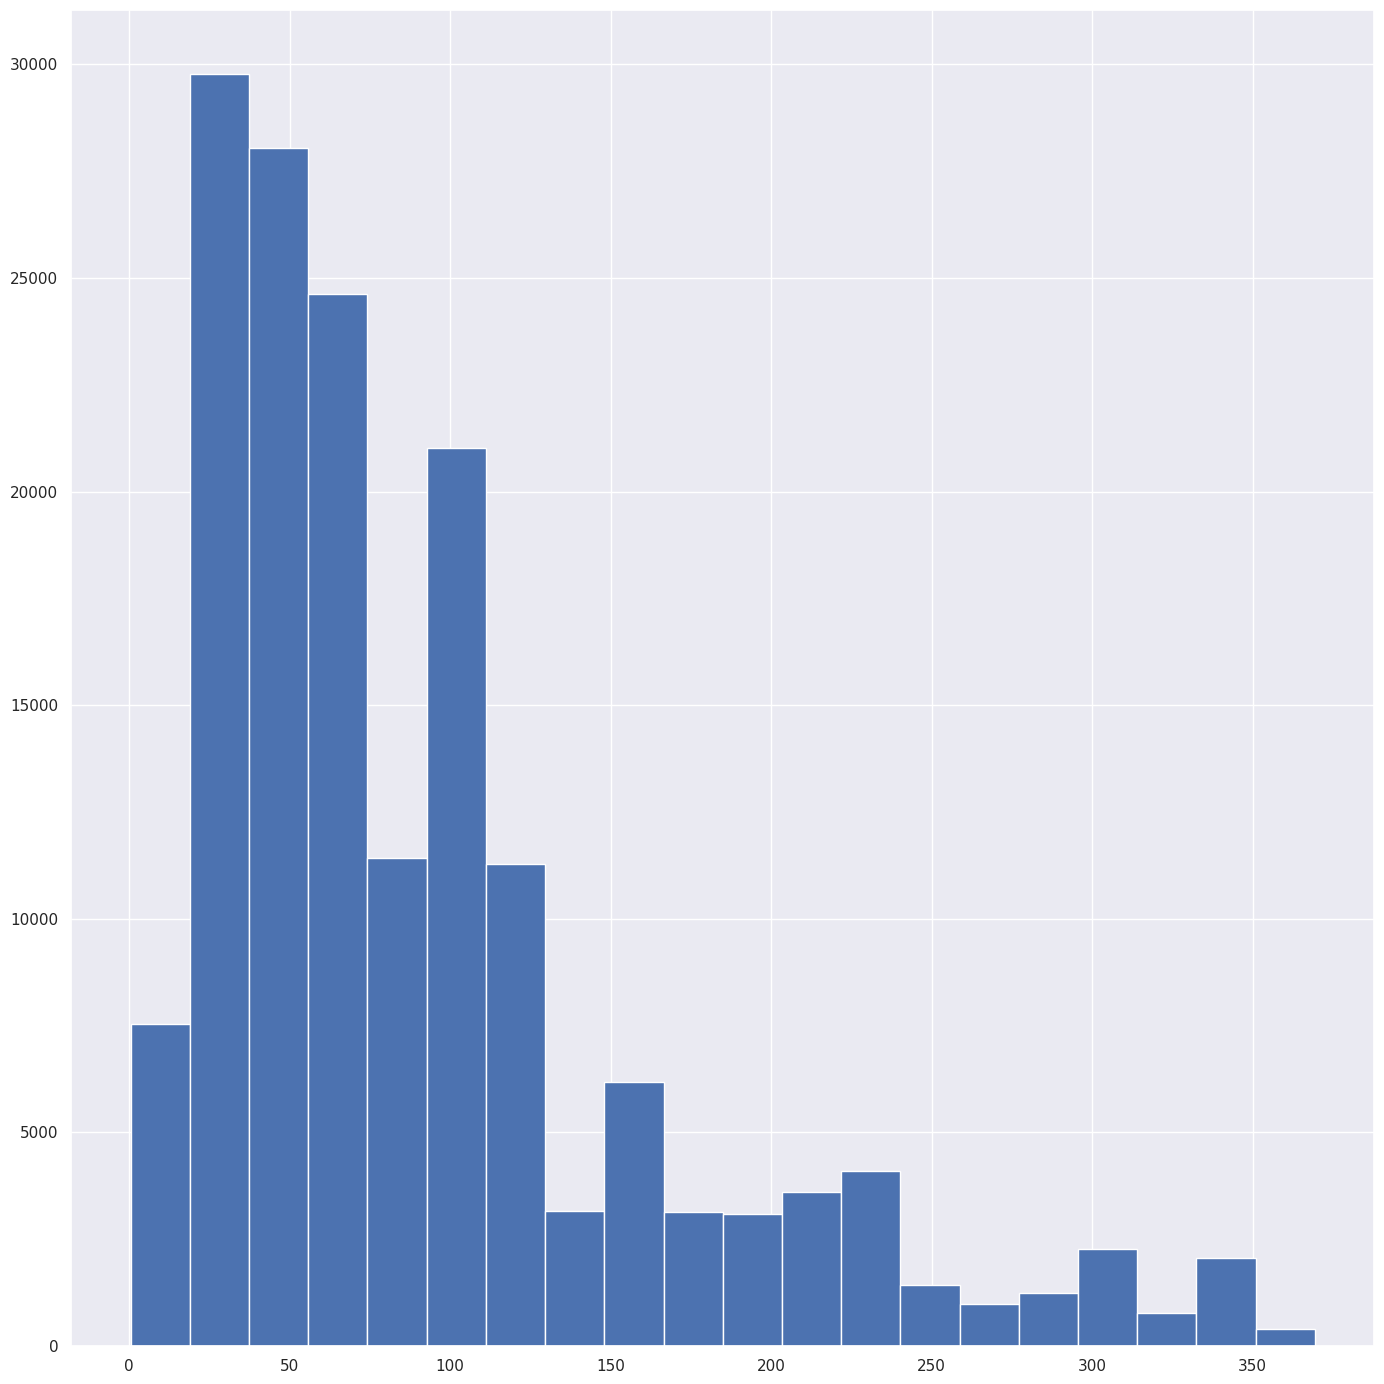

In [249]:
valid_data2_with_no_emsns['TransactionAmt'].hist(bins=20, figsize=(14,14))
plt.tight_layout()

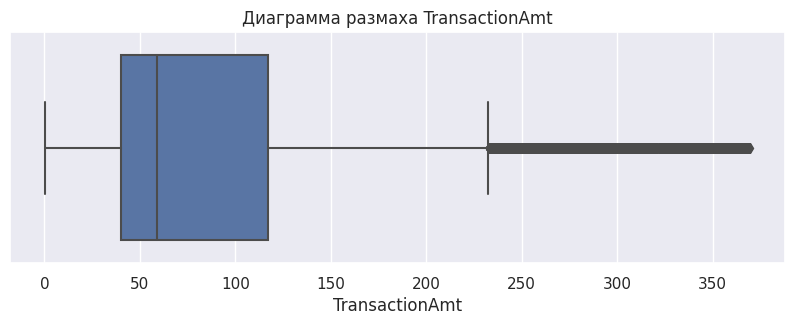

In [250]:
# for feat in valid_data2_with_no_emsns[num_feats[:3]].columns:
plt_boxplot(valid_data2_with_no_emsns, 'TransactionAmt')

Посмотрим на соотношение целевых меток

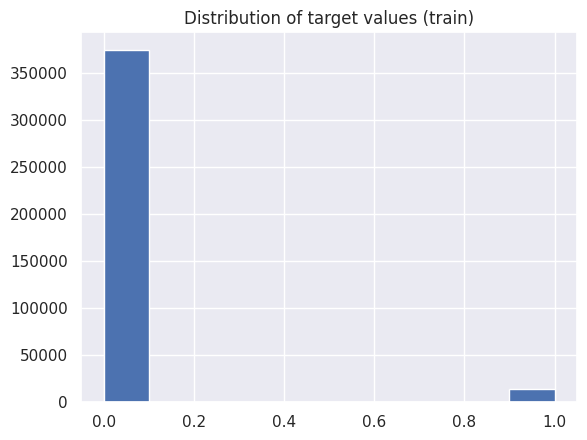

In [251]:
plt.hist(train_data2_with_no_emsns['isFraud'])
plt.title('Distribution of target values (train)')
plt.show()

#### Помним, что у нас дисбаланс классов. Чтобы снова обучать модели, уравняем соотношение двух классов 50 на 50

Посмотрим ещё раз на соответствие размеров данных и целевых меток

In [252]:
X_train_copy2.shape

(413378, 16)

In [253]:
y_train.shape

(413378,)

In [254]:
X_valid_copy2.shape

(177162, 16)

In [255]:
y_valid.shape

(177162,)

In [256]:
test_df_copy2.shape

(506691, 16)

Увеличим число записей мошеннических транзакций до уравнивания долей двух классов

In [257]:
train_data2_with_no_emsns[train_data2_with_no_emsns['isFraud']==1]

TransactionID  TransactionDT  TransactionAmt  ProductCD  card1  card2  \
240           2987240          90193       37.098000          0  13413  103.0   
243           2987243          90246       37.098000          0  13413  103.0   
245           2987245          90295       37.098000          0  13413  103.0   
288           2987288          90986      155.520996          0  16578  545.0   
367           2987367          92350      225.000000          2   4425  562.0   
...               ...            ...             ...        ...    ...    ...   
590354        3577354       15807171      125.665001          0  14337  228.0   
590364        3577364       15807516       69.963997          0   5812  408.0   
590368        3577368       15807677      100.000000          1   6758  399.0   
590372        3577372       15807758      117.000000          4  14037  111.0   
590526        3577526       15810876      250.000000          2   1214  174.0   

        card4  card5  card6  addr1  addr2  P_emaildomain    D3  V55  V281  \
240         4  137.0      1   -1.0   -1.0             19   8.0  1.0   0.0   
243         4  137.0      1   -1.0   -1.0             19   8.0  1.0   0.0   
245         4  137.0      1   -1.0   -1.0             19   8.0  1.0   0.0   
288         4  226.0      1   -1.0   -1.0             36   8.0  1.0   0.0   
367         2  197.0      1  472.0   87.0             16   8.0  1.0   0.0   
...       ...    ...    ...    ...    ...            ...   ...  ...   ...   
590354      4  137.0      2   -1.0   -1.0             16   8.0  1.0   0.0   
590364      2  224.0      2   -1.0   -1.0             19  20.0  1.0   0.0   
590368      0  146.0      1  299.0   87.0             19   8.0  1.0   0.0   
590372      4  226.0      1  272.0   87.0             54   8.0  1.0   0.0   
590526      4  226.0      1  272.0   87.0             16   8.0  1.0   0.0   

        V286  isFraud  
240      0.0        1  
243      0.0        1  
245      0.0        1  
288      0.0        1  
367      0.0        1  
...      ...      ...  
590354   0.0        1  
590364   0.0        1  
590368   0.0        1  
590372   0.0        1  
590526   0.0        1  

[13154 rows x 17 columns]

In [258]:
train_target = train_data2_with_no_emsns['isFraud']
train_data2_1_increased = pd.concat(
    [train_data2_with_no_emsns[train_target==1] \
    for i in range(24)])
train_data2_1_increased

TransactionID  TransactionDT  TransactionAmt  ProductCD  card1  card2  \
240           2987240          90193       37.098000          0  13413  103.0   
243           2987243          90246       37.098000          0  13413  103.0   
245           2987245          90295       37.098000          0  13413  103.0   
288           2987288          90986      155.520996          0  16578  545.0   
367           2987367          92350      225.000000          2   4425  562.0   
...               ...            ...             ...        ...    ...    ...   
590354        3577354       15807171      125.665001          0  14337  228.0   
590364        3577364       15807516       69.963997          0   5812  408.0   
590368        3577368       15807677      100.000000          1   6758  399.0   
590372        3577372       15807758      117.000000          4  14037  111.0   
590526        3577526       15810876      250.000000          2   1214  174.0   

        card4  card5  card6  addr1  addr2  P_emaildomain    D3  V55  V281  \
240         4  137.0      1   -1.0   -1.0             19   8.0  1.0   0.0   
243         4  137.0      1   -1.0   -1.0             19   8.0  1.0   0.0   
245         4  137.0      1   -1.0   -1.0             19   8.0  1.0   0.0   
288         4  226.0      1   -1.0   -1.0             36   8.0  1.0   0.0   
367         2  197.0      1  472.0   87.0             16   8.0  1.0   0.0   
...       ...    ...    ...    ...    ...            ...   ...  ...   ...   
590354      4  137.0      2   -1.0   -1.0             16   8.0  1.0   0.0   
590364      2  224.0      2   -1.0   -1.0             19  20.0  1.0   0.0   
590368      0  146.0      1  299.0   87.0             19   8.0  1.0   0.0   
590372      4  226.0      1  272.0   87.0             54   8.0  1.0   0.0   
590526      4  226.0      1  272.0   87.0             16   8.0  1.0   0.0   

        V286  isFraud  
240      0.0        1  
243      0.0        1  
245      0.0        1  
288      0.0        1  
367      0.0        1  
...      ...      ...  
590354   0.0        1  
590364   0.0        1  
590368   0.0        1  
590372   0.0        1  
590526   0.0        1  

[315696 rows x 17 columns]

Проведём конкатенацию датафрейма с увеличенным размером данных класса 1 с ьекущим датафреймом

In [259]:
train_target = train_data2_with_no_emsns['isFraud']
train_data2_balanced = pd.concat([
    train_data2_with_no_emsns[train_target==0], train_data2_1_increased
])
train_data2_balanced = train_data2_balanced.sort_values('TransactionDT')
train_data2_balanced

TransactionID  TransactionDT  TransactionAmt  ProductCD  card1  card2  \
1             2987001          86401       29.000000          4   2755  404.0   
5             2987005          86510       49.000000          4   5937  555.0   
6             2987006          86522      159.000000          4  12308  360.0   
8             2987008          86535       15.000000          1   2803  100.0   
9             2987009          86536      117.000000          4  17399  111.0   
...               ...            ...             ...        ...    ...    ...   
590533        3577533       15811029      107.949997          4  13071  321.0   
590535        3577535       15811047       49.000000          4   6550   -1.0   
590536        3577536       15811049       39.500000          4  10444  225.0   
590537        3577537       15811079       30.950001          4  12037  595.0   
590539        3577539       15811131      279.950012          4  15066  170.0   

        card4  card5  card6  addr1  addr2  P_emaildomain    D3  V55  V281  \
1           2  102.0      1  325.0   87.0             16   8.0  1.0   0.0   
5           4  226.0      2  272.0   87.0             16   8.0  1.0   0.0   
6           4  166.0      2  126.0   87.0             54   8.0  1.0   0.0   
8           4  226.0      2  337.0   87.0              1   8.0  1.0   0.0   
9           2  224.0      2  204.0   87.0             54  30.0  1.0   0.0   
...       ...    ...    ...    ...    ...            ...   ...  ...   ...   
590533      4  226.0      2  485.0   87.0             16   6.0  1.0   0.0   
590535      4  226.0      2  272.0   87.0             32  30.0  1.0   0.0   
590536      2  224.0      2  204.0   87.0             16   8.0  1.0   0.0   
590537      2  224.0      2  231.0   87.0             16   8.0  1.0   0.0   
590539      2  102.0      1  299.0   87.0             16   0.0  1.0   0.0   

        V286  isFraud  
1        0.0        0  
5        0.0        0  
6        0.0        0  
8        0.0        0  
9        0.0        0  
...      ...      ...  
590533   0.0        0  
590535   0.0        0  
590536   0.0        0  
590537   0.0        0  
590539   0.0        0  

[690515 rows x 17 columns]

Посмотрим на соотношение классов после уравнивания

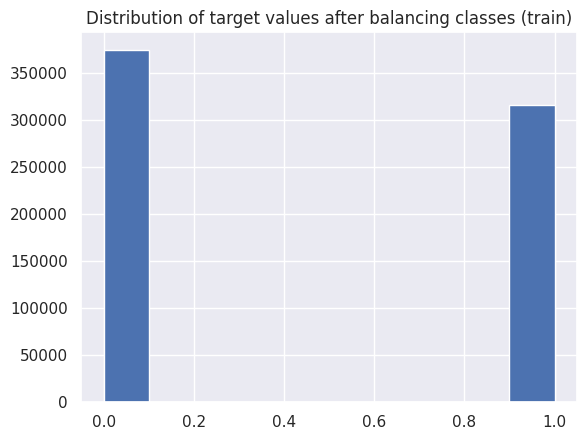

In [260]:
plt.hist(train_data2_balanced['isFraud'])
plt.title('Distribution of target values after balancing classes (train)')
plt.show()

Теперь отделим данные от целевых меток и снова приступим к созданию и обучению моделей

In [261]:
y_train2_balanced = train_data2_balanced['isFraud']
X_train2_balanced = train_data2_balanced.drop(columns=['isFraud'])

In [262]:
X_train2_balanced.shape

(690515, 16)

In [263]:
y_train2_balanced.shape

(690515,)

In [264]:
y_valid2 = valid_data2_with_no_emsns['isFraud']
X_valid2 = valid_data2_with_no_emsns.drop(columns=['isFraud'])

In [265]:
X_valid2.shape

(166075, 16)

In [266]:
y_valid2.shape

(166075,)

In [267]:
X_train2_balanced.isna().sum()

TransactionID     0
TransactionDT     0
TransactionAmt    0
ProductCD         0
card1             0
card2             0
card4             0
card5             0
card6             0
addr1             0
addr2             0
P_emaildomain     0
D3                0
V55               0
V281              0
V286              0
dtype: int64

In [268]:
X_valid2.isna().sum()

TransactionID     0
TransactionDT     0
TransactionAmt    0
ProductCD         0
card1             0
card2             0
card4             0
card5             0
card6             0
addr1             0
addr2             0
P_emaildomain     0
D3                0
V55               0
V281              0
V286              0
dtype: int64

#### Посмотрим на прогнозы лог. регрессии

In [269]:
model_LR_median_fill = LogisticRegression()
model_LR_median_fill.fit(X_train2_balanced, y_train2_balanced)

LogisticRegression()

In [270]:
y_pred_valid_LR_median_fill = model_LR_median_fill.predict(X_valid2)

In [271]:
print(f'Доля верно угаданных объектов {(y_pred_valid_LR_median_fill == y_valid2).sum() / len(y_valid2)}')

Доля верно угаданных объектов 0.9661478247779618


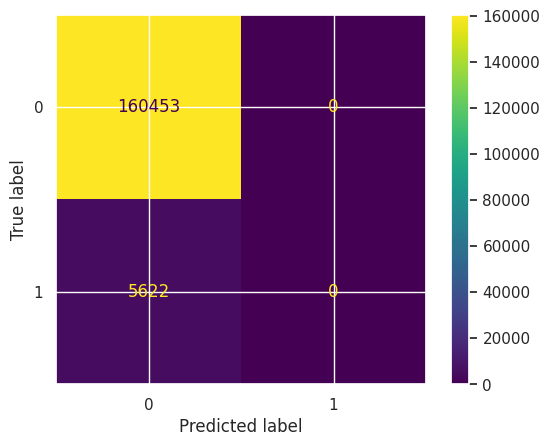

In [272]:
conf_matrix(y_valid2, y_pred_valid_LR_median_fill)

In [273]:
print(classification_report(y_valid2, y_pred_valid_LR_median_fill))

              precision    recall  f1-score   support

           0       0.97      1.00      0.98    160453
           1       0.00      0.00      0.00      5622

    accuracy                           0.97    166075
   macro avg       0.48      0.50      0.49    166075
weighted avg       0.93      0.97      0.95    166075



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Видим, что точность достаточна низкая, масштабируем признаки для лог. регрессии

In [274]:
X_train2_balanced2 = X_train2_balanced.drop(columns=['TransactionID'])
X_train2_balanced2

TransactionDT  TransactionAmt  ProductCD  card1  card2  card4  card5  \
1               86401       29.000000          4   2755  404.0      2  102.0   
5               86510       49.000000          4   5937  555.0      4  226.0   
6               86522      159.000000          4  12308  360.0      4  166.0   
8               86535       15.000000          1   2803  100.0      4  226.0   
9               86536      117.000000          4  17399  111.0      2  224.0   
...               ...             ...        ...    ...    ...    ...    ...   
590533       15811029      107.949997          4  13071  321.0      4  226.0   
590535       15811047       49.000000          4   6550   -1.0      4  226.0   
590536       15811049       39.500000          4  10444  225.0      2  224.0   
590537       15811079       30.950001          4  12037  595.0      2  224.0   
590539       15811131      279.950012          4  15066  170.0      2  102.0   

        card6  addr1  addr2  P_emaildomain    D3  V55  V281  V286  
1           1  325.0   87.0             16   8.0  1.0   0.0   0.0  
5           2  272.0   87.0             16   8.0  1.0   0.0   0.0  
6           2  126.0   87.0             54   8.0  1.0   0.0   0.0  
8           2  337.0   87.0              1   8.0  1.0   0.0   0.0  
9           2  204.0   87.0             54  30.0  1.0   0.0   0.0  
...       ...    ...    ...            ...   ...  ...   ...   ...  
590533      2  485.0   87.0             16   6.0  1.0   0.0   0.0  
590535      2  272.0   87.0             32  30.0  1.0   0.0   0.0  
590536      2  204.0   87.0             16   8.0  1.0   0.0   0.0  
590537      2  231.0   87.0             16   8.0  1.0   0.0   0.0  
590539      1  299.0   87.0             16   0.0  1.0   0.0   0.0  

[690515 rows x 15 columns]

In [275]:
X_valid3 = X_valid2.drop(columns=['TransactionID'])
X_valid3

TransactionDT  TransactionAmt  ProductCD  card1  card2  card4  card5  \
0               86400       68.500000          4  13926   -1.0      1  142.0   
2               86469       59.000000          4   4663  490.0      4  166.0   
3               86499       50.000000          4  18132  567.0      2  117.0   
4               86506       50.000000          1   4497  514.0      2  102.0   
11              86555       16.495001          0   4461  375.0      2  224.0   
...               ...             ...        ...    ...    ...    ...    ...   
590524       15810836       75.000000          4   7826  481.0      2  224.0   
590527       15810883      189.949997          4   6453  555.0      4  226.0   
590532       15811007      204.970001          4  12037  595.0      2  224.0   
590534       15811030       67.504997          0   5812  408.0      2  224.0   
590538       15811088      117.000000          4   7826  481.0      2  224.0   

        card6  addr1  addr2  P_emaildomain     D3  V55  V281  V286  
0           1  315.0   87.0             32   13.0  1.0   0.0   0.0  
2           2  330.0   87.0             36    8.0  1.0   0.0   0.0  
3           2  476.0   87.0             54    0.0  1.0   0.0   0.0  
4           1  420.0   87.0             16    8.0  1.0   0.0   0.0  
11          2   -1.0   -1.0             19    8.0  1.0   0.0   0.0  
...       ...    ...    ...            ...    ...  ...   ...   ...  
590524      2  387.0   87.0             16    8.0  1.0   0.0   0.0  
590527      2  264.0   87.0              2    6.0  1.0   0.0   0.0  
590532      2  231.0   87.0             35  315.0  1.0   0.0   0.0  
590534      2   -1.0   -1.0             16    8.0  1.0   0.0   0.0  
590538      2  387.0   87.0              2    0.0  1.0   0.0   0.0  

[166075 rows x 15 columns]

In [276]:
test_df_copy3 = test_df_copy2.drop(columns=['TransactionID'])
test_df_copy3

TransactionDT  TransactionAmt  ProductCD  card1  card2  card4  card5  \
0            18403224       31.950001          4  10409  111.0      4  226.0   
1            18403263       49.000000          4   4272  111.0      4  226.0   
2            18403310      171.000000          4   4476  574.0      4  226.0   
3            18403310      284.950012          4  10989  360.0      4  166.0   
4            18403317       67.949997          4  18018  452.0      2  117.0   
...               ...             ...        ...    ...    ...    ...    ...   
506686       34214279       94.679001          0  13832  375.0      2  224.0   
506687       34214287       12.173000          0   3154  408.0      2  224.0   
506688       34214326       49.000000          4  16661  490.0      4  226.0   
506689       34214337      202.000000          4  16621  516.0      2  224.0   
506690       34214345       24.346001          0   5713  168.0      4  147.0   

        card6  addr1  addr2  P_emaildomain    D3  V55  V281  V286  
0           2  170.0   87.0             16  27.0  1.0   0.0   0.0  
1           2  299.0   87.0              2   7.0  1.0   0.0   0.0  
2           2  472.0   87.0             19  10.0  1.0   0.0   0.0  
3           2  205.0   87.0             16  41.0  1.0   0.0   0.0  
4           2  264.0   87.0             16   0.0  1.0   0.0   1.0  
...       ...    ...    ...            ...   ...  ...   ...   ...  
506686      2  284.0   60.0             16   7.0  1.0   0.0   0.0  
506687      2   -1.0   -1.0             19  16.0  2.0   1.0   0.0  
506688      2  327.0   87.0             19   7.0  1.0   0.0   0.0  
506689      2  177.0   87.0             19   7.0  1.0   0.0   0.0  
506690      1   -1.0   -1.0             19   7.0  1.0   0.0   0.0  

[506691 rows x 15 columns]

In [277]:
scaler = StandardScaler()
scaler.fit(X_train2_balanced2, y_train2_balanced)
X_train2_sc = pd.DataFrame(scaler.transform(X_train2_balanced2),
                          index=X_train2_balanced2.index,
                          columns=X_train2_balanced2.columns)
X_valid2_sc = pd.DataFrame(scaler.transform(X_valid3),
                          index=X_valid3.index,
                          columns=X_valid3.columns)

In [278]:
test_df2_sc = pd.DataFrame(scaler.transform(test_df_copy3),
                          index=test_df_copy3.index,
                          columns=test_df_copy3.columns)

In [279]:
test_df2_sc

TransactionDT  TransactionAmt  ProductCD     card1     card2  \
0            2.406425       -0.785363   0.789763  0.138341 -1.493255   
1            2.406434       -0.564295   0.789763 -1.134489 -1.493255   
2            2.406444        1.017546   0.789763 -1.092179  1.329542   
3            2.406444        2.495010   0.789763  0.258634  0.024837   
4            2.406446       -0.318591   0.789763  1.716467  0.585738   
...               ...             ...        ...       ...       ...   
506686       5.893162        0.027975  -1.488871  0.848280  0.116288   
506687       5.893164       -1.041790  -1.488871 -1.366365  0.317481   
506688       5.893172       -0.564295   0.789763  1.435022  0.817415   
506689       5.893175        1.419489   0.789763  1.426726  0.975930   
506690       5.893176       -0.883956  -1.488871 -0.835622 -1.145740   

           card4     card5     card6     addr1     addr2  P_emaildomain  \
0       0.712279  0.680359  0.689391 -0.321426  0.583253      -0.506305   
1       0.712279  0.680359  0.689391  0.512215  0.583253      -1.421553   
2       0.712279  0.680359  0.689391  1.630199  0.583253      -0.310181   
3       0.712279 -0.605820  0.689391 -0.095244  0.583253      -0.506305   
4      -1.216986 -1.656200  0.689391  0.286034  0.583253      -0.506305   
...          ...       ...       ...       ...       ...            ...   
506686 -1.216986  0.637486  0.689391  0.415280 -0.128187      -0.506305   
506687 -1.216986  0.637486  0.689391 -1.426485 -1.735515      -0.310181   
506688  0.712279  0.680359  0.689391  0.693161  0.583253      -0.310181   
506689 -1.216986  0.637486  0.689391 -0.276189  0.583253      -0.310181   
506690  0.712279 -1.013111 -1.363642 -1.426485 -1.735515      -0.310181   

              D3       V55      V281      V286  
0       0.284850 -0.214193 -0.224089 -0.171676  
1      -0.201221 -0.214193 -0.224089 -0.171676  
2      -0.128311 -0.214193 -0.224089 -0.171676  
3       0.625101 -0.214193 -0.224089 -0.171676  
4      -0.371347 -0.214193 -0.224089  4.892823  
...          ...       ...       ...       ...  
506686 -0.201221 -0.214193 -0.224089 -0.171676  
506687  0.017511  1.948011  1.105377 -0.171676  
506688 -0.201221 -0.214193 -0.224089 -0.171676  
506689 -0.201221 -0.214193 -0.224089 -0.171676  
506690 -0.201221 -0.214193 -0.224089 -0.171676  

[506691 rows x 15 columns]

Масштабирование с помощью RobustScaler

In [280]:
rscaler = RobustScaler()
rscaler.fit(X_train2_balanced2, y_train2_balanced)
X_train2_rsc = pd.DataFrame(rscaler.transform(X_train2_balanced2),
                          index=X_train2_balanced2.index,
                          columns=X_train2_balanced2.columns)
X_valid2_rsc = pd.DataFrame(rscaler.transform(X_valid3),
                          index=X_valid3.index,
                          columns=X_valid3.columns)

Построим лог. регрессию на новых данных (StandardScaler)

In [281]:
model_LR2_sc = LogisticRegression()
model_LR2_sc.fit(X_train2_sc, y_train2_balanced)
y_pred_LR2_sc = model_LR2_sc.predict(X_valid2_sc)
print(f'Доля верно угаданных объектов {(y_pred_LR2_sc == y_valid2).sum()/len(y_valid2)}')

Доля верно угаданных объектов 0.7930814391088363


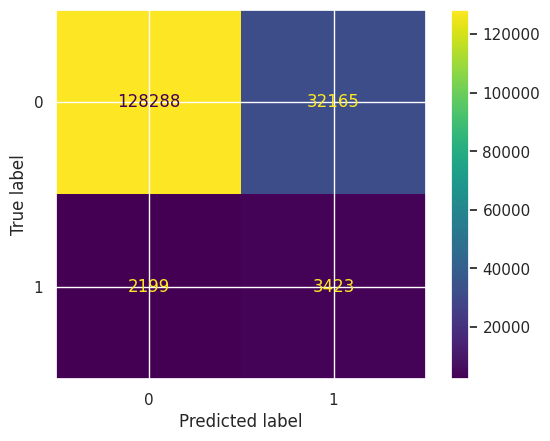

In [282]:
conf_matrix(y_valid2, y_pred_LR2_sc)

In [283]:
print(classification_report(y_valid2, y_pred_LR2_sc))

              precision    recall  f1-score   support

           0       0.98      0.80      0.88    160453
           1       0.10      0.61      0.17      5622

    accuracy                           0.79    166075
   macro avg       0.54      0.70      0.52    166075
weighted avg       0.95      0.79      0.86    166075



Видим, что точность прогнозов значительно выросла

Лог. регрессия (RobustScaler)

In [284]:
model_LR2_rsc = LogisticRegression()
model_LR2_rsc.fit(X_train2_rsc, y_train2_balanced)
y_pred_LR2_rsc = model_LR2_rsc.predict(X_valid2_rsc)
print(f'Доля верно угаданных объектов {(y_pred_LR2_rsc == y_valid2).sum()/len(y_valid2)}')

Доля верно угаданных объектов 0.7930934818606051


### Прогнозы ансамблевых алгоритмов на немасштабированных данных

------------------------------
DecisionTree
Доля верно угаданных объектов 0.9637332530483216


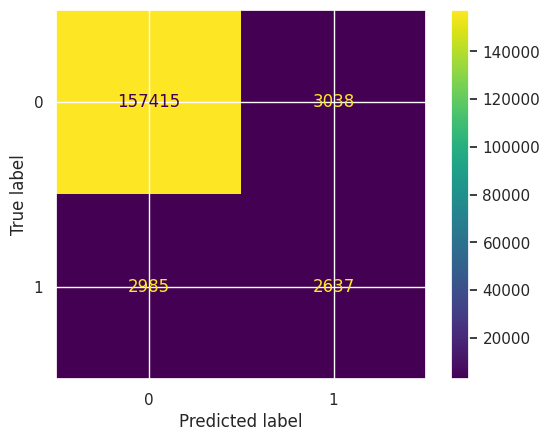

              precision    recall  f1-score   support

           0       0.98      0.98      0.98    160453
           1       0.46      0.47      0.47      5622

    accuracy                           0.96    166075
   macro avg       0.72      0.73      0.72    166075
weighted avg       0.96      0.96      0.96    166075

roc auc score:  0.725058133335554


In [285]:
DTmodel_median, DTmodel_median_roc_auc_score = fit_pred_score(DecisionTreeClassifier(), 'DecisionTree', X_train2_balanced2, y_train2_balanced, X_valid3, y_valid2)

------------------------------
RandomForest
Доля верно угаданных объектов 0.9764805057955743


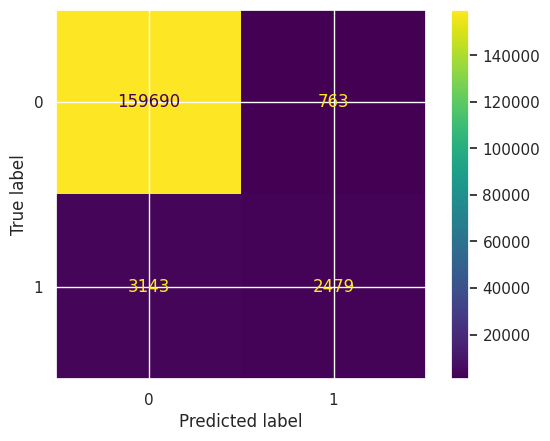

              precision    recall  f1-score   support

           0       0.98      1.00      0.99    160453
           1       0.76      0.44      0.56      5622

    accuracy                           0.98    166075
   macro avg       0.87      0.72      0.77    166075
weighted avg       0.97      0.98      0.97    166075

roc auc score:  0.9134088767660021


In [286]:
RF_median, RF_median_roc_auc_score = fit_pred_score(RandomForestClassifier(), 'RandomForest', X_train2_balanced2, y_train2_balanced, X_valid3, y_valid2)

------------------------------
AdaBoost
Доля верно угаданных объектов 0.8006804154749361


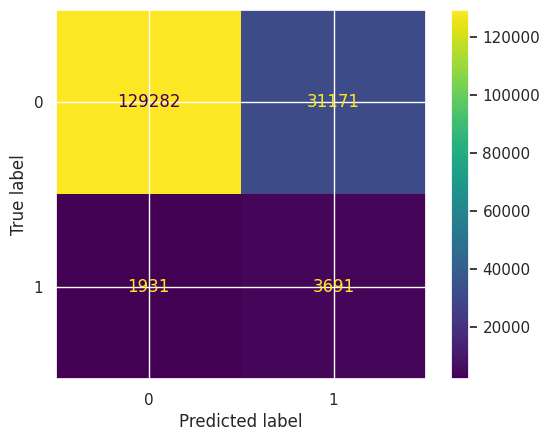

              precision    recall  f1-score   support

           0       0.99      0.81      0.89    160453
           1       0.11      0.66      0.18      5622

    accuracy                           0.80    166075
   macro avg       0.55      0.73      0.53    166075
weighted avg       0.96      0.80      0.86    166075

roc auc score:  0.8065571096541206


In [287]:
AdaBoost_median, AdaBoost_median_roc_auc_score = fit_pred_score(AdaBoostClassifier(), 'AdaBoost', X_train2_balanced2, y_train2_balanced, X_valid3, y_valid2)

------------------------------
GradientBoosting
Доля верно угаданных объектов 0.807171458678308


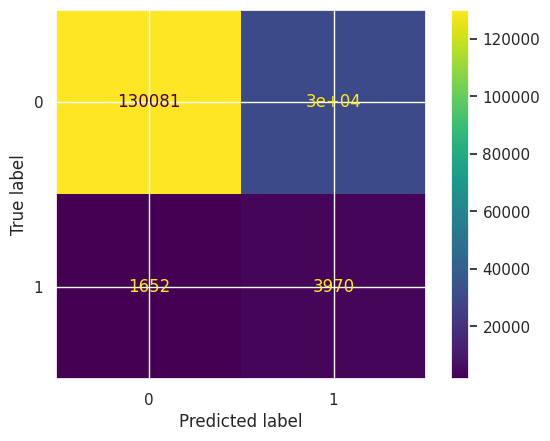

              precision    recall  f1-score   support

           0       0.99      0.81      0.89    160453
           1       0.12      0.71      0.20      5622

    accuracy                           0.81    166075
   macro avg       0.55      0.76      0.54    166075
weighted avg       0.96      0.81      0.87    166075

roc auc score:  0.8362255011842438


In [288]:
GBM_median_model, GBM_median_roc_auc_score = fit_pred_score(GradientBoostingClassifier(), 'GradientBoosting', X_train2_balanced2, y_train2_balanced, X_valid3, y_valid2)

------------------------------
XGB
Доля верно угаданных объектов 0.8719855486978775


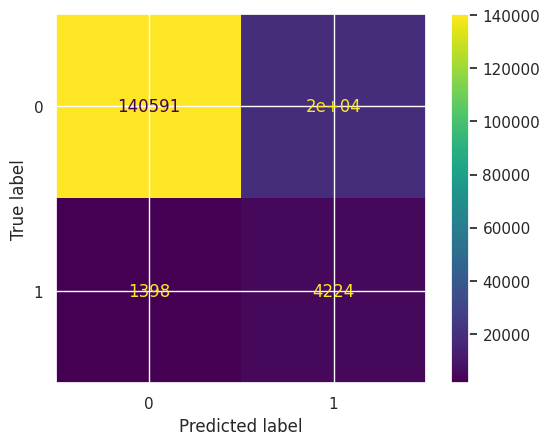

              precision    recall  f1-score   support

           0       0.99      0.88      0.93    160453
           1       0.18      0.75      0.28      5622

    accuracy                           0.87    166075
   macro avg       0.58      0.81      0.61    166075
weighted avg       0.96      0.87      0.91    166075

roc auc score:  0.896705506718557


In [289]:
XGB_median_model, XGB_median_roc_auc_score = fit_pred_score(XGBClassifier(), 'XGB', X_train2_balanced2, y_train2_balanced, X_valid3, y_valid2)

------------------------------
LGBM
Доля верно угаданных объектов 0.8395182899292488


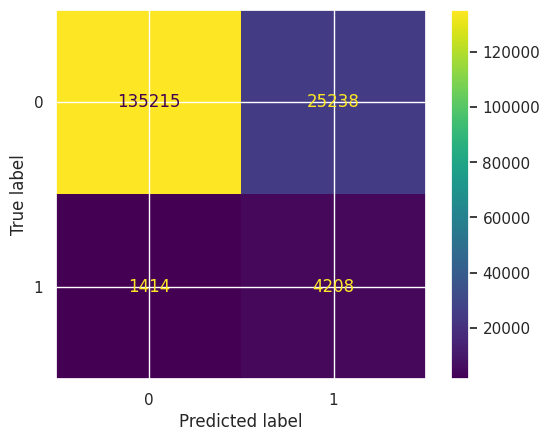

              precision    recall  f1-score   support

           0       0.99      0.84      0.91    160453
           1       0.14      0.75      0.24      5622

    accuracy                           0.84    166075
   macro avg       0.57      0.80      0.58    166075
weighted avg       0.96      0.84      0.89    166075

roc auc score:  0.8749264857630282


In [290]:
LGBM_median_model, LGBM_median_roc_auc_score = fit_pred_score(LGBMClassifier(), 'LGBM', X_train2_balanced2, y_train2_balanced, X_valid3, y_valid2)

### Прогнозы ансамблевых моделей на масштабированных данных

------------------------------
DecisionTree
Доля верно угаданных объектов 0.9637814240553967


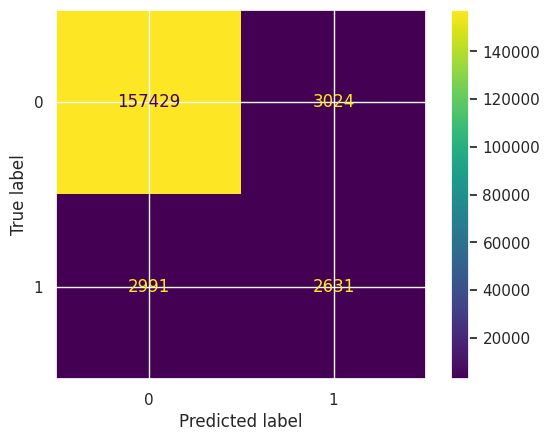

              precision    recall  f1-score   support

           0       0.98      0.98      0.98    160453
           1       0.47      0.47      0.47      5622

    accuracy                           0.96    166075
   macro avg       0.72      0.72      0.72    166075
weighted avg       0.96      0.96      0.96    166075

roc auc score:  0.7245681418885129


In [291]:
DTmodel_med_sc, DTmodel_med_sc_roc_auc_score = fit_pred_score(DecisionTreeClassifier(), 'DecisionTree', X_train2_sc, y_train2_balanced, X_valid2_sc, y_valid2)

------------------------------
RandomForest
Доля верно угаданных объектов 0.976384163781424


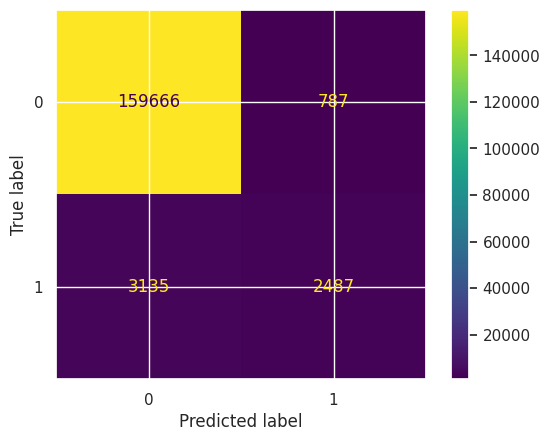

              precision    recall  f1-score   support

           0       0.98      1.00      0.99    160453
           1       0.76      0.44      0.56      5622

    accuracy                           0.98    166075
   macro avg       0.87      0.72      0.77    166075
weighted avg       0.97      0.98      0.97    166075

roc auc score:  0.9127928608335405


In [292]:
RF_med_sc, RF_med_sc_roc_auc_score = fit_pred_score(RandomForestClassifier(), 'RandomForest', X_train2_sc, y_train2_balanced, X_valid2_sc, y_valid2)

------------------------------
AdaBoost
Доля верно угаданных объектов 0.8006743940990516


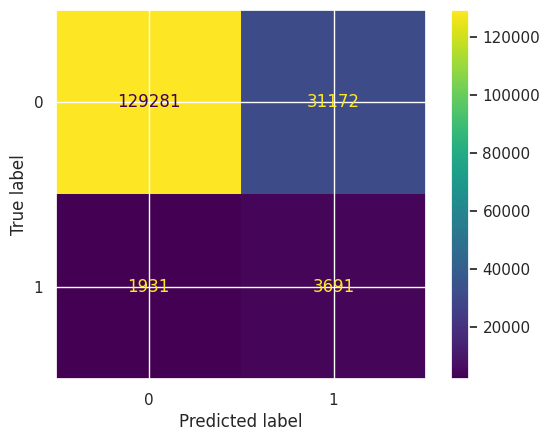

              precision    recall  f1-score   support

           0       0.99      0.81      0.89    160453
           1       0.11      0.66      0.18      5622

    accuracy                           0.80    166075
   macro avg       0.55      0.73      0.53    166075
weighted avg       0.96      0.80      0.86    166075

roc auc score:  0.806555389160629


In [293]:
AdaBoost_med_model, AdaBoost_med_roc_auc_score = fit_pred_score(AdaBoostClassifier(), 'AdaBoost', X_train2_sc, y_train2_balanced, X_valid2_sc, y_valid2)

------------------------------
GradientBoosting
Доля верно угаданных объектов 0.807171458678308


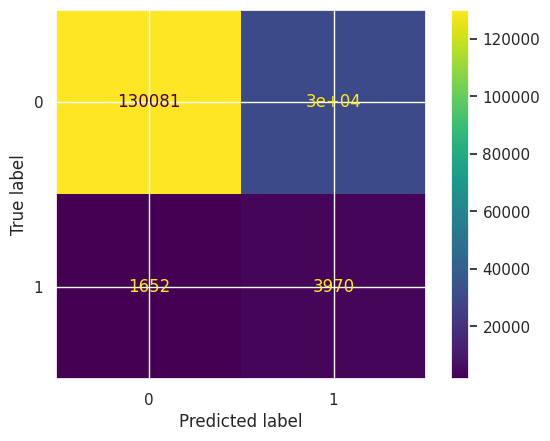

              precision    recall  f1-score   support

           0       0.99      0.81      0.89    160453
           1       0.12      0.71      0.20      5622

    accuracy                           0.81    166075
   macro avg       0.55      0.76      0.54    166075
weighted avg       0.96      0.81      0.87    166075

roc auc score:  0.8362250710608709


In [294]:
GBM_med_model, GBM_med_roc_auc_score = fit_pred_score(GradientBoostingClassifier(), 'GradientBoosting', X_train2_sc, y_train2_balanced, X_valid2_sc, y_valid2)

------------------------------
XGB
Доля верно угаданных объектов 0.8719855486978775


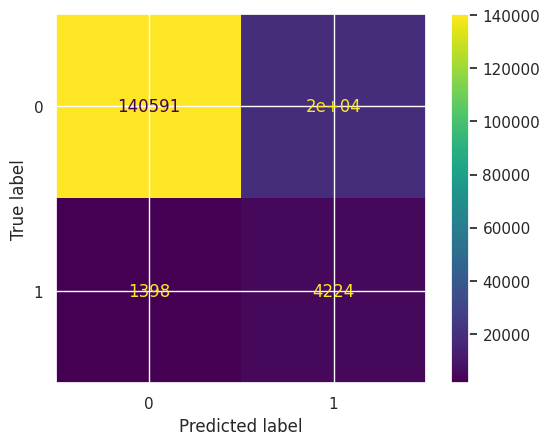

              precision    recall  f1-score   support

           0       0.99      0.88      0.93    160453
           1       0.18      0.75      0.28      5622

    accuracy                           0.87    166075
   macro avg       0.58      0.81      0.61    166075
weighted avg       0.96      0.87      0.91    166075

roc auc score:  0.8967060709783428


In [295]:
XGB_med_model, XGB_med_roc_auc_score = fit_pred_score(XGBClassifier(), 'XGB', X_train2_sc, y_train2_balanced, X_valid2_sc, y_valid2)

------------------------------
LGBM
Доля верно угаданных объектов 0.8395303326810176


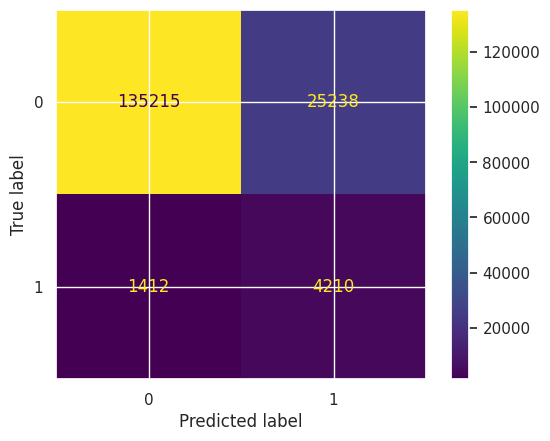

              precision    recall  f1-score   support

           0       0.99      0.84      0.91    160453
           1       0.14      0.75      0.24      5622

    accuracy                           0.84    166075
   macro avg       0.57      0.80      0.58    166075
weighted avg       0.96      0.84      0.89    166075

roc auc score:  0.8754447982844765


In [296]:
LGBM_med_model, LGBM_med_roc_auc_score = fit_pred_score(LGBMClassifier(), 'LGBM', X_train2_sc, y_train2_balanced, X_valid2_sc, y_valid2)

### Сравним метрики roc auc для четырёх случаев:
- заполнение числовых признаков средними значениями по колонке без масштабирования
- заполнение числовых признаков средними значениями по колонке с масштабированием
- заполнение числовых признаковых медианными значениями по колонке без масштабирования
- заполнение числовых признаков медианными значениями по колонке с масштабированием

In [297]:
roc_auc_general[['roc_auc_score(mean, not sc)', 'roc_auc_score(mean, sc)']]

roc_auc_score(mean, not sc)  roc_auc_score(mean, sc)
DT                           0.756123                 0.757102
RF                           0.911107                 0.910616
AdaBoost                     0.809307                 0.809307
GBM                          0.832951                 0.832950
XGB                          0.893081                 0.893080
LGBM                         0.873134                 0.872604

In [298]:
roc_auc_med = pd.DataFrame(data=[DTmodel_median_roc_auc_score,
                                RF_median_roc_auc_score,
                                AdaBoost_median_roc_auc_score,
                                GBM_median_roc_auc_score,
                                XGB_median_roc_auc_score,
                                LGBM_median_roc_auc_score],
                          index=['DT', 'RF', 'AdaBoost', 'GBM', 'XGB', 'LGBM'],
                          columns=['roc_auc_score(med, no sc)'])
roc_auc_med_sc = pd.DataFrame(data=[DTmodel_med_sc_roc_auc_score,
                                RF_med_sc_roc_auc_score,
                                AdaBoost_med_roc_auc_score,
                                GBM_med_roc_auc_score,
                                XGB_med_roc_auc_score,
                                LGBM_med_roc_auc_score],
                          index=['DT', 'RF', 'AdaBoost', 'GBM', 'XGB', 'LGBM'],
                          columns=['roc_auc_score(med, sc)'])
roc_auc_general2 = pd.concat([
    roc_auc_general[['roc_auc_score(mean, not sc)', 'roc_auc_score(mean, sc)']], 
    roc_auc_med,
    roc_auc_med_sc
], axis=1)
roc_auc_general2

roc_auc_score(mean, not sc)  roc_auc_score(mean, sc)  \
DT                           0.756123                 0.757102   
RF                           0.911107                 0.910616   
AdaBoost                     0.809307                 0.809307   
GBM                          0.832951                 0.832950   
XGB                          0.893081                 0.893080   
LGBM                         0.873134                 0.872604   

          roc_auc_score(med, no sc)  roc_auc_score(med, sc)  
DT                         0.725058                0.724568  
RF                         0.913409                0.912793  
AdaBoost                   0.806557                0.806555  
GBM                        0.836226                0.836225  
XGB                        0.896706                0.896706  
LGBM                       0.874926                0.875445

Видим, что в целом прогнозы для ```roc_auc_score (med sc)``` чуть лучше остальных показателей. Попробуем сделать прогнозы моделями этой группы на тестовых данных и отправить submitы на проверку на Kaggle

Напишем функцию для обучения модели и формирования отчета нужной формы для отправки

Посмотрим на образец формы для отправки

In [299]:
sample_submission.head(10)

TransactionID  isFraud
0        3663549      0.5
1        3663550      0.5
2        3663551      0.5
3        3663552      0.5
4        3663553      0.5
5        3663554      0.5
6        3663555      0.5
7        3663556      0.5
8        3663557      0.5
9        3663558      0.5

In [300]:
y_pred_proba = RF_med_sc.predict_proba(test_df2_sc)[:,1]
y_pred_proba

array([0.  , 0.02, 0.04, ..., 0.03, 0.  , 0.13])

In [301]:
transactionIDs_test

0         3663549
1         3663550
2         3663551
3         3663552
4         3663553
           ...   
506686    4170235
506687    4170236
506688    4170237
506689    4170238
506690    4170239
Name: TransactionID, Length: 506691, dtype: uint32

In [302]:
isFraud_df = pd.DataFrame(data=y_pred_proba,
                        index=transactionIDs_test.index,
                        columns=['isFraud'])
submit_df = pd.concat([transactionIDs_test, isFraud_df], axis=1)
submit_df

TransactionID  isFraud
0             3663549     0.00
1             3663550     0.02
2             3663551     0.04
3             3663552     0.02
4             3663553     0.00
...               ...      ...
506686        4170235     0.13
506687        4170236     0.03
506688        4170237     0.03
506689        4170238     0.00
506690        4170239     0.13

[506691 rows x 2 columns]

In [303]:
submit_df['isFraud'].value_counts()

isFraud
0.01    82686
0.00    78070
0.02    68942
0.03    53247
0.04    41850
        ...  
0.97        2
0.83        2
0.93        1
0.98        1
1.00        1
Name: count, Length: 98, dtype: int64

In [304]:
def fit_pred_final(model, model_name, test_data):
    model.predict(test_data)
    y_pred_proba = model.predict_proba(test_data)[:,1]
    
    isFraud_df = pd.DataFrame(data=y_pred_proba,
                             index=transactionIDs_test.index,
                             columns=['isFraud'])
    submit_df = pd.concat([transactionIDs_test, isFraud_df], axis=1)
    submit_df.to_csv('{}.csv'.format(model_name), index=False)
    return submit_df

In [305]:
rf_submit = fit_pred_final(RF_med_sc, 'RF', test_df2_sc)
rf_submit

TransactionID  isFraud
0             3663549     0.00
1             3663550     0.02
2             3663551     0.04
3             3663552     0.02
4             3663553     0.00
...               ...      ...
506686        4170235     0.13
506687        4170236     0.03
506688        4170237     0.03
506689        4170238     0.00
506690        4170239     0.13

[506691 rows x 2 columns]

In [306]:
ada_boost_submit = fit_pred_final(AdaBoost_med_model, 'AdaBoost', test_df2_sc)
ada_boost_submit

TransactionID   isFraud
0             3663549  0.491276
1             3663550  0.494829
2             3663551  0.493943
3             3663552  0.495143
4             3663553  0.493597
...               ...       ...
506686        4170235  0.508416
506687        4170236  0.505091
506688        4170237  0.494220
506689        4170238  0.494214
506690        4170239  0.508196

[506691 rows x 2 columns]

In [307]:
gbm_submit = fit_pred_final(GBM_med_model, 'GBM', test_df2_sc)
gbm_submit

TransactionID   isFraud
0             3663549  0.135086
1             3663550  0.173435
2             3663551  0.244931
3             3663552  0.195293
4             3663553  0.334750
...               ...       ...
506686        4170235  0.772883
506687        4170236  0.689813
506688        4170237  0.220421
506689        4170238  0.285300
506690        4170239  0.845990

[506691 rows x 2 columns]

In [308]:
xgb_submit = fit_pred_final(XGB_med_model, 'XGB', test_df2_sc)
xgb_submit

TransactionID   isFraud
0             3663549  0.017539
1             3663550  0.040851
2             3663551  0.024207
3             3663552  0.087386
4             3663553  0.005986
...               ...       ...
506686        4170235  0.537381
506687        4170236  0.298653
506688        4170237  0.039030
506689        4170238  0.003772
506690        4170239  0.186285

[506691 rows x 2 columns]

In [309]:
lgbm_submit = fit_pred_final(LGBM_med_model, 'LGBM', test_df2_sc)
lgbm_submit

TransactionID   isFraud
0             3663549  0.077708
1             3663550  0.158869
2             3663551  0.113779
3             3663552  0.200293
4             3663553  0.185725
...               ...       ...
506686        4170235  0.848504
506687        4170236  0.663132
506688        4170237  0.250901
506689        4170238  0.174500
506690        4170239  0.873965

[506691 rows x 2 columns]